# Skin cancer detection

## Business Problem
Skin cancer is by far the most common type of cancer.
<br>According to one estimate, about 5.4 million cases of skin cancer are diagnosed among
3.3 million people each year. (Many people are diagnosed with more than one spot of
skin cancer at the same time.)
<br>The number of skin cancers among people older than 50 has been increasing for many
years. This is probably from a combination of better skin cancer detection, people
getting more sun exposure, and people living longer.
1 out of 5 Americans will develop skin cancer by the time they are 70.
<br>What Does Skin Cancer Look Like?
<br>Skin cancers can look quite different from one person to another due to skin tone, size
and type of skin cancer and location on the body.
<br>**Causes:** Skin cancer occurs when errors (mutations) occur in the DNA of skin cells. The
mutations cause the cells to grow out of control and form a mass of cancer cells.
<br>**Risk factors:** Fair skin, light hair, freckling, moles, history of sunburns, excessive sun exposure, sunny or high-altitude climates, precancerous skin lesions, weakened
immune system and the list goes on.
<br>If you have skin cancer, it is important to know which type you have because it affects
your treatment options and your outlook (prognosis). If you aren’t sure which type of
skin cancer you have, what is recommended is that you ask your doctor so you can get
the right information.
<br>A Doctor will usually do an examination looking at all the skin moles, growths
and abnormalities to get a sense of which ones are at risk for being cancerous.
<br>But what if the Doctor is not sure?
<br>What if we could develop a tool that could help him/her make a determination with
more confidence and ensure more safety for every patient?
<br>What if, in order to make a decision about a patient, the Doctor could have the support
of advanced technology and a model that makes its determination based on a direct
comparison with thousands of other cases?
<br>This is what I am trying to achieve with my project.

Sources:
<br>[Cancer.org/skin-cancer](https://www.cancer.org/cancer/skin-cancer.html)
<br>[Cancer.org/skin-cancer-statistics](https://www.cancer.org/cancer/melanoma-skin-cancer/about/key-statistics.html)
<br>[Skincancer.org](https://www.skincancer.org/skin-cancer-information/)
<br>[MayoClinic/Skin-cancer](https://www.mayoclinic.org/diseases-conditions/skin-cancer/symptoms-causes/syc-20377605#:~:text=Skin%20cancer%20%E2%80%94%20the%20abnormal%20growth,squamous%20cell%20carcinoma%20and%20melanoma.)

## Summary:

> Here talk about how we are building two models, one to identify which one of the 9 classes our image belongs to, and the other one to determine if it's a benign or malignant one.

## The Data
The dataset was taken from Kaggle at the following link:
[Skin Cancer ISIC](https://www.kaggle.com/datasets/nodoubttome/skin-cancer9-classesisic).
<br>This set consists of 2357 images of malignant and benign oncological diseases, which
were formed from The International Skin Imaging Collaboration (ISIC).
<br>The raw data comes from the [ISIC Archive](https://www.isic-archive.com/#!/topWithHeader/wideContentTop/main).
<br>The data contains images of skin anomalies that belong to 9 different classes.
<br>All images were sorted according to the classification taken with ISIC.

The data is stored in folders, already divided between train and test.
<br>The train contains 2239 images and the test contains 118 images. The images are in the
jpg format.
<br>The only two variables are the pictures and their labels, which identify the type of skin
anomaly. 
<br>The different classes are:
- actinic keratosis
- basal cell carcinoma
- dermatofibroma
- melanoma
- nevus
- pigmented benign keratosis
- seborrheic keratosis
- squamous cell carcinoma
- vascular lesion
<br>For the train the percentages for each class are the following: actinic keratosis 5%, basal
cell carcinoma 17%, dermatofibroma 4%, melanoma 20%, nevus 16%, pigmented benign
keratosis 21%, seborrheic keratosis 3%, squamous cell carcinoma 8%, vascular lesion
6%.

Let us proceed with some imports and then we will import the data.

In [1]:
import numpy as np
import os, shutil
import pandas as pd

import sys
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
sns.set_theme(style="white")

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import load_digits, load_sample_images
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import regularizers
from tensorflow.keras.constraints import MaxNorm
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from scikeras.wrappers import KerasClassifier
from keras_preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import nu

from lime import lime_image
from skimage.segmentation import mark_boundaries

# fix random seed for reproducibility
seed = 42
tf.random.set_seed(seed)

import warnings
warnings.filterwarnings("ignore")

Loading the images form the two different folders, train and test,  in which they are divided in subfolders of the 9 different classes.
<br>We could load a smaller batch or smaller resolution but since we are going to need all these images to run the final model we will directly import them all, in full size.

In [2]:
# Directory path
train_data_dir = 'dataskin/Train'
test_data_dir = 'dataskin/Test'

# Get all the data in the directory data/train (2239 images)
train_generator = ImageDataGenerator().flow_from_directory(
        train_data_dir, batch_size=2239)

# Get all the data in the directory data/test (118 images)
test_generator = ImageDataGenerator().flow_from_directory(
        test_data_dir, batch_size=118)

# Create the datasets
train_images_fs, train_labels = next(train_generator)
test_images_fs, test_labels = next(test_generator)

Found 2239 images belonging to 9 classes.
Found 118 images belonging to 9 classes.


### Data Understanding:
Let us dig deeper into what each one of these classes are, and we will preview one image for each class to get a visual sense of what our model is going to be studying.

In particular we will divide the classes in two macro classes, benign and malignant, since we will also build a model to determine if the image is ultimately of benign or cancerous nature.

### Benign Classes:

**Dermatofibroma**
<br>Dermatofibroma is a commonly occurring cutaneous entity usually centered within the skin's dermis. Dermatofibromas are referred to as benign fibrous histiocytomas of the skin, superficial/cutaneous benign fibrous histiocytomas, or common fibrous histiocytoma. 
<br>These mesenchymal cell lesions of the dermis clinically are firm subcutaneous nodules that occur on the extremities in the vast majority of cases and may or may not be associated with overlying skin changes. 
<br>They are most commonly asymptomatic and usually relatively small, less than or equal to 1 centimeter in diameter.
Let us preview a picture of it:

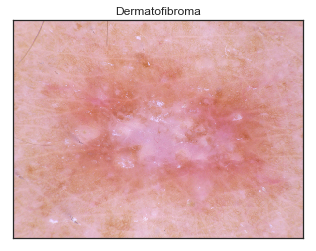

In [3]:
img = mpimg.imread('dataskin/Train/dermatofibroma/ISIC_0025223.jpg')
#this function imshow displays data as an image
imgplot = plt.imshow(img)
#show the picture
plt.title('Dermatofibroma')
# disabling xticks by Setting xticks to an empty list
plt.xticks([]) 
# disabling yticks by setting yticks to an empty list
plt.yticks([]) 
plt.show();

**Pigmented benign keratosis and Seborrheic keratosis**
<br>They are both benign keratosis, in fact most of the times they are classified together.
A seborrheic keratosis is a common noncancerous (benign) skin growth. People tend to get more of them as they get older.

Seborrheic keratoses are usually brown, black or light tan. The growths (lesions) look waxy or scaly and slightly raised. They appear gradually, usually on the face, neck, chest or back.
Seborrheic keratoses are harmless and not contagious. 

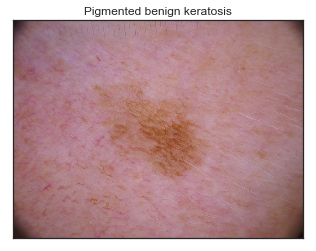

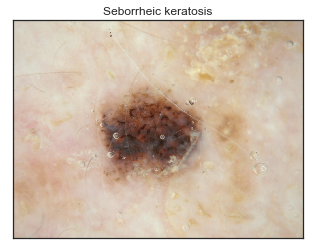

In [4]:
img = mpimg.imread('dataskin/Train/pigmented benign keratosis/ISIC_0024435.jpg')
#this function imshow displays data as an image
imgplot = plt.imshow(img)
#show the picture
plt.title('Pigmented benign keratosis')
# disabling xticks by Setting xticks to an empty list
plt.xticks([]) 
# disabling yticks by setting yticks to an empty list
plt.yticks([]) 
plt.show();
img = mpimg.imread('dataskin/Train/seborrheic keratosis/ISIC_0010810.jpg')
#this function imshow displays data as an image
imgplot = plt.imshow(img)
#show the picture
plt.title('Seborrheic keratosis')
# disabling xticks by Setting xticks to an empty list
plt.xticks([]) 
# disabling yticks by setting yticks to an empty list
plt.yticks([]) 
plt.show();

**Nevus**
<br>Moles (nevi) are a common type of skin growth. They often appear as small, dark brown spots and are caused by clusters of pigment-forming cells (melanocytes). Most people have 10 to 40 moles that appear during childhood and adolescence and may change in appearance or fade over time.

Most moles are harmless. Rarely, they become cancerous. Being aware of changes in your moles and other pigmented patches is important to detecting skin cancer, especially malignant melanoma.

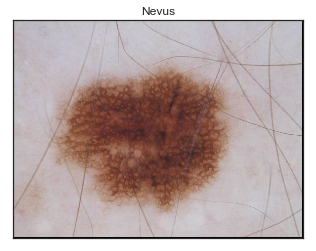

In [5]:
img = mpimg.imread('dataskin/Train/nevus/ISIC_0000019.jpg')
#this function imshow displays data as an image
imgplot = plt.imshow(img)
#show the picture
plt.title('Nevus')
# disabling xticks by Setting xticks to an empty list
plt.xticks([]) 
# disabling yticks by setting yticks to an empty list
plt.yticks([]) 
plt.show();

**Vascular lesion**
<br>Cutaneous vascular lesions are the most common pediatric birthmarks. Flat vascular malformations tend to persist, but raised vascular lesions, known as hemangiomas, generally involute.
Vascular birthmarks are commonly encountered in children and are classified as either hemangiomas or vascular malformations. 
<br>Hemangiomas are benign neoplastic proliferations of vascular endothelial cells characterized by spontaneous involution. In contrast, vascular malformations are not neoplasms but permanent morphogenic abnormalities of capillaries, veins, arteries or lymphatic vessels. <br>Flat lesions (vascular malformations) tend to persist, while raised lesions (hemangiomas) tend to regress.

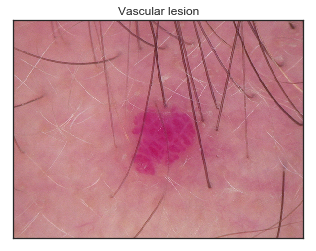

In [6]:
img = mpimg.imread('dataskin/Train/vascular lesion/ISIC_0024475.jpg')
#this function imshow displays data as an image
imgplot = plt.imshow(img)
#show the picture
plt.title('Vascular lesion')
# disabling xticks by Setting xticks to an empty list
plt.xticks([]) 
# disabling yticks by setting yticks to an empty list
plt.yticks([]) 
plt.show();

### Malignant Classes:
**Actinic keratosis**
<br>An actinic keratosis is a rough, scaly patch on the skin that develops from years of sun exposure. It's often found on the face, lips, ears, forearms, scalp, neck or back of the hands.
<br>Actinic keratoses (AKs) are pre-malignant since they may progress to squamous cell carcinoma. They are a common skin condition and develop in sun-exposed skin of individuals with cumulative sun exposure.
<br>Also known as a solar keratosis, an actinic keratosis grows slowly and usually first appears in people over 40.
<br>Left untreated, the risk of actinic keratosis turning into a type of skin cancer called squamous cell carcinoma is about 5% to 10%. 

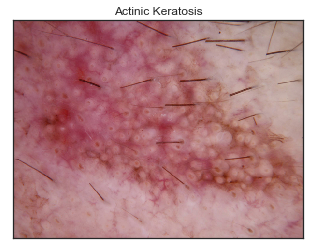

In [7]:
img = mpimg.imread('dataskin/Train/actinic keratosis/ISIC_0025780.jpg')
#this function imshow displays data as an image
imgplot = plt.imshow(img)
#show the picture
plt.title('Actinic Keratosis')
# disabling xticks by Setting xticks to an empty list
plt.xticks([]) 
# disabling yticks by setting yticks to an empty list
plt.yticks([]) 
plt.show();

**Basal cell carcinoma**
<br>Basal cell carcinoma is a type of skin cancer. Basal cell carcinoma begins in the basal cells — a type of cell within the skin that produces new skin cells as old ones die off.

Basal cell carcinoma often appears as a slightly transparent bump on the skin, though it can take other forms. Basal cell carcinoma occurs most often on areas of the skin that are exposed to the sun, such as your head and neck.

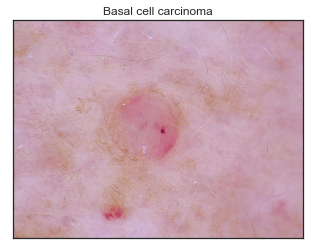

In [8]:
img = mpimg.imread('dataskin/Train/basal cell carcinoma/ISIC_0024572.jpg')
#this function imshow displays data as an image
imgplot = plt.imshow(img)
#show the picture
plt.title('Basal cell carcinoma')
# disabling xticks by Setting xticks to an empty list
plt.xticks([]) 
# disabling yticks by setting yticks to an empty list
plt.yticks([]) 
plt.show();

**Melanoma**
<br>Melanoma, the most serious type of skin cancer, develops in the cells (melanocytes) that produce melanin — the pigment that gives your skin its color. Melanoma can also form in your eyes and, rarely, inside your body, such as in your nose or throat.

The exact cause of all melanomas isn't clear, but exposure to ultraviolet (UV) radiation from sunlight or tanning lamps and beds increases your risk of developing melanoma.
<br>The risk of melanoma seems to be increasing in people under 40, especially women. Knowing the warning signs of skin cancer can help ensure that cancerous changes are detected and treated before the cancer has spread. Melanoma can be treated successfully if it is detected early.

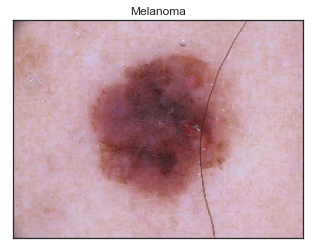

In [9]:
img = mpimg.imread('dataskin/Train/melanoma/ISIC_0000139.jpg')
#this function imshow displays data as an image
imgplot = plt.imshow(img)
#show the picture
plt.title('Melanoma')
# disabling xticks by Setting xticks to an empty list
plt.xticks([]) 
# disabling yticks by setting yticks to an empty list
plt.yticks([]) 
plt.show();

**Squamous cell carcinoma**
<br>Squamous cell carcinoma of the skin is a common form of skin cancer that develops in the squamous cells that make up the middle and outer layers of the skin.

Squamous cell carcinoma of the skin is usually not life-threatening, though it can be aggressive. Untreated, squamous cell carcinoma of the skin can grow large or spread to other parts of your body, causing serious complications.

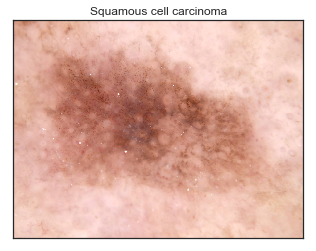

In [10]:
img = mpimg.imread('dataskin/Train/squamous cell carcinoma/ISIC_0024843.jpg')
#this function imshow displays data as an image
imgplot = plt.imshow(img)
#show the picture
plt.title('Squamous cell carcinoma')
# disabling xticks by Setting xticks to an empty list
plt.xticks([]) 
# disabling yticks by setting yticks to an empty list
plt.yticks([]) 
plt.show();

All these informations are taken from the [Mayo Clinic Website](https://www.mayoclinic.org/.) the [National Canter of Biotechonology Website](https://www.ncbi.nlm.nih.gov/) and the [American Family Physician Website](https://www.aafp.org/).

### From the Data Science point of view:

The images are expressed as matrices in which each value represent the pixel value, and specifically each image is comprised of 3 matrices overlapped, one for color Red, one for Green and one for Blue.

> maybe add a picture here from one of the lessons?

In [11]:
train_images_fs[0]

array([[[  0.,   0.,   0.],
        [  0.,   0.,   4.],
        [  0.,   0.,   7.],
        ...,
        [  4.,   0.,   0.],
        [  4.,   0.,   0.],
        [  4.,   0.,   0.]],

       [[  7.,   7.,   9.],
        [187., 186., 192.],
        [187., 185., 196.],
        ...,
        [186., 180., 182.],
        [186., 180., 182.],
        [ 24.,  18.,  20.]],

       [[  2.,   1.,   7.],
        [186., 184., 195.],
        [186., 184., 198.],
        ...,
        [178., 172., 174.],
        [184., 178., 180.],
        [  6.,   0.,   2.]],

       ...,

       [[  5.,   3.,   4.],
        [180., 168., 172.],
        [178., 169., 172.],
        ...,
        [186., 177., 178.],
        [182., 176., 176.],
        [  1.,   0.,   0.]],

       [[ 11.,   5.,   7.],
        [173., 167., 169.],
        [173., 167., 169.],
        ...,
        [185., 179., 181.],
        [185., 179., 181.],
        [  4.,   0.,   0.]],

       [[  3.,   0.,   0.],
        [  6.,   2.,   3.],
        [  6.,  

Previewing one of the images from the train:

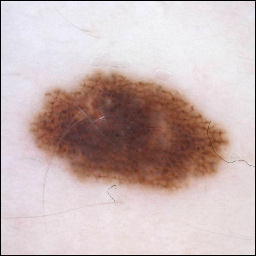

In [12]:
# Preview an image
array_to_img(train_images_fs[0])

Previewing one of the images form the test:

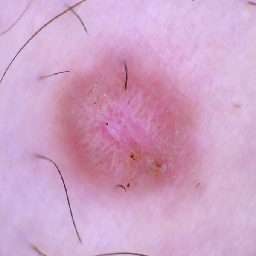

In [13]:
# Preview an image
array_to_img(test_images_fs[0])

Let us look at the shape of our data:

In [14]:
train_labels.shape

(2239, 9)

In [15]:
test_labels.shape

(118, 9)

This makes sense since we have 2239 images for the train and 118 for the test, and they are divided in 9 classes.

In [16]:
test_images_fs.shape

(118, 256, 256, 3)

In [17]:
train_images_fs.shape

(2239, 256, 256, 3)

Same number for the images of train and test, 256x256 is the size of the images, and the 3 is because it's 3 matrices, one for each color pixels RGB.
<br>Let us generate a dataframe to do some more EDA.

In [18]:
dataframe_train=pd.DataFrame(train_labels, columns=['actinic_keratosis', 'basal_cell_carcinoma',\
            'dermatofibroma', 'melanoma', 'nevus', 'pigmented_benign_keratosis',\
            'seborrheic_keratosis', 'squamous_cell_carcinoma', 'vascular_lesion'])

Previewing the different classes and their labels:

In [19]:
dataframe_train

actinic_keratosis  basal_cell_carcinoma  dermatofibroma  melanoma  \
0                   0.0                   0.0             0.0       0.0   
1                   0.0                   0.0             0.0       0.0   
2                   0.0                   1.0             0.0       0.0   
3                   0.0                   0.0             0.0       0.0   
4                   0.0                   0.0             1.0       0.0   
...                 ...                   ...             ...       ...   
2234                0.0                   0.0             0.0       0.0   
2235                0.0                   0.0             0.0       1.0   
2236                0.0                   1.0             0.0       0.0   
2237                0.0                   0.0             0.0       0.0   
2238                0.0                   0.0             0.0       0.0   

      nevus  pigmented_benign_keratosis  seborrheic_keratosis  \
0       1.0                         0.0                   0.0   
1       1.0                         0.0                   0.0   
2       0.0                         0.0                   0.0   
3       0.0                         1.0                   0.0   
4       0.0                         0.0                   0.0   
...     ...                         ...                   ...   
2234    1.0                         0.0                   0.0   
2235    0.0                         0.0                   0.0   
2236    0.0                         0.0                   0.0   
2237    0.0                         1.0                   0.0   
2238    0.0                         0.0                   0.0   

      squamous_cell_carcinoma  vascular_lesion  
0                         0.0              0.0  
1                         0.0              0.0  
2                         0.0              0.0  
3                         0.0              0.0  
4                         0.0              0.0  
...                       ...              ...  
2234                      0.0              0.0  
2235                      0.0              0.0  
2236                      0.0              0.0  
2237                      0.0              0.0  
2238                      1.0              0.0  

[2239 rows x 9 columns]

Taking a look at the class indexes:

In [20]:
train_generator.class_indices 

{'actinic keratosis': 0,
 'basal cell carcinoma': 1,
 'dermatofibroma': 2,
 'melanoma': 3,
 'nevus': 4,
 'pigmented benign keratosis': 5,
 'seborrheic keratosis': 6,
 'squamous cell carcinoma': 7,
 'vascular lesion': 8}

Next we are going to sum the instances for each class to get a sense of how many images we have per class:

In [21]:
sums=dataframe_train.sum(axis=0)
sums=pd.DataFrame(sums)
sums

0
actinic_keratosis           114.0
basal_cell_carcinoma        376.0
dermatofibroma               95.0
melanoma                    438.0
nevus                       357.0
pigmented_benign_keratosis  462.0
seborrheic_keratosis         77.0
squamous_cell_carcinoma     181.0
vascular_lesion             139.0

It seems that benign keratosis, melanoma and basal cell carcinoma are the most represented classes.
Class imbalance might be something to worry about, but that would be a concern mostly when we switch to a binary classification problem, with "benign" and "cancerous" classes.
<br>Converting the sum column into percentages.

In [22]:
sums['%'] = ((sums[0]/2239*100).round(2))
sums

0          %
actinic_keratosis           114.0   5.090000
basal_cell_carcinoma        376.0  16.790001
dermatofibroma               95.0   4.240000
melanoma                    438.0  19.559999
nevus                       357.0  15.940000
pigmented_benign_keratosis  462.0  20.629999
seborrheic_keratosis         77.0   3.440000
squamous_cell_carcinoma     181.0   8.080000
vascular_lesion             139.0   6.210000

In [23]:
sums['%']['nevus']

15.94

In [24]:
total_benign=np.sum([sums['%']['dermatofibroma'], sums['%']['pigmented_benign_keratosis'], 
                    sums['%']['nevus'], sums['%']['seborrheic_keratosis'], 
                    sums['%']['vascular_lesion']])
total_benign

50.459995

In [25]:
total_cancerous=np.sum([sums['%']['melanoma'], sums['%']['actinic_keratosis'], 
                    sums['%']['basal_cell_carcinoma'], sums['%']['squamous_cell_carcinoma']])
total_cancerous

49.520004

We can see that in terms of benign and cancerous, the classes are well balanced on the train set.

Showing in a histogram the distribution of the different images in the train set

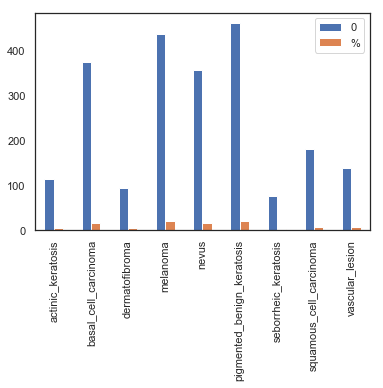

In [26]:
#Change this into seaborn to make it even cooler
sums.plot(kind='bar');

Repeating the same for the test set:

In [27]:
dataframe_test=pd.DataFrame(test_labels, columns=['actinic_keratosis', 'basal_cell_carcinoma',\
            'dermatofibroma', 'melanoma', 'nevus', 'pigmented_benign_keratosis',\
            'seborrheic_keratosis', 'squamous_cell_carcinoma', 'vascular_lesion'])
sums_test=dataframe_test.sum(axis=0)
sums_test=pd.DataFrame(sums_test)

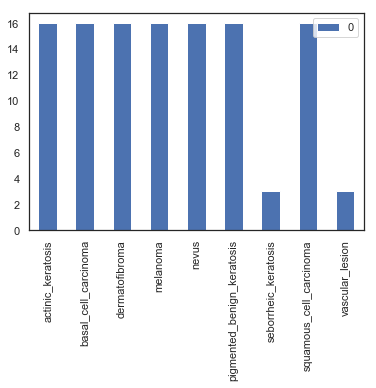

In [28]:
#Change this into seaborn to make it even cooler
sums_test.plot(kind='bar');

It seems like in the test the classes are more equally represented, except for seborrheic keratosis and vascular lesion.

In [29]:
sums_test['%'] = ((sums_test[0] / 118*100).round(2))
sums_test

0      %
actinic_keratosis           16.0  13.56
basal_cell_carcinoma        16.0  13.56
dermatofibroma              16.0  13.56
melanoma                    16.0  13.56
nevus                       16.0  13.56
pigmented_benign_keratosis  16.0  13.56
seborrheic_keratosis         3.0   2.54
squamous_cell_carcinoma     16.0  13.56
vascular_lesion              3.0   2.54

In [30]:
total_benign=np.sum([sums_test['%']['dermatofibroma'], 
                     sums_test['%']['pigmented_benign_keratosis'], 
                    sums_test['%']['nevus'], sums_test['%']['seborrheic_keratosis'], 
                    sums_test['%']['vascular_lesion']])
total_benign

45.760002

In [31]:
total_cancerous=np.sum([sums_test['%']['melanoma'], 
                        sums_test['%']['actinic_keratosis'], 
                    sums_test['%']['basal_cell_carcinoma'], 
                        sums_test['%']['squamous_cell_carcinoma']])
total_cancerous

54.24

For the test set, the percentage of malignant is 54% and bening is 46%.
Still a good balance between the two classes.
>BUT it could be a problem because the distribution between the classes is different, this might be what could bring a problem to the model that hasn't "learnt" how to identify specific classes, that are less present in the train and much more the test.
Namely acitinic keartosis and dermatofibroma.
List this as a possible cause of lower performance.

## Preprocessing

We are going to re-import our images with a lower resolution, since we want the models to be faster especially since we want to try a lot of them, then finally when we will run the final model and test it on the test we will use our best tuned model, retraining it on the full size images.

In [32]:
# Directory path
train_data_dir = 'dataskin/Train'
test_data_dir = 'dataskin/Test'

# Get all the data in the directory data/validation (118 images), and reshape them
test_gen= ImageDataGenerator().flow_from_directory(
        test_data_dir, target_size=(8, 8), batch_size=118)

# Get all the data in the directory data/train (2239 images), and reshape them
train_gen = ImageDataGenerator().flow_from_directory(
        train_data_dir, target_size=(8, 8), batch_size=2239)

# Create the datasets
train_img8, train_lab = next(train_gen)
test_img8, test_lab = next(test_gen)

Found 118 images belonging to 9 classes.
Found 2239 images belonging to 9 classes.


Exploring the shape of images and labels in our dataset:

In [33]:
# Explore your dataset
m_train = train_img8.shape[0]
num_px = train_img8.shape[1]
m_test = test_img8.shape[0]

print ("Number of training samples: " + str(m_train))
print ("Number of testing samples: " + str(m_test))
print ("train_images shape: " + str(train_img8.shape))
print ("train_labels shape: " + str(train_lab.shape))
print ("test_images shape: " + str(test_img8.shape))
print ("test_labels shape: " + str(test_lab.shape))

Number of training samples: 2239
Number of testing samples: 118
train_images shape: (2239, 8, 8, 3)
train_labels shape: (2239, 9)
test_images shape: (118, 8, 8, 3)
test_labels shape: (118, 9)


Reshaping the labels into a format that can be fed to the model:

In [34]:
train_y = np.reshape(train_lab[:,0], (2239,1))
test_y = np.reshape(test_lab[:,0], (118,1))

#### Building functions:

Building some functions that will help us visualize and compare the different models:

In [35]:
def visualize_training_results(results):
    history = results.history
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
    ax1.plot(history['val_acc'])
    ax1.plot(history['acc'])
    ax1.legend(['val_acc', 'acc'], loc='best')
    ax1.set_title('Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    
    ax2.plot(history['val_loss'])
    ax2.plot(history['loss'])
    ax2.legend(['val_loss', 'loss'], loc='best')
    ax2.set_title('Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')

Creating the empty DataFrame where we will store the results:

In [36]:
# create an Empty DataFrame object
df = pd.DataFrame()

Because of the stochastic nature of Neural Networks, it is going to be hard to get consistent results.
What we can do to avoid this problem is to fit the model several times, and keep as a result the mean of the result.
Let us create a function to do that.

In [37]:
def statistic_results(model, trainX, trainy, epochs=20, batch=30):
    accu_train=[]
    accu_val=[]
    loss_train=[]
    loss_val=[]
    for i in range(10):
        resu=fit_model(model, trainX,
                    trainy, epo=epochs, batch=batch)
        accu_train.append(round(resu.history['acc'][-1],5))
        accu_val.append(round(resu.history['val_acc'][-1],5))
        loss_train.append(round(resu.history['loss'][-1],5))
        loss_val.append(round(resu.history['val_loss'][-1],5))
        i+=1
    mean_acc_train=np.mean(accu_train)
    mean_acc_val=np.mean(accu_val)
    mean_loss_train=np.mean(loss_train)
    mean_loss_val=np.mean(loss_val)
    std_at=np.std(accu_train)
    std_av=np.std(accu_val)
    std_lt=np.std(loss_train)
    std_lv=np.std(loss_val)
    return ({'Mean_accuracy_train': mean_acc_train, 
             'Mean_accuracy_validation': mean_acc_val, 
             'Mean_loss_train': mean_loss_train, 
             'Mean_loss_validation': mean_loss_val,
             'Std_acc_train': std_at,
             'Std_acc_val': std_av,
             'Std_loss_train': std_lt,
             'Std_loss_val': std_lv})    
                        

Next we are going to be creating a function to preview the results of our models.
<rb>With this function we will display the evolution of accuracy and loss in our model, during the different epochs.
<br>Below that we will see also the values of accuracy and loss and over time we will build a learning curve, adding the result of each previous model and the current one, to see if our model is improving.

In [38]:
def model_results(model, results, model_name, df, trainX, trainy ):
    visualize_training_results(results)
    stats=statistic_results(model, trainX, trainy)
    df1 = pd.DataFrame({'Name': [model_name],
        'accuracy train': stats['Mean_accuracy_train'] ,
        'accuracy validation': stats['Mean_accuracy_validation'],
        'loss train': stats['Mean_loss_train'],
        'loss validation': stats['Mean_loss_validation']})
    df=df.append(df1)
    fig = plt.subplots(figsize=(12,6))
    
    plt.subplot(1,2,1)
    x=df['Name']
    y=df['accuracy train']
    plt.plot(x, y, color='r')
    x1=df['Name']
    y1=df['accuracy validation']
    plt.plot(x1, y1, color='g')
    plt.xticks(x, labels=df['Name'], rotation='vertical')
    plt.title('Learning Curve Accuracy')
    plt.legend()
 
    plt.subplot(1,2,2)
    x=df['Name']
    y=df['loss train']
    plt.plot(x, y, color='r')
    x1=df['Name']
    y1=df['loss validation']
    plt.plot(x1, y1, color='g')
    plt.xticks(x, labels=df['Name'], rotation='vertical')
    plt.title('Learning Curve Loss')
    plt.legend()

    plt.show()
    return df

And one more function to fit the model and get the results. Also here we can set number of epochs, batch size and validation split, but there are default parameters too.

In [39]:
def fit_model(model, X, y, epo=15, batch=30, val_split=0.2, verbose=0):
    results = model.fit(X, y, epochs=epo, batch_size=batch, 
                        validation_split=val_split, verbose=verbose)
    return results

### Naive model

Let us take a look at the shape of our images, and reshape the labels so they can be fed into the model.

In [40]:
train_img8.shape

(2239, 8, 8, 3)

In [41]:
train_y = np.reshape(train_lab[:,0], (2239,1))
test_y = np.reshape(test_lab[:,0], (118,1))

Creating a first basic model to keep as a reference point.

In [42]:
model = models.Sequential()
model.add(layers.Conv2D(3, (3, 3), activation='relu',
                        input_shape=(8 ,8,  3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(9, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

Fitting the model and getting results.

In [43]:
history = fit_model(model, train_img8,
                    train_y, epo=10, batch=10)

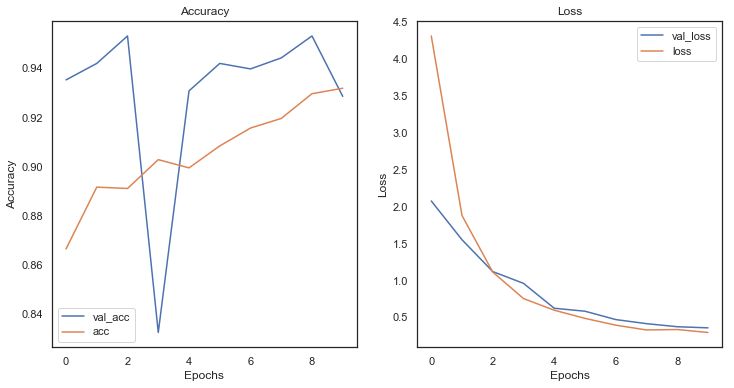

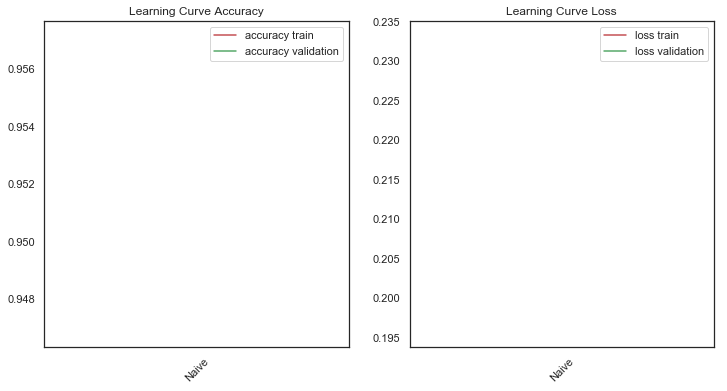

In [44]:
df=model_results(model, history, 'Naive', df, train_img8, train_y)

For now the bottom two graphs are empty because we have only 1 point in our learning curve for both loss and accuracy, but as we keep building models those visuals will be very helpful to see in which direction we are moving. 
<br>Calculating some statistics on our result with our designated function:

In [45]:
stats=statistic_results(model, train_img8,train_y)

In [46]:
stats

{'Mean_accuracy_train': 0.9469600000000001,
 'Mean_accuracy_validation': 0.95759,
 'Mean_loss_train': 0.192579,
 'Mean_loss_validation': 0.37624,
 'Std_acc_train': 1.1102230246251565e-16,
 'Std_acc_val': 0.0,
 'Std_loss_train': 0.017349172573929858,
 'Std_loss_val': 0.0682875164287002}

In [47]:
stats['Mean_accuracy_train']

0.9469600000000001

We can see that even our beginning naive model has already a pretty good accuracy. But we will take all the necessary steps to tune it and improve it. This is going to be helpful also if in the future we want to use this same model with a different dataset that doesn't necessarily have such good results from the start.


## Starting to improve our model:

#### To improve our model we will take several steps:
   - normalize the data 
   - increase image resolution
   - add more epochs
   - add more layers
   - increase the batch size
   - select the best optimization algorithm
   - tune the optimization algorithm parameters (momentum and learning rate)
   - select best activation function
   - tune number of neurons in the layers
   
<br>After this, we will do another round of tuning for the model, this time using:
 - regularization
 - drop out layers

### Improving the model with 9 classes:

The first step to improve our model is to normalize the data.

#### Normalize the data:
As we have seen before the images are in the format of matrices that express the intensity of the color Red Green or Blue for each pixel.
The pixel values are expressed on a scale from 0 to 255, as we can see below:

In [48]:
train_img8[0][1]

array([[139., 102., 120.],
       [165., 129., 155.],
       [197., 163., 180.],
       [218., 182., 208.],
       [211., 182., 213.],
       [139., 108., 123.],
       [ 73.,  59.,  76.],
       [ 84.,  66.,  82.]], dtype=float32)

As we can see the RGB values of each pixel are not scaled, we are going to scale their value between 0 and 1 by dividing each pixel value by 225, which has proven usually helpful in increasing model performance.
To standardize the pixel values:

In [49]:
train_img8 /= 255.

In [50]:
train_img8[0][1]

array([[0.54509807, 0.4       , 0.47058824],
       [0.64705884, 0.5058824 , 0.60784316],
       [0.77254903, 0.6392157 , 0.7058824 ],
       [0.85490197, 0.7137255 , 0.8156863 ],
       [0.827451  , 0.7137255 , 0.8352941 ],
       [0.54509807, 0.42352942, 0.48235294],
       [0.28627452, 0.23137255, 0.29803923],
       [0.32941177, 0.25882354, 0.32156864]], dtype=float32)

Now the pixels are expressed in values between 0 and 1.
<br>We move on to fit our model and preview the results.

In [51]:
history1 = fit_model(model, train_img8, train_y)

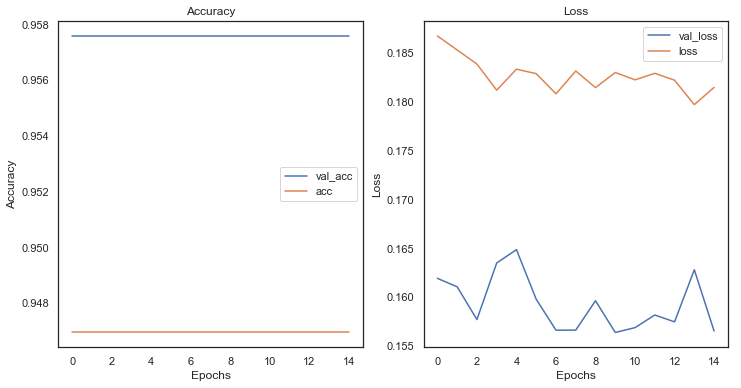

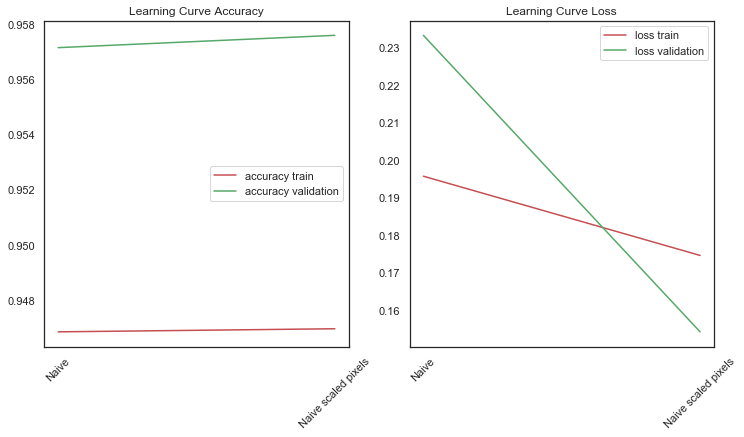

Name                                              model  \
0                Naive  <tensorflow.python.keras.engine.sequential.Seq...   
0  Naive scaled pixels  <tensorflow.python.keras.engine.sequential.Seq...   

   accuracy train  accuracy validation  loss train  loss validation  
0        0.946848             0.957144    0.195675         0.233176  
0        0.946960             0.957590    0.174592         0.154246

In [52]:
df=model_results(model, history1, 'Naive scaled pixels', df, train_img8, train_y)
df

> add comment about performance of the model after monitoring 3/4 days.
On day 1 the accuracy of both train and val went up, and  the loss of both train and validation went down.

#### Adding more layers and using higher resolution images:

Let us move on from the basic naive model to a more structured one with more layers.
<br>We will define it with a function that will allow us to also tweak other parameters, which is what we will do to keep tuning our model.
<br>With this function we can set all the parameters that we want, input_shape, activation function, loss, optimizer algorithm, metrics etc.
<br>We will also set most of these parameters as default, to make the execution of the function not too heavy.

In [53]:
def create_model(input_shape=(64, 64, 3), activation='relu', 
                 loss='sparse_categorical_crossentropy', 
                optimizer='rmsprop',metrics=['acc'] , 
                 neur1=10, neur2=20, pool=(2,2)):
 # create model
    model = models.Sequential()
    model.add(layers.Conv2D(neur1, (3, 3), activation=activation,
                        input_shape=input_shape))
    model.add(layers.MaxPooling2D(pool))
    
    model.add(layers.Conv2D(neur1, (4, 4), activation=activation))
    model.add(layers.MaxPooling2D(pool))

    model.add(layers.Conv2D(neur2, (3, 3), activation=activation))
    model.add(layers.MaxPooling2D(pool))

    model.add(layers.Flatten())
    model.add(layers.Dense(32, activation=activation))
    model.add(layers.Dense(9, activation='softmax'))

# Compile model
    model.compile(loss=loss,
              optimizer=optimizer,
              metrics=metrics)
    return model

Let us import images with resolution 32x32, and create a model with more layers.

In [54]:
# Directory path
train_data_dir = 'dataskin/Train'
test_data_dir = 'dataskin/Test'

# Get all the data in the directory data/validation (118 images), and reshape them
test_gen= ImageDataGenerator().flow_from_directory(
        test_data_dir, target_size=(32, 32), batch_size=118)

# Get all the data in the directory data/train (2239 images), and reshape them
train_gen = ImageDataGenerator().flow_from_directory(
        train_data_dir, target_size=(32, 32), batch_size=2239)

# Create the datasets
train_img32, train_lab = next(train_gen)
test_img32, test_lab = next(test_gen)

Found 118 images belonging to 9 classes.
Found 2239 images belonging to 9 classes.


In [55]:
model_a=create_model(input_shape=(32,32,3))

In [56]:
history2 = fit_model(model_a, train_img32, train_y)

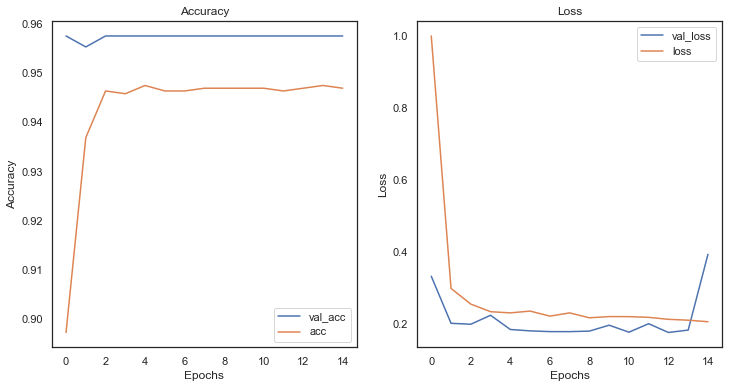

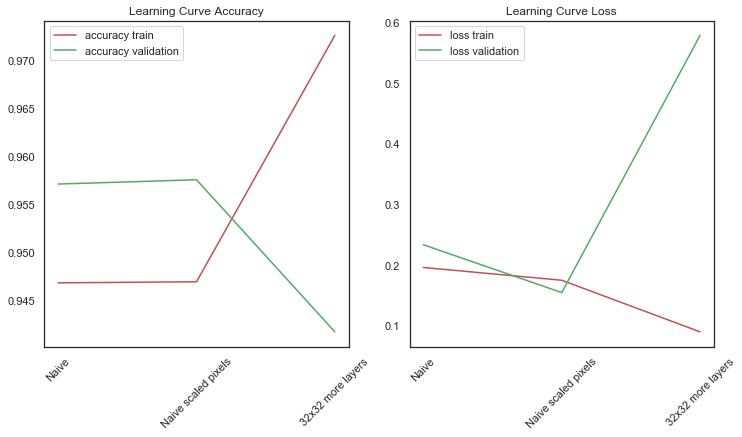

Name                                              model  \
0                Naive  <tensorflow.python.keras.engine.sequential.Seq...   
0  Naive scaled pixels  <tensorflow.python.keras.engine.sequential.Seq...   
0    32x32 more layers  <tensorflow.python.keras.engine.sequential.Seq...   

   accuracy train  accuracy validation  loss train  loss validation  
0        0.946848             0.957144    0.195675         0.233176  
0        0.946960             0.957590    0.174592         0.154246  
0        0.972640             0.941741    0.089378         0.579092

In [57]:
df=model_results(model_a, history2, '32x32 more layers', df, train_img32, train_y)
df

> add comments on the performance of the model
on Day 1:
accuracy of train went up to 975 but accuracy of validation went down to 94. We start to see overfitting.
Confirmed by the fact that loss of train went down, but loss of accuracy went way up to 0.7

#### Increasing Image resolution:
Next to improve our model we will use images with a higher resolution to improve the performance.
Importing images with 64x64 image resolution:

In [58]:
# Directory path
train_data_dir = 'dataskin/Train'
test_data_dir = 'dataskin/Test'

# Get all the data in the directory data/train (2239 images), and reshape them
train_gen = ImageDataGenerator().flow_from_directory(
        train_data_dir, target_size=(64, 64), batch_size=2239)

# Get all the data in the directory data/validation (118 images), and reshape them
test_gen= ImageDataGenerator().flow_from_directory(
        test_data_dir, target_size=(64, 64), batch_size=118)

# Create the datasets
train_img64, train_lab = next(train_gen)
test_img64, test_lab = next(test_gen)

#normalizing again
train_img64 /= 255.
test_img64 /= 255.

Found 2239 images belonging to 9 classes.
Found 118 images belonging to 9 classes.


In [59]:
#Reshaping labels so they can be fed to the model
train_y = np.reshape(train_lab[:,0], (2239,1))
test_y = np.reshape(test_lab[:,0], (118,1))

We need to create another model, since the input shape changed:

In [60]:
# No need to specify input shape, since the default is 64x64
model_b=create_model()

Fitting the model

In [61]:
history3 = fit_model(model_b, train_img64, train_y)

Let us visualize the results:

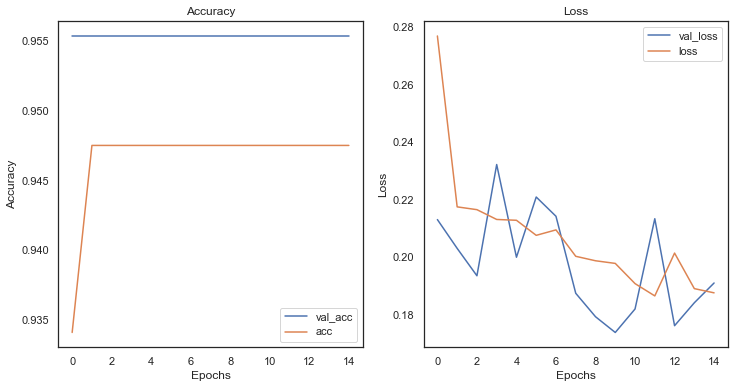

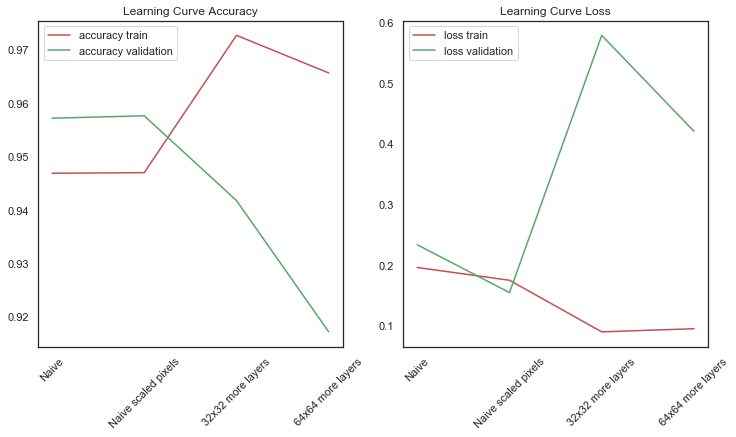

Name                                              model  \
0                Naive  <tensorflow.python.keras.engine.sequential.Seq...   
0  Naive scaled pixels  <tensorflow.python.keras.engine.sequential.Seq...   
0    32x32 more layers  <tensorflow.python.keras.engine.sequential.Seq...   
0    64x64 more layers  <tensorflow.python.keras.engine.sequential.Seq...   

   accuracy train  accuracy validation  loss train  loss validation  
0        0.946848             0.957144    0.195675         0.233176  
0        0.946960             0.957590    0.174592         0.154246  
0        0.972640             0.941741    0.089378         0.579092  
0        0.965606             0.917188    0.094529         0.420537

In [62]:
df=model_results(model_b, history3, '64x64 more layers', df,train_img64, train_y )
df

> Adding comments to the performance:
accuracy both train and val went down. But train still overfitting.
Loss of train and accuracy went down, still overfitting.

We tried also importing the images in their full size, and training the model on those but there was no substantial improvement in the performance, therefore we decided it was not worth the extra long computational time, and we did not include it.

Adding these images as the default in our `model_results` function since they'll be the ones we'll be using the most.

In [63]:
def model_results(model, results, model_name, df, trainX=train_img64, trainy=train_y ):
    visualize_training_results(results)
    stats=statistic_results(model, trainX, trainy)
    df1 = pd.DataFrame({'Name': [model_name],
        'accuracy train': stats['Mean_accuracy_train'] ,
        'accuracy validation': stats['Mean_accuracy_validation'],
        'loss train': stats['Mean_loss_train'],
        'loss validation': stats['Mean_loss_validation']})
    df=df.append(df1)
    fig = plt.subplots(figsize=(12,6))
    
    plt.subplot(1,2,1)
    x=df['Name']
    y=df['accuracy train']
    plt.plot(x, y, color='r')
    x1=df['Name']
    y1=df['accuracy validation']
    plt.plot(x1, y1, color='g')
    plt.xticks(x, labels=df['Name'], rotation='vertical')
    plt.title('Learning Curve Accuracy')
    plt.legend()
 
    plt.subplot(1,2,2)
    x=df['Name']
    y=df['loss train']
    plt.plot(x, y, color='r')
    x1=df['Name']
    y1=df['loss validation']
    plt.plot(x1, y1, color='g')
    plt.xticks(x, labels=df['Name'], rotation='vertical')
    plt.title('Learning Curve Loss')
    plt.legend()

    plt.show()
    return df

#### Increasing number of epochs:
Keeping the same model, but we run the model longer, for 30 epochs.

In [64]:
history4 = fit_model(model_b, train_img64, train_y, epo=30)

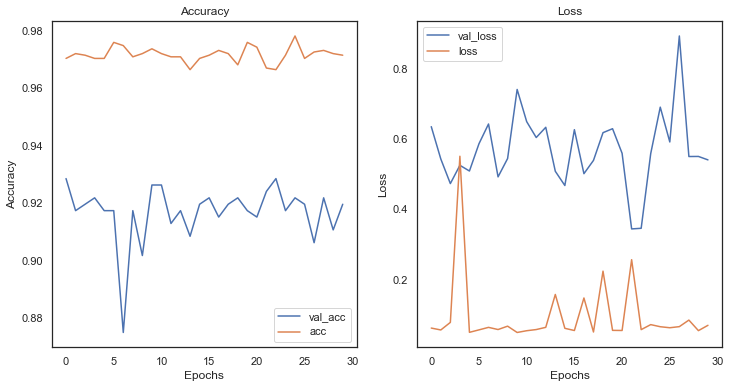

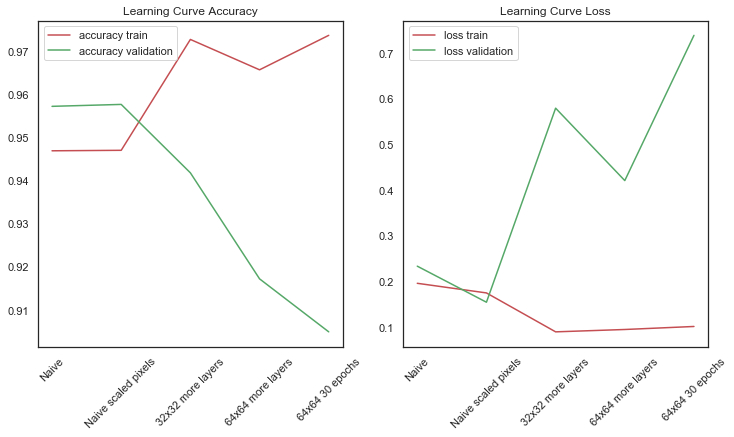

Name                                              model  \
0                Naive  <tensorflow.python.keras.engine.sequential.Seq...   
0  Naive scaled pixels  <tensorflow.python.keras.engine.sequential.Seq...   
0    32x32 more layers  <tensorflow.python.keras.engine.sequential.Seq...   
0    64x64 more layers  <tensorflow.python.keras.engine.sequential.Seq...   
0      64x64 30 epochs                                                NaN   

   accuracy train  accuracy validation  loss train  loss validation  
0        0.946848             0.957144    0.195675         0.233176  
0        0.946960             0.957590    0.174592         0.154246  
0        0.972640             0.941741    0.089378         0.579092  
0        0.965606             0.917188    0.094529         0.420537  
0        0.973590             0.904911    0.101146         0.738544

In [65]:
df=model_results(model_b, history4, '64x64 30 epochs', df)
df

> Comments on the performance:
accuracy train back up, accuracy val back down, even more overfitting.
Loss train slightly down, loss accuracy back up.
Still overfitting.

#### Increase the batch size: 50

This time we will increase the batch size, which is the group of pictures taken at a time by the model to work on.

In [66]:
history5 = fit_model(model_b, train_img64, train_y, epo=30, batch=50)

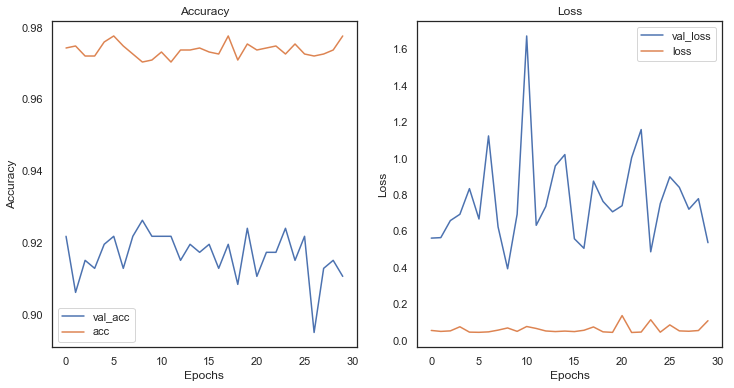

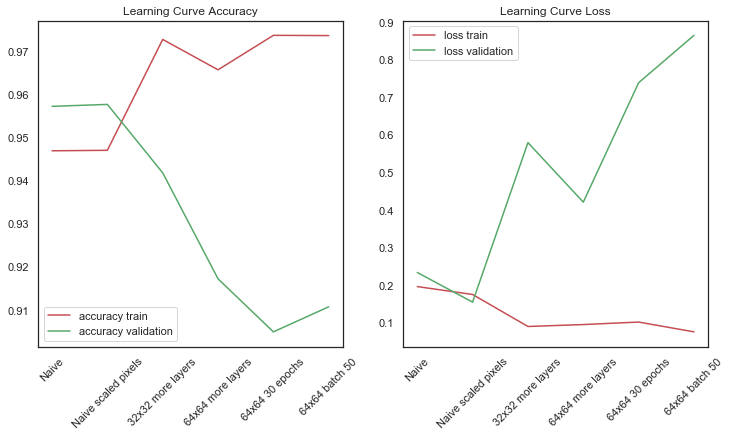

Name                                              model  \
0                Naive  <tensorflow.python.keras.engine.sequential.Seq...   
0  Naive scaled pixels  <tensorflow.python.keras.engine.sequential.Seq...   
0    32x32 more layers  <tensorflow.python.keras.engine.sequential.Seq...   
0    64x64 more layers  <tensorflow.python.keras.engine.sequential.Seq...   
0      64x64 30 epochs                                                NaN   
0       64x64 batch 50                                                NaN   

   accuracy train  accuracy validation  loss train  loss validation  
0        0.946848             0.957144    0.195675         0.233176  
0        0.946960             0.957590    0.174592         0.154246  
0        0.972640             0.941741    0.089378         0.579092  
0        0.965606             0.917188    0.094529         0.420537  
0        0.973590             0.904911    0.101146         0.738544  
0        0.973532             0.910714    0.075095         0.864797

In [67]:
df=model_results(model_b, history5, '64x64 batch 50', df)
df

> Comments on the performance: accuracy train stayed the same, accuracy val went even more down, still overfitting.
Loss train slightly up, loss validation way up.

The truth is that just getting one result for each of these attempts doesn't really tell us too much about the improvement or not of our model, because of the randomness of the results.
<br>What would be more appropriate is for each change we do (in the size of the images, the number of epochs, the batch size) to try a few different values to be able to really get a sense of in which direction our model is moving with that change.
<br>This would be very time consuming to do by hand, so the next step we are going to take is building a grid search for these parameters to get a better answer in terms of which ones are the optimal characteristic of our model, which gives us the best accuracy in determining the classification of the skin anomaly.

### Grid Search batch size and epochs:

Grid search is a model hyperparameter optimization technique.
In scikit learn this is a class, and when running a search with this class, we must input a dictionary of hyperparameters to evaluate in the param_grid argument. 
This dictionary contains the model parameter name and an array of values to try.

The GridSearchCV essentially builds and then evaluates one model for each combination of parameters. 
To evaluate each individual model, a 3-fold cross validation is used.

Once we  find out from the GridSearch what are the best parameters we can use those (running just one single model) with higher resolution images.

Since GridSearch takes a long time to run, for this one and also the following ones we included the code but commented it out, so that it can be used again to run more grid searches also with different dataset.
We are saving the parameters that were identified by the search as the best ones (see below) so that the search doesn't need to be re run every time.

In [68]:
"""
# Use scikit-learn to grid search the batch size and epochs
# fix random seed for reproducibility
seed = 42
tf.random.set_seed(seed)

#set X and Y
X=train_img64
Y=train_y
# create model
model = KerasClassifier(model=create_model())
# define the grid search parameters
batch_size = [10, 20, 40, 60, 80, 100]
epochs = [10, 50, 100]
param_grid = dict(batch_size=batch_size, epochs=epochs)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X, Y)
"""
#code from Jason Brownlee on https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/

'\n# Use scikit-learn to grid search the batch size and epochs\n# fix random seed for reproducibility\nseed = 42\ntf.random.set_seed(seed)\n\n#set X and Y\nX=train_img64\nY=train_y\n# create model\nmodel = KerasClassifier(model=create_model())\n# define the grid search parameters\nbatch_size = [10, 20, 40, 60, 80, 100]\nepochs = [10, 50, 100]\nparam_grid = dict(batch_size=batch_size, epochs=epochs)\ngrid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)\ngrid_result = grid.fit(X, Y)\n'

In [69]:
"""
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    """

'\n# summarize results\nprint("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))\nmeans = grid_result.cv_results_[\'mean_test_score\']\nstds = grid_result.cv_results_[\'std_test_score\']\nparams = grid_result.cv_results_[\'params\']\nfor mean, stdev, param in zip(means, stds, params):\n    print("%f (%f) with: %r" % (mean, stdev, param))\n    '

In [70]:
#best_params=grid_result.best_params_
#best_params

In [71]:
#best_batch=best_params['batch_size']

Defining as `best_batch` the result from the grid search: 10.

In [72]:
best_batch=10

In [73]:
#best_epochs=best_params['epochs']

Defining as `best_epochs` the result form the grid search: also 10.

In [74]:
best_epochs=10

Now we can run again a model with the higher resolution images, using the best parameters we obtained from the grid search.

In [75]:
history6 = fit_model(model_b, train_img64, train_y, epo=best_epochs,
                    batch=best_batch)

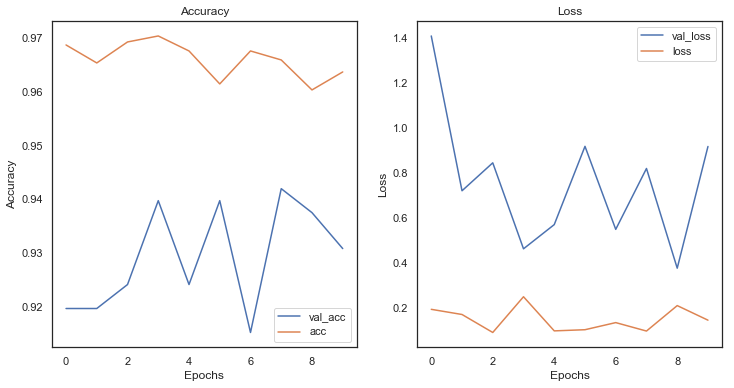

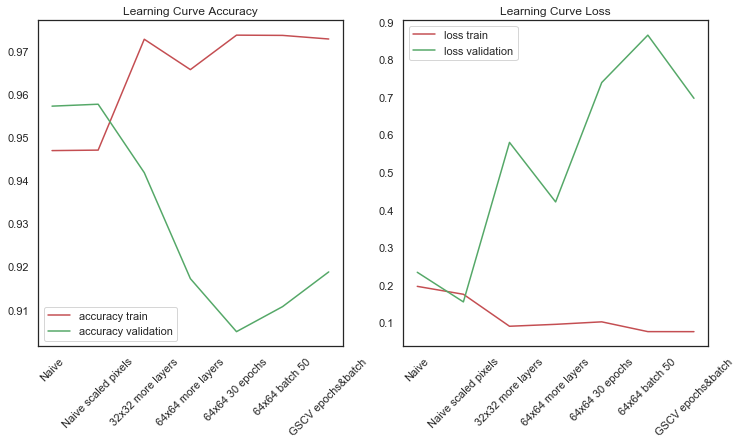

Name                                              model  \
0                Naive  <tensorflow.python.keras.engine.sequential.Seq...   
0  Naive scaled pixels  <tensorflow.python.keras.engine.sequential.Seq...   
0    32x32 more layers  <tensorflow.python.keras.engine.sequential.Seq...   
0    64x64 more layers  <tensorflow.python.keras.engine.sequential.Seq...   
0      64x64 30 epochs                                                NaN   
0       64x64 batch 50                                                NaN   
0    GSCV epochs&batch                                                NaN   

   accuracy train  accuracy validation  loss train  loss validation  
0        0.946848             0.957144    0.195675         0.233176  
0        0.946960             0.957590    0.174592         0.154246  
0        0.972640             0.941741    0.089378         0.579092  
0        0.965606             0.917188    0.094529         0.420537  
0        0.973590             0.904911    0.101146         0.738544  
0        0.973532             0.910714    0.075095         0.864797  
0        0.972697             0.918750    0.075013         0.696519

In [76]:
df=model_results(model_b, history6, 'GSCV epochs&batch', df)
df

> comment on the performance: accuracy train and validation stayed the same. Loss train went a bit down, loss validation went a bit up.

Changing the parameters in the definition of the function so I don't need to specify them again every time:

In [77]:
def statistic_results(model, trainX, trainy, epochs=best_epochs, batch=best_batch):
    accu_train=[]
    accu_val=[]
    loss_train=[]
    loss_val=[]
    for i in range(10):
        resu=fit_model(model, trainX,
                    trainy, epo=epochs, batch=batch)
        accu_train.append(round(resu.history['acc'][-1],5))
        accu_val.append(round(resu.history['val_acc'][-1],5))
        loss_train.append(round(resu.history['loss'][-1],5))
        loss_val.append(round(resu.history['val_loss'][-1],5))
        i+=1
    mean_acc_train=np.mean(accu_train)
    mean_acc_val=np.mean(accu_val)
    mean_loss_train=np.mean(loss_train)
    mean_loss_val=np.mean(loss_val)
    std_at=np.std(accu_train)
    std_av=np.std(accu_val)
    std_lt=np.std(loss_train)
    std_lv=np.std(loss_val)
    return ({'Mean_accuracy_train': mean_acc_train, 
             'Mean_accuracy_validation': mean_acc_val, 
             'Mean_loss_train': mean_loss_train, 
             'Mean_loss_validation': mean_loss_val,
             'Std_acc_train': std_at,
             'Std_acc_val': std_av,
             'Std_loss_train': std_lt,
             'Std_loss_val': std_lv})

### Grid Search Optimization Algorithm:

We can run again a GridSearch, but this time instead of trying different numbers of epochs and batch sizes, we will try different optimization algorithms. Here is a lists of them, and as we can see from the number of options, GridSearch is a good idea to shorten the time in trying all the different possible combinations:

- 'SGD'
- 'RMSprop'
- 'Adagrad'
- 'Adadelta'
- 'Adam' 
- 'Adamax' 
- 'Nadam'

The most popular and known ones are SGD, RMS prop and Adam.
RMS Prop is Root mean squared prop - it slows down learning in one direction and speeds it up in another one. On each iteration it uses exponentially weighted average of the squares of the derivatives.
SGD stands for Stochastic Gradient Descent - works like gradient descent but SGD randomly picks one data point from the whole data set at each iteration to reduce the computations enormously. Stochastic gradient descent maintains a single learning rate (termed alpha) for all weight updates and the learning rate does not change during training.
Adam: adaptive moment estimation - combines the benefits of SGD and RMSProp. Instead of adapting the parameter learning rates based on the average first moment (the mean) as in RMSProp, Adam also makes use of the average of the second moments of the gradients.

We already have the function to create the model, and the X and Y we set before are the same. We just need to change the grid for the search of the parameters.

In [78]:
"""
# create model
model = KerasClassifier(model=create_model(), 
                        loss="sparse_categorical_crossentropy", 
                        epochs=best_epochs, batch_size=best_batch)
# define the grid search parameters
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
param_grid = dict(optimizer=optimizer)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X, Y)
"""
#code from Jason Brownlee on https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/


'\n# create model\nmodel = KerasClassifier(model=create_model(), \n                        loss="sparse_categorical_crossentropy", \n                        epochs=best_epochs, batch_size=best_batch)\n# define the grid search parameters\noptimizer = [\'SGD\', \'RMSprop\', \'Adagrad\', \'Adadelta\', \'Adam\', \'Adamax\', \'Nadam\']\nparam_grid = dict(optimizer=optimizer)\ngrid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)\ngrid_result = grid.fit(X, Y)\n'

In [79]:
"""
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
"""

'\n# summarize results\nprint("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))\nmeans = grid_result.cv_results_[\'mean_test_score\']\nstds = grid_result.cv_results_[\'std_test_score\']\nparams = grid_result.cv_results_[\'params\']\nfor mean, stdev, param in zip(means, stds, params):\n    print("%f (%f) with: %r" % (mean, stdev, param))\n'

In [80]:
#best_params=grid_result.best_params_
#best_params

In [81]:
#best_opti=best_params['optimizer']
#best_opti

Defining as `best_opti` the parameter found by the grid search: sgd.

In [82]:
### Just for now let me add this so we don't have to redo the search
best_opti='sgd'

Creating a new model with the selected optimizer algorithm:

In [83]:
model_d=create_model(optimizer=best_opti)

In [84]:
history7 = fit_model(model_d, train_img64, train_y,
                    epo=best_epochs,
                    batch=best_batch)

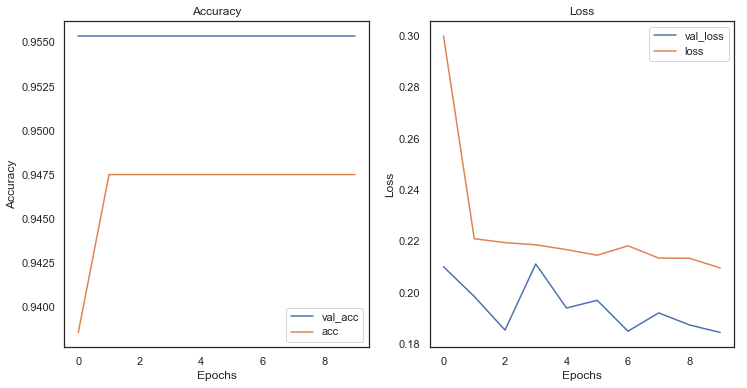

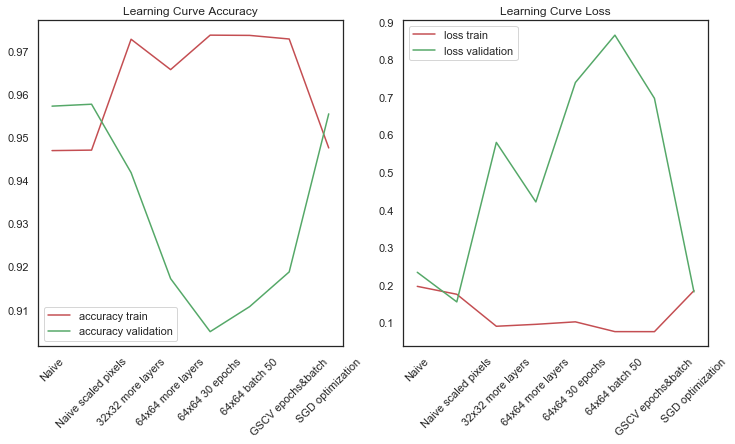

Name                                              model  \
0                Naive  <tensorflow.python.keras.engine.sequential.Seq...   
0  Naive scaled pixels  <tensorflow.python.keras.engine.sequential.Seq...   
0    32x32 more layers  <tensorflow.python.keras.engine.sequential.Seq...   
0    64x64 more layers  <tensorflow.python.keras.engine.sequential.Seq...   
0      64x64 30 epochs                                                NaN   
0       64x64 batch 50                                                NaN   
0    GSCV epochs&batch                                                NaN   
0     SGD optimization                                                NaN   

   accuracy train  accuracy validation  loss train  loss validation  
0        0.946848             0.957144    0.195675         0.233176  
0        0.946960             0.957590    0.174592         0.154246  
0        0.972640             0.941741    0.089378         0.579092  
0        0.965606             0.917188    0.094529         0.420537  
0        0.973590             0.904911    0.101146         0.738544  
0        0.973532             0.910714    0.075095         0.864797  
0        0.972697             0.918750    0.075013         0.696519  
0        0.947464             0.955360    0.184236         0.180860

In [85]:
df=model_results(model_d, history7, 'SGD optimization', df)
df

> Comment on the performance: accuracy train went down to 0.95 but accuracy val went way up to also almost 0.95 Muhc much less overfitting, confirmed also by the loss, which is almost the same for validation and train, 0.2.

### Grid Search Learning Rate and Momentum

Learning rate and momentum are parameters of the SGD optimization algorithm that we can tune.
The learning rate defines the extent to update the weight at the end of each batch, and the momentum defines how much to let the previous update influence the next weight update.

In [86]:
"""
# fix random seed for reproducibility
seed = 42
tf.random.set_seed(seed)

#set X and Y
X=train_img64
Y=train_y
"""

'\n# fix random seed for reproducibility\nseed = 42\ntf.random.set_seed(seed)\n\n#set X and Y\nX=train_img64\nY=train_y\n'

In [87]:
"""
# create model
model = KerasClassifier(model=create_model, loss="sparse_categorical_crossentropy", 
                        optimizer="SGD", epochs=20, batch_size=20, verbose=0)
# define the grid search parameters
learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
momentum = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]
param_grid = dict(optimizer__learning_rate=learn_rate, optimizer__momentum=momentum)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X, Y)
"""

'\n# create model\nmodel = KerasClassifier(model=create_model, loss="sparse_categorical_crossentropy", \n                        optimizer="SGD", epochs=20, batch_size=20, verbose=0)\n# define the grid search parameters\nlearn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]\nmomentum = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]\nparam_grid = dict(optimizer__learning_rate=learn_rate, optimizer__momentum=momentum)\ngrid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)\ngrid_result = grid.fit(X, Y)\n'

In [88]:
"""
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    """

'\n# summarize results\nprint("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))\nmeans = grid_result.cv_results_[\'mean_test_score\']\nstds = grid_result.cv_results_[\'std_test_score\']\nparams = grid_result.cv_results_[\'params\']\nfor mean, stdev, param in zip(means, stds, params):\n    print("%f (%f) with: %r" % (mean, stdev, param))\n    '

Let us print out just the best learning rate and momentum:

In [89]:
#best_params=grid_result.best_params_
#best_params

In [90]:
#best_rate=best_params['optimizer__learning_rate']
#best_rate

In [91]:
best_rate=0.001

In [92]:
#best_momentum=best_params['optimizer__momentum']
               

In [93]:
best_momentum=0.9

Next we will define the optimizer as SGD with the parameters selected by the Grid Search, and then create a model, fit it and preview the results.

In [94]:
optimizer = tf.keras.optimizers.SGD(learning_rate=best_rate, 
                                    momentum=best_momentum)

In [95]:
model_e=create_model(optimizer=optimizer)

In [96]:
history8= fit_model(model_e, train_img64, train_y,
                     epo=best_epochs,batch=best_batch)

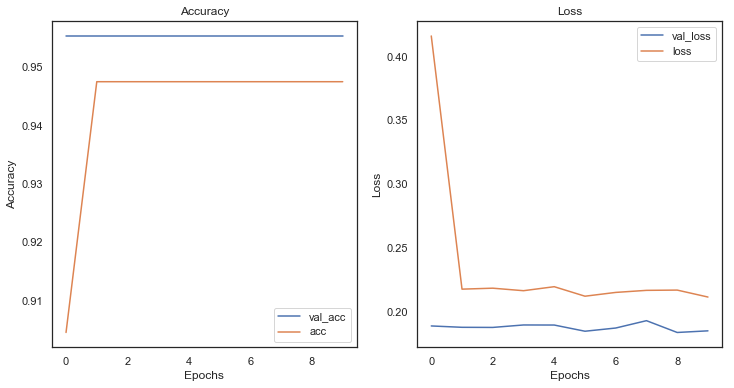

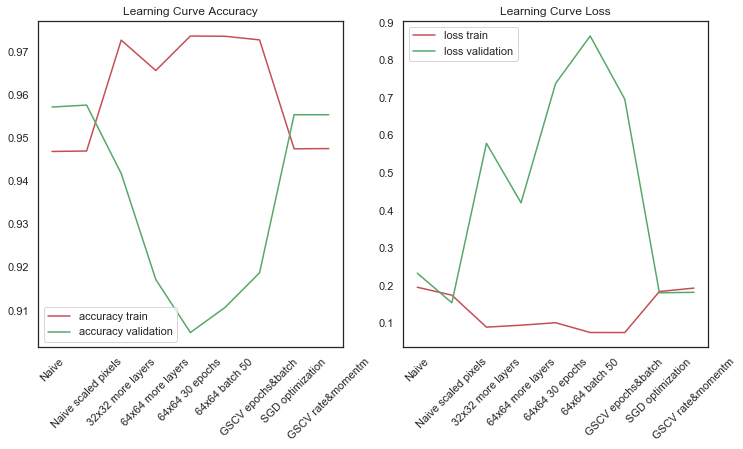

Name                                              model  \
0                Naive  <tensorflow.python.keras.engine.sequential.Seq...   
0  Naive scaled pixels  <tensorflow.python.keras.engine.sequential.Seq...   
0    32x32 more layers  <tensorflow.python.keras.engine.sequential.Seq...   
0    64x64 more layers  <tensorflow.python.keras.engine.sequential.Seq...   
0      64x64 30 epochs                                                NaN   
0       64x64 batch 50                                                NaN   
0    GSCV epochs&batch                                                NaN   
0     SGD optimization                                                NaN   
0    GSCV rate&momentm                                                NaN   

   accuracy train  accuracy validation  loss train  loss validation  
0        0.946848             0.957144    0.195675         0.233176  
0        0.946960             0.957590    0.174592         0.154246  
0        0.972640             0.941741    0.089378         0.579092  
0        0.965606             0.917188    0.094529         0.420537  
0        0.973590             0.904911    0.101146         0.738544  
0        0.973532             0.910714    0.075095         0.864797  
0        0.972697             0.918750    0.075013         0.696519  
0        0.947464             0.955360    0.184236         0.180860  
0        0.947520             0.955360    0.193331         0.182139

In [97]:
df=model_results(model_e, history8, 'GSCV rate&momentm', df)
df

> basically all the same

### How to Tune the Neuron Activation Function

#### Changing activation functions and optimizations:
Some of the options for activation functions are:
- relu
- swish
- softmax
- leaky relu
- sigmoid

The activation function is the one that translates the probability calculated by the model into the label of an actual class. An image might have a 60, 70 or 80% chance to belong to a class, which needs to be translated into the fact that the image belongs to that class, 1, or it doesn't, 0.
<br>For multiclass classifications the appropriate one is softmax, but we will tune the other ones for the previous layers of the model.

In [98]:
# Function to create model, required for KerasClassifier
def create_model_CV(activation):
 # create model
    model = models.Sequential()
    model.add(layers.Conv2D(10, (3, 3), activation=activation,
                        input_shape=(64,64,3)))
    model.add(layers.MaxPooling2D(2,2))
    
    model.add(layers.Conv2D(10, (4, 4), activation=activation))
    model.add(layers.MaxPooling2D(2,2))

    model.add(layers.Conv2D(20, (3, 3), activation=activation))
    model.add(layers.MaxPooling2D(2,2))

    model.add(layers.Flatten())
    model.add(layers.Dense(32, activation=activation))
    model.add(layers.Dense(9, activation='softmax'))

 # Compile model
    model.compile(loss='sparse_categorical_crossentropy', 
                   optimizer=optimizer, metrics=['accuracy'])
    return model

In [99]:
"""
# create model
model = KerasClassifier(model=create_model_CV, epochs=20, batch_size=20)
# define the grid search parameters
activation = ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 
              'hard_sigmoid', 'linear']
param_grid = dict(model__activation=activation)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X, Y)
"""

"\n# create model\nmodel = KerasClassifier(model=create_model_CV, epochs=20, batch_size=20)\n# define the grid search parameters\nactivation = ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', \n              'hard_sigmoid', 'linear']\nparam_grid = dict(model__activation=activation)\ngrid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)\ngrid_result = grid.fit(X, Y)\n"

In [100]:
"""
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    """

'\n# summarize results\nprint("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))\nmeans = grid_result.cv_results_[\'mean_test_score\']\nstds = grid_result.cv_results_[\'std_test_score\']\nparams = grid_result.cv_results_[\'params\']\nfor mean, stdev, param in zip(means, stds, params):\n    print("%f (%f) with: %r" % (mean, stdev, param))\n    '

Best activation function is:

In [101]:
#best_params=grid_result.best_params_
#best_params

In [102]:
#best_function=best_params['model__activation']
#best_function

Defining as `best_function` the function selected by the Grid Search: 'softmax'.

In [103]:
best_function='softmax'

Creating the model, fitting it and viewing results.

In [104]:
model_f=create_model(activation=best_function, optimizer=optimizer)

In [105]:
history9= fit_model(model_f, train_img64, train_y,
                     epo=best_epochs, batch=best_batch)

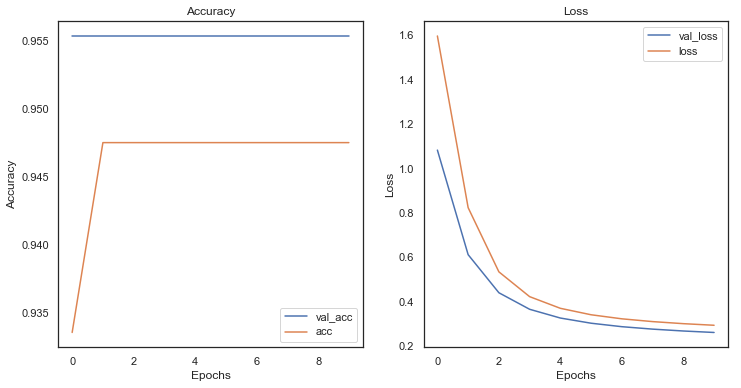

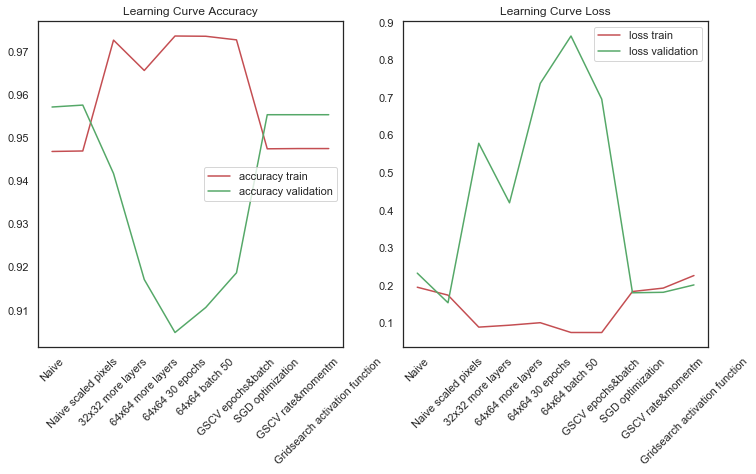

Name  \
0                           Naive   
0             Naive scaled pixels   
0               32x32 more layers   
0               64x64 more layers   
0                 64x64 30 epochs   
0                  64x64 batch 50   
0               GSCV epochs&batch   
0                SGD optimization   
0               GSCV rate&momentm   
0  Gridsearch activation function   

                                               model  accuracy train  \
0  <tensorflow.python.keras.engine.sequential.Seq...        0.946848   
0  <tensorflow.python.keras.engine.sequential.Seq...        0.946960   
0  <tensorflow.python.keras.engine.sequential.Seq...        0.972640   
0  <tensorflow.python.keras.engine.sequential.Seq...        0.965606   
0                                                NaN        0.973590   
0                                                NaN        0.973532   
0                                                NaN        0.972697   
0                                                NaN        0.947464   
0                                                NaN        0.947520   
0                                                NaN        0.947520   

   accuracy validation  loss train  loss validation  
0             0.957144    0.195675         0.233176  
0             0.957590    0.174592         0.154246  
0             0.941741    0.089378         0.579092  
0             0.917188    0.094529         0.420537  
0             0.904911    0.101146         0.738544  
0             0.910714    0.075095         0.864797  
0             0.918750    0.075013         0.696519  
0             0.955360    0.184236         0.180860  
0             0.955360    0.193331         0.182139  
0             0.955360    0.226823         0.201814

In [106]:
df=model_results(model_f, history9, 'Gridsearch activation function', df)
df

> basically all the same, slightly higher loss for both val and train

### Grid Search number of neurons:

Next we are going to perform a grid search to find the beset number of neurons for the first 4 layers of our CNN. The last layer is set by the number of classes that we have, in our case 9.
<br>For this grid search we have to slightly modify our `create_model` function:

In [107]:
# Function to create model, required for KerasClassifier
def create_model_neurons(neurons):
 # create model
    model = models.Sequential()
    model.add(layers.Conv2D(neurons, (3, 3), activation='softmax',
                        input_shape=(64, 64, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(neurons, (4, 4), activation='softmax'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(neurons, (3, 3), activation='softmax'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(neurons, activation='softmax'))
    model.add(layers.Dense(9, activation='softmax'))

# Compile model
    model.compile(loss='sparse_categorical_crossentropy',
              optimizer=best_opti,
              metrics=['acc'])
    return model

Fixing random seed and defining X and Y:

In [108]:
# fix random seed for reproducibility
seed = 42
tf.random.set_seed(seed)
#set X and Y
X=train_img64
Y=train_y

As usual we comment out the part of the GridSearch to let our code run faster but the code is left if anybody wanted to run the same search again, with different parameters or different data input.
The numbers of neurons we chose for our search are: [1, 2, 3, 5, 10, 15]

In [109]:
"""
# create model
model = KerasClassifier(model=create_model_neurons, epochs=30, batch_size=15, verbose=0)
# define the grid search parameters
neurons = [1, 2, 3, 5, 10, 15]
param_grid = dict(model__neurons=neurons)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X, Y)
#"""
#code from Jason Brownlee on https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/

'\n# create model\nmodel = KerasClassifier(model=create_model_neurons, epochs=30, batch_size=15, verbose=0)\n# define the grid search parameters\nneurons = [1, 2, 3, 5, 10, 15]\nparam_grid = dict(model__neurons=neurons)\ngrid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)\ngrid_result = grid.fit(X, Y)\n#'

In [110]:
"""
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    """

'\n# summarize results\nprint("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))\nmeans = grid_result.cv_results_[\'mean_test_score\']\nstds = grid_result.cv_results_[\'std_test_score\']\nparams = grid_result.cv_results_[\'params\']\nfor mean, stdev, param in zip(means, stds, params):\n    print("%f (%f) with: %r" % (mean, stdev, param))\n    '

In [111]:
#results=grid_result.best_params_
#results

In [112]:
#neurons=results['model__neurons']
#neurons

> DECIDE what to do here or run the search again.
model_neurons 1. Doesn't make sense. But it's also because all the results are the same. We will choose a standard value and pick 5.

In [113]:
best_neurons=5

Next creating our model, fitting it and getting results:

In [114]:
#creating the model
model_g=create_model(activation=best_function, optimizer=optimizer,
                     neur1=best_neurons)

In [115]:
#fitting the model and saving the history
history10 = fit_model(model_g, train_img64,train_y,
                     epo=best_epochs,batch=best_batch)

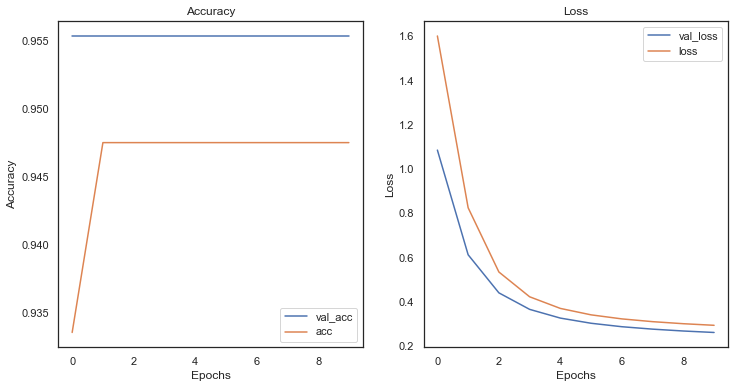

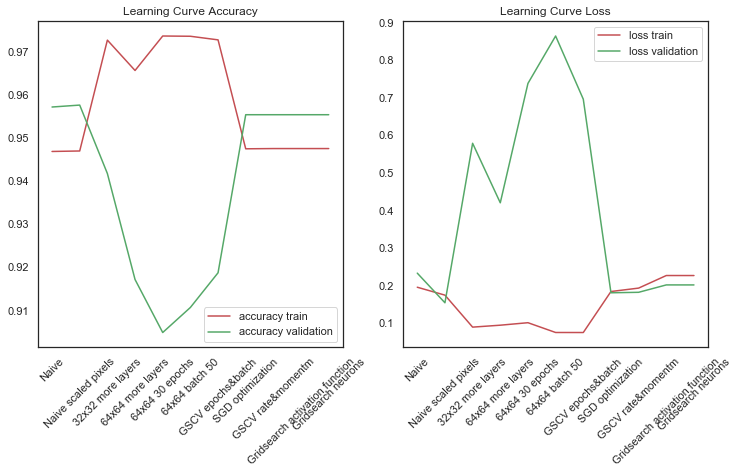

Name  \
0                           Naive   
0             Naive scaled pixels   
0               32x32 more layers   
0               64x64 more layers   
0                 64x64 30 epochs   
0                  64x64 batch 50   
0               GSCV epochs&batch   
0                SGD optimization   
0               GSCV rate&momentm   
0  Gridsearch activation function   
0              Gridsearch neurons   

                                               model  accuracy train  \
0  <tensorflow.python.keras.engine.sequential.Seq...        0.946848   
0  <tensorflow.python.keras.engine.sequential.Seq...        0.946960   
0  <tensorflow.python.keras.engine.sequential.Seq...        0.972640   
0  <tensorflow.python.keras.engine.sequential.Seq...        0.965606   
0                                                NaN        0.973590   
0                                                NaN        0.973532   
0                                                NaN        0.972697   
0                                                NaN        0.947464   
0                                                NaN        0.947520   
0                                                NaN        0.947520   
0                                                NaN        0.947520   

   accuracy validation  loss train  loss validation  
0             0.957144    0.195675         0.233176  
0             0.957590    0.174592         0.154246  
0             0.941741    0.089378         0.579092  
0             0.917188    0.094529         0.420537  
0             0.904911    0.101146         0.738544  
0             0.910714    0.075095         0.864797  
0             0.918750    0.075013         0.696519  
0             0.955360    0.184236         0.180860  
0             0.955360    0.193331         0.182139  
0             0.955360    0.226823         0.201814  
0             0.955360    0.226787         0.201784

In [116]:
#storing our results in the dataframe and viewing
df=model_results(model_g, history10, 'Gridsearch neurons', df)
df

> all the same, slightly higher loss for both 

## Tuning

Now that we selected all the best parameters for our model, there is some more tuning that we can do in particular to make sure that our model will not overfit the data.
This is achieved with regularization and dropout layers.

### Regularization

Regularization is commonly used when the model is overfitting the data.
<br>The main idea of regularization therefore is to penalize in some way a model that is too complex, that will tend to overfit the data.
<br>L1 regularization just adds one parameter, is not commonly used in Neural Networks.
<br>L2 on the other hand, also called "weight decay", makes the weights smaller, penalizing especially the largest weights, in a way forcing the model to be simplified.
<br>Now we are going to redefine the model adding the regularization term, L2:

In [117]:
model_h = models.Sequential()
model_h.add(layers.Conv2D(best_neurons, (3, 3), activation='softmax'))
model_h.add(layers.MaxPooling2D((2, 2)))
    
model_h.add(layers.Conv2D(best_neurons, (4, 4), activation='softmax'
                         ,kernel_regularizer=regularizers.L2(l2=0.05)))
model_h.add(layers.MaxPooling2D((2, 2)))
model_h.add(layers.Conv2D(best_neurons, (3, 3), activation='softmax'
                          ,kernel_regularizer=regularizers.L2(l2=0.05)))
model_h.add(layers.MaxPooling2D((2, 2)))

model_h.add(layers.Flatten())
model_h.add(layers.Dense(32, activation='softmax' 
                       ,kernel_regularizer=regularizers.L2(l2=0.05)))
model_h.add(layers.Dense(9, activation='softmax'))

# Compile model
model_h.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizer,
              metrics=['acc'])


Again fitting the model and saving the results:

In [118]:
history11 = fit_model(model_h, train_img64,train_y, epo=best_epochs,batch=best_batch)

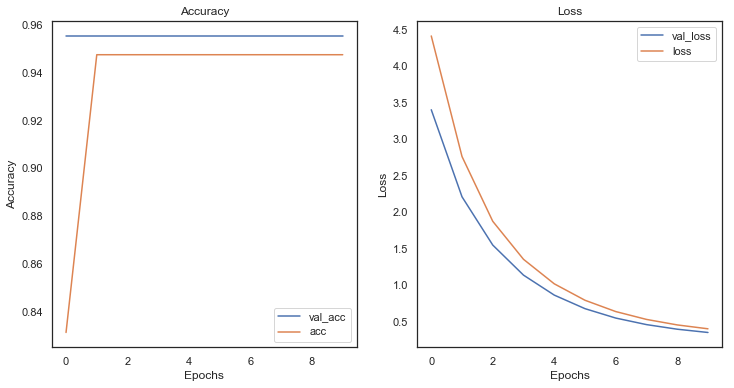

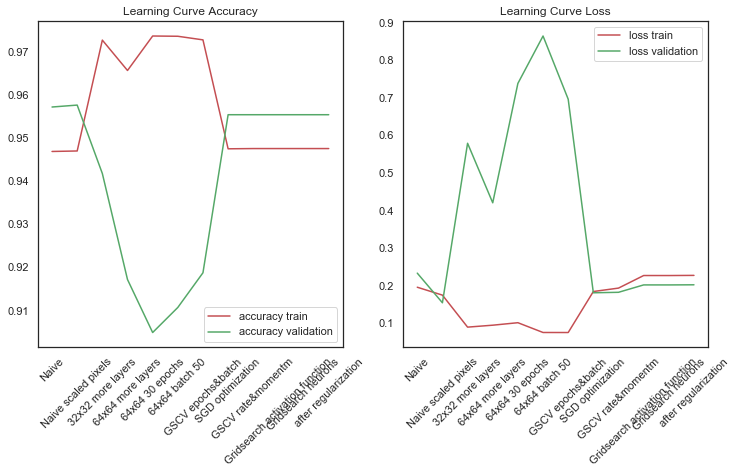

Name  \
0                           Naive   
0             Naive scaled pixels   
0               32x32 more layers   
0               64x64 more layers   
0                 64x64 30 epochs   
0                  64x64 batch 50   
0               GSCV epochs&batch   
0                SGD optimization   
0               GSCV rate&momentm   
0  Gridsearch activation function   
0              Gridsearch neurons   
0            after regularization   

                                               model  accuracy train  \
0  <tensorflow.python.keras.engine.sequential.Seq...        0.946848   
0  <tensorflow.python.keras.engine.sequential.Seq...        0.946960   
0  <tensorflow.python.keras.engine.sequential.Seq...        0.972640   
0  <tensorflow.python.keras.engine.sequential.Seq...        0.965606   
0                                                NaN        0.973590   
0                                                NaN        0.973532   
0                                                NaN        0.972697   
0                                                NaN        0.947464   
0                                                NaN        0.947520   
0                                                NaN        0.947520   
0                                                NaN        0.947520   
0                                                NaN        0.947520   

   accuracy validation  loss train  loss validation  
0             0.957144    0.195675         0.233176  
0             0.957590    0.174592         0.154246  
0             0.941741    0.089378         0.579092  
0             0.917188    0.094529         0.420537  
0             0.904911    0.101146         0.738544  
0             0.910714    0.075095         0.864797  
0             0.918750    0.075013         0.696519  
0             0.955360    0.184236         0.180860  
0             0.955360    0.193331         0.182139  
0             0.955360    0.226823         0.201814  
0             0.955360    0.226787         0.201784  
0             0.955360    0.227190         0.202135

In [119]:
df=model_results(model_h, history11, 'after regularization', df)
df

> same

We tried also regularization parameters L2=0.005, L2=0.01, but the best value turned out to be L2=0.05, and we have not included the other ones for brevity.

### Dropout Regularization

Dropout regularization is another technique used to avoid the model overfitting the training data, and performing poorly on new data.
<br>The main idea is that the model should not rely heavily on any specific part of the data, because it could become oversensitive not to real trends and characteristic of the data, but to its noise.
<br>This is achieved with dropout layers, which force the model to block out some nodes, by setting their weights to zero.
<br>The shut off neurons force the model to learn using other neurons and other paths, for the model to not rely heavily on certain paths.
<br>We can set the dropout rate, which specifies the fraction of units to stop. It is usually between 0.2 and 0.5. We are going to run a grid search for this as well, to find the best rate, spanning the values [0.0, 0.3, 0.5, 0.7, 0.9].
<br>Another parameter that we can set is the weight constraint. This can be set so that the magnitude of all the weights in a layer have to be below the set value, it has the same principle of avoiding the model to rely strongly on certain parts of the network versus others.
<br>The weight constraint we are going to input in our Grid Search are: [1.0, 2.0, 3.0, 4.0, 5.0]


In [120]:
# Function to create model, required for KerasClassifier
def create_model_drop(dropout_rate, weight_constraint):

    model = models.Sequential()
    model.add(layers.Conv2D(best_neurons, (3, 3), activation='softmax',
                        input_shape=(64, 64, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    
# First Dropout layer 
#    model.add(layers.Dropout(dropout_rate)    
    model.add(layers.Conv2D(best_neurons, (4, 4), activation='softmax',
                         kernel_regularizer=regularizers.L2(l2=0.05), 
                          kernel_constraint=MaxNorm(weight_constraint)))
    model.add(layers.MaxPooling2D((2, 2)))
              
# Second Dropout layer 
    model.add(layers.Dropout(dropout_rate))
            

    model.add(layers.Conv2D(best_neurons, (3, 3), activation='softmax', 
                        kernel_regularizer=regularizers.L2(l2=0.05), 
                          kernel_constraint=MaxNorm(weight_constraint)))
    model.add(layers.MaxPooling2D((2, 2))) 
              
# Third Dropout layer 
    model.add(layers.Dropout(dropout_rate))            

    model.add(layers.Flatten())
    model.add(layers.Dense(32, activation='softmax', 
                       kernel_regularizer=regularizers.L2(l2=0.05)))
              
# Fourth Dropout layer 
    model.add(layers.Dropout(dropout_rate))               
              
    model.add(layers.Dense(9, activation='softmax'))

# Compile model
    model.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizer,
              metrics=['acc'])
    return model

In [121]:
"""
# create model
model = KerasClassifier(model=create_model_drop, epochs=30, batch_size=20)
# define the grid search parameters
weight_constraint = [1.0, 2.0, 3.0, 4.0, 5.0]
#dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
dropout_rate = [0.0, 0.3, 0.5, 0.7, 0.9]
param_grid = dict(model__dropout_rate=dropout_rate, 
                  model__weight_constraint=weight_constraint)
#param_grid = dict(model__dropout_rate=dropout_rate)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X, Y)
"""

'\n# create model\nmodel = KerasClassifier(model=create_model_drop, epochs=30, batch_size=20)\n# define the grid search parameters\nweight_constraint = [1.0, 2.0, 3.0, 4.0, 5.0]\n#dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]\ndropout_rate = [0.0, 0.3, 0.5, 0.7, 0.9]\nparam_grid = dict(model__dropout_rate=dropout_rate, \n                  model__weight_constraint=weight_constraint)\n#param_grid = dict(model__dropout_rate=dropout_rate)\ngrid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)\ngrid_result = grid.fit(X, Y)\n'

In [122]:
"""
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))#    
    """

'\n# summarize results\nprint("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))\nmeans = grid_result.cv_results_[\'mean_test_score\']\nstds = grid_result.cv_results_[\'std_test_score\']\nparams = grid_result.cv_results_[\'params\']\nfor mean, stdev, param in zip(means, stds, params):\n    print("%f (%f) with: %r" % (mean, stdev, param))#    \n    '

In [123]:
#best_params=grid_result.best_params_
#best_params

In [124]:
#best_drop=best_params['model__dropout_rate']
#best_drop

In [125]:
best_drop=0.5

In [126]:
#best_weight_const=best_params['model__weight_constraint']

In [127]:
best_weight_const=3.0

Now that it is clear from the grid search what is the best drop out rate let us create our model with it and see the results in comparison to the other models.

In [128]:
model_i = models.Sequential()
model_i.add(layers.Conv2D(best_neurons, (3, 3), activation='softmax',
                        input_shape=(64, 64, 3)))
model_i.add(layers.MaxPooling2D((2, 2)))
    
model_i.add(layers.Conv2D(best_neurons, (4, 4), activation='softmax',
                         kernel_regularizer=regularizers.L2(l2=0.05), 
                          kernel_constraint=MaxNorm(best_weight_const)))
model_i.add(layers.MaxPooling2D((2, 2)))
# Implement dropout to the first hidden layer 
model_i.add(layers.Dropout(best_drop))
            
model_i.add(layers.Conv2D(best_neurons, (3, 3), activation='softmax', 
                        kernel_regularizer=regularizers.L2(l2=0.05), 
                          kernel_constraint=MaxNorm(best_weight_const)))
model_i.add(layers.MaxPooling2D((2, 2)))
            
# Implement dropout to the second hidden layer 
model_i.add(layers.Dropout(best_drop))            

model_i.add(layers.Flatten())
model_i.add(layers.Dense(32, activation='softmax', 
                       kernel_regularizer=regularizers.L2(l2=0.05)))
model_i.add(layers.Dense(9, activation='softmax'))

# Compile model
model_i.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizer,
              metrics=['acc'])

# Compile model
model_i.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizer,
              metrics=['acc'])
              

In [129]:
history12 = fit_model(model_i, train_img64,train_y,
                     epo=best_epochs,batch=best_batch)

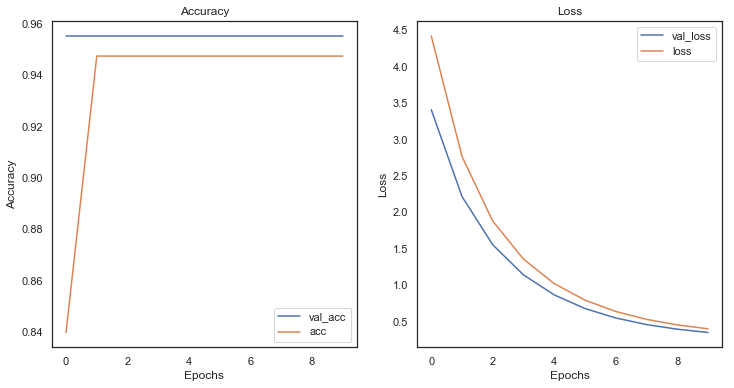

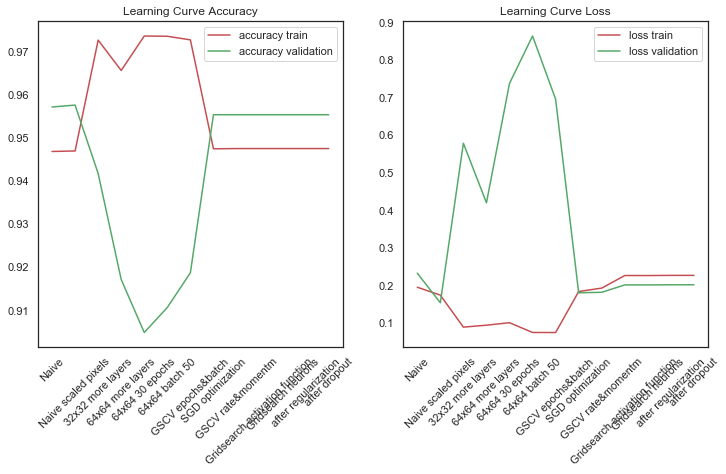

Name  \
0                           Naive   
0             Naive scaled pixels   
0               32x32 more layers   
0               64x64 more layers   
0                 64x64 30 epochs   
0                  64x64 batch 50   
0               GSCV epochs&batch   
0                SGD optimization   
0               GSCV rate&momentm   
0  Gridsearch activation function   
0              Gridsearch neurons   
0            after regularization   
0                   after dropout   

                                               model  accuracy train  \
0  <tensorflow.python.keras.engine.sequential.Seq...        0.946848   
0  <tensorflow.python.keras.engine.sequential.Seq...        0.946960   
0  <tensorflow.python.keras.engine.sequential.Seq...        0.972640   
0  <tensorflow.python.keras.engine.sequential.Seq...        0.965606   
0                                                NaN        0.973590   
0                                                NaN        0.973532   
0                                                NaN        0.972697   
0                                                NaN        0.947464   
0                                                NaN        0.947520   
0                                                NaN        0.947520   
0                                                NaN        0.947520   
0                                                NaN        0.947520   
0                                                NaN        0.947520   

   accuracy validation  loss train  loss validation  
0             0.957144    0.195675         0.233176  
0             0.957590    0.174592         0.154246  
0             0.941741    0.089378         0.579092  
0             0.917188    0.094529         0.420537  
0             0.904911    0.101146         0.738544  
0             0.910714    0.075095         0.864797  
0             0.918750    0.075013         0.696519  
0             0.955360    0.184236         0.180860  
0             0.955360    0.193331         0.182139  
0             0.955360    0.226823         0.201814  
0             0.955360    0.226787         0.201784  
0             0.955360    0.227190         0.202135  
0             0.955360    0.227208         0.202156

In [130]:
df=model_results(model_i, history12, 'after dropout', df)
df

> same

### Best model

> This final i model, explain a bit your choice.

### Evaluate the model:

To evaluate the train we will calculate the loss and accuracy, both on the train and on the test set, which so far we haven't touched, it is therefore unseen data.

#### On the train:

In [131]:
train_loss, train_acc = model_i.evaluate(train_img64, train_y)

print('Train Loss:', train_loss, '\nTrain Accuracy:', train_acc)

70/70 [==============================] - 2s 27ms/step - loss: 0.2098 - acc: 0.9491
Train Loss: 0.20982049405574799 
Train Accuracy: 0.9490844011306763


#### On the test:

In [132]:
test_loss, test_acc= model_i.evaluate(test_img64, test_y)

print('Test Loss:', test_loss, '\nTest Accuracy:', test_acc)

4/4 [==============================] - 0s 26ms/step - loss: 0.4624 - acc: 0.8644
Test Loss: 0.46237847208976746 
Test Accuracy: 0.8644067645072937


#### Doing it again with 256x256 images:

In [502]:
#normalizing again
train_images_fs /= 255.
test_images_fs /= 255.

In [503]:
"""
#Creating same model but with input shape 256x256
model_j = models.Sequential()
model_j.add(layers.Conv2D(best_neurons, (3, 3), activation='softmax',
                        input_shape=(256, 256, 3)))
model_j.add(layers.MaxPooling2D((2, 2)))
    
model_j.add(layers.Conv2D(best_neurons, (4, 4), activation='softmax',
                         kernel_regularizer=regularizers.L2(l2=0.05), 
                          kernel_constraint=MaxNorm(best_weight_const)))
model_j.add(layers.MaxPooling2D((2, 2)))
# Implement dropout to the first hidden layer 
model_j.add(layers.Dropout(best_drop))
            
model_j.add(layers.Conv2D(best_neurons, (3, 3), activation='softmax', 
                        kernel_regularizer=regularizers.L2(l2=0.05), 
                          kernel_constraint=MaxNorm(best_weight_const)))
model_j.add(layers.MaxPooling2D((2, 2)))
            
# Implement dropout to the second hidden layer 
model_j.add(layers.Dropout(best_drop))            

model_j.add(layers.Flatten())
model_j.add(layers.Dense(32, activation='softmax', 
                       kernel_regularizer=regularizers.L2(l2=0.05)))
model_j.add(layers.Dense(9, activation='softmax'))

# Compile model
model_j.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizer,
              metrics=['acc'])
#              """

In [504]:
# takes a long time!
#model_j.fit(train_images_fs, train_y,  epochs=best_epochs,
#                batch_size=best_batch)

Epoch 1/50
23/23 [==============================] - 97s 4s/step - loss: 5.8206 - acc: 0.2974
Epoch 2/50
23/23 [==============================] - 82s 4s/step - loss: 5.4974 - acc: 0.9538
Epoch 3/50
23/23 [==============================] - 71s 3s/step - loss: 5.0920 - acc: 0.9444
Epoch 4/50
23/23 [==============================] - 67s 3s/step - loss: 4.6654 - acc: 0.9535
Epoch 5/50
23/23 [==============================] - 71s 3s/step - loss: 4.2977 - acc: 0.9489
Epoch 6/50
23/23 [==============================] - 79s 3s/step - loss: 3.9766 - acc: 0.9516
Epoch 7/50
23/23 [==============================] - 74s 3s/step - loss: 3.7018 - acc: 0.9455
Epoch 8/50
23/23 [==============================] - 64s 3s/step - loss: 3.4420 - acc: 0.9540
Epoch 9/50
23/23 [==============================] - 66s 3s/step - loss: 3.2365 - acc: 0.9496
Epoch 10/50
23/23 [==============================] - 63s 3s/step - loss: 3.0453 - acc: 0.9521
Epoch 11/50
23/23 [==============================] - 65s 3s/step - lo

In [505]:
train_loss, train_acc = model_j.evaluate(train_images_fs, train_y)

print('Train Loss:', train_loss, '\nTrain Accuracy:', train_acc)

70/70 [==============================] - 24s 334ms/step - loss: 0.6497 - acc: 0.9491
Train Loss: 0.6496685147285461 
Train Accuracy: 0.9490844011306763


In [506]:
test_loss, test_acc= model_j.evaluate(test_images_fs, test_y)

print('Test Loss:', test_loss, '\nTest Accuracy:', test_acc)

4/4 [==============================] - 2s 339ms/step - loss: 0.9577 - acc: 0.8644
Test Loss: 0.9577001929283142 
Test Accuracy: 0.8644067645072937


# Changing to two classes: cancerous and bening

As we mentioned, we want to also create a second model, that simply returns the information if the skin growth is cancerous or benign, and we will add some more metrics that better describe this type of binary problem.
<br>First we will work on the data, creating a separate folder 'binary' in which we will store the images divided into 2 classes instead of 9, 'benign' and 'cancerous'.
<br>This folder will still have the same division into train and test that the original data has.
<br>Some of the code below is commented out as we wanted to create the directory and copy the images only once, and not every time that the notebook is compiled, but a user that would want to do the same can uncomment and proceed with the code as is to create the same directories and subfolders.

First we will do this process for the train set, and subsequently for the test.

#### Train Set:
Creating the current directories where we can find the images divided into 9 classes:

In [138]:
acti_dir = 'dataskin/Train/actinic keratosis'
basal_dir = 'dataskin/Train/basal cell carcinoma'
derma_dir = 'dataskin/Train/dermatofibroma'
mela_dir = 'dataskin/Train/melanoma'
nevus_dir = 'dataskin/Train/nevus'
pigm_dir = 'dataskin/Train/pigmented benign keratosis'
sebo_dir = 'dataskin/Train/seborrheic keratosis'
squa_dir = 'dataskin/Train/squamous cell carcinoma'
lesion_dir = 'dataskin/Train/vascular lesion'

Creating a new directory to store the images divided into only 2 classes:

In [139]:
new_dir = 'dataskin/binary/'

Extracting information about number of images in each directory:

In [140]:
imgs_acti = [file for file in os.listdir(acti_dir) if file.endswith('.jpg')]
print('There are', len(imgs_acti), 'images of actinic keratosis')
imgs_basal = [file for file in os.listdir(basal_dir) if file.endswith('.jpg')]
print('There are', len(imgs_basal), 'images of basal cell carcinoma')
imgs_mela = [file for file in os.listdir(mela_dir) if file.endswith('.jpg')]
print('There are', len(imgs_mela), 'images of melanoma')
imgs_squa = [file for file in os.listdir(squa_dir) if file.endswith('.jpg')]
print('There are', len(imgs_squa), 'images of squamous cell carcinoma')

imgs_derma = [file for file in os.listdir(derma_dir) if file.endswith('.jpg')]
print('There are', len(imgs_derma), 'images of dermatofibroma')
imgs_nevus = [file for file in os.listdir(nevus_dir) if file.endswith('.jpg')]
print('There are', len(imgs_nevus), 'images of nevus')
imgs_pigm = [file for file in os.listdir(pigm_dir) if file.endswith('.jpg')]
print('There are', len(imgs_pigm), 'images of pigmented benign keratosis')
imgs_sebo = [file for file in os.listdir(sebo_dir) if file.endswith('.jpg')]
print('There are', len(imgs_sebo), 'images of seborrheic keratosis')
imgs_lesion = [file for file in os.listdir(lesion_dir) if file.endswith('.jpg')]
print('There are', len(imgs_lesion), 'images of vascula lesion')

There are 114 images of actinic keratosis
There are 376 images of basal cell carcinoma
There are 438 images of melanoma
There are 181 images of squamous cell carcinoma
There are 95 images of dermatofibroma
There are 357 images of nevus
There are 462 images of pigmented benign keratosis
There are 77 images of seborrheic keratosis


Code to create the new folder "binary":

In [141]:
# Code to create the new folder 'binary'
#os.mkdir(new_dir)

Code to create paths to the subfolders:

In [142]:
""" Code to create paths to subfolders
train_folder = os.path.join(new_dir, 'train')
train_benign = os.path.join(train_folder, 'benign')
train_cancerous = os.path.join(train_folder, 'cancerous')

test_folder = os.path.join(new_dir, 'test')
test_benign = os.path.join(test_folder, 'benign')
test_cancerous = os.path.join(test_folder, 'cancerous')
"""

" Code to create paths to subfolders\ntrain_folder = os.path.join(new_dir, 'train')\ntrain_benign = os.path.join(train_folder, 'benign')\ntrain_cancerous = os.path.join(train_folder, 'cancerous')\n\ntest_folder = os.path.join(new_dir, 'test')\ntest_benign = os.path.join(test_folder, 'benign')\ntest_cancerous = os.path.join(test_folder, 'cancerous')\n"

Code to create the subfolders:

In [143]:
""" Code to create subfolders

os.mkdir(train_folder)
os.mkdir(train_benign)
os.mkdir(train_cancerous)

os.mkdir(test_folder)
os.mkdir(test_benign)
os.mkdir(test_cancerous)
"""

' Code to create subfolders\n\nos.mkdir(train_folder)\nos.mkdir(train_benign)\nos.mkdir(train_cancerous)\n\nos.mkdir(test_folder)\nos.mkdir(test_benign)\nos.mkdir(test_cancerous)\n'

We have to split the classes between benign and cancerous, so recall:
<br>Actinic keratosis, basal cell carcinoma, melanoma and squamous cell carcinoma are cancerous.
<br>Dermatofibroma, pigmented benign keratosis, nevus, seborrheic keratosis and vascular lesions are benign.
<br>As totals we except:

In [144]:
total_benign=len(imgs_derma)+len(imgs_nevus)+len(imgs_pigm)+len(imgs_sebo)+len(imgs_lesion)
total_cancerous=len(imgs_acti)+len(imgs_basal)+len(imgs_mela)+len(imgs_squa)
print(f'total bening {total_benign}, total cancerous {total_cancerous}')

total bening 1130, total cancerous 1109


As we can tell the number of images for cancerous and benign in the train set are similar, so we don't need to worry about a class imbalance in our case, but the code is also included on how to deal with class imbalance [here](#imbalance_cell)

Below is the code to copy images from the 5 benign classes into the new folder 'benign':

In [145]:
""" Code to copy images from 5 folders into new folder 'benign'
imgs = imgs_derma
for img in imgs:
    origin = os.path.join(derma_dir, img)
    destination = os.path.join(train_benign, img)
    shutil.copyfile(origin, destination)
imgs = imgs_nevus
for img in imgs:
    origin = os.path.join(nevus_dir, img)
    destination = os.path.join(train_benign, img)
    shutil.copyfile(origin, destination)
imgs = imgs_pigm
for img in imgs:
    origin = os.path.join(pigm_dir, img)
    destination = os.path.join(train_benign, img)
    shutil.copyfile(origin, destination)
imgs = imgs_sebo
for img in imgs:
    origin = os.path.join(sebo_dir, img)
    destination = os.path.join(train_benign, img)
    shutil.copyfile(origin, destination)
imgs = imgs_lesion
for img in imgs:
    origin = os.path.join(lesion_dir, img)
    destination = os.path.join(train_benign, img)
    shutil.copyfile(origin, destination)
    """ 

" Code to copy images from 5 folders into new folder 'benign'\nimgs = imgs_derma\nfor img in imgs:\n    origin = os.path.join(derma_dir, img)\n    destination = os.path.join(train_benign, img)\n    shutil.copyfile(origin, destination)\nimgs = imgs_nevus\nfor img in imgs:\n    origin = os.path.join(nevus_dir, img)\n    destination = os.path.join(train_benign, img)\n    shutil.copyfile(origin, destination)\nimgs = imgs_pigm\nfor img in imgs:\n    origin = os.path.join(pigm_dir, img)\n    destination = os.path.join(train_benign, img)\n    shutil.copyfile(origin, destination)\nimgs = imgs_sebo\nfor img in imgs:\n    origin = os.path.join(sebo_dir, img)\n    destination = os.path.join(train_benign, img)\n    shutil.copyfile(origin, destination)\nimgs = imgs_lesion\nfor img in imgs:\n    origin = os.path.join(lesion_dir, img)\n    destination = os.path.join(train_benign, img)\n    shutil.copyfile(origin, destination)\n    "

Checking the content of the 'benign' folder:

In [146]:
train_benign_dir = 'dataskin/binary/train/benign'

imgs_benign = [file for file in os.listdir(train_benign_dir) if file.endswith('.jpg')]
print('There are', len(imgs_benign), 'images in train benign')

There are 1130 images in train benign


Moving on to the cancerous class:
<br>copying the images form the 4 folders into the one 'cancerous' folder.

In [147]:
""" Code to copy images from 4 folders into new folder 'cancerous'
#train cancerous
imgs = imgs_acti
for img in imgs:
    origin = os.path.join(acti_dir, img)
    destination = os.path.join(train_cancerous, img)
    shutil.copyfile(origin, destination)
imgs = imgs_basal
for img in imgs:
    origin = os.path.join(basal_dir, img)
    destination = os.path.join(train_cancerous, img)
    shutil.copyfile(origin, destination)
imgs = imgs_mela
for img in imgs:
    origin = os.path.join(mela_dir, img)
    destination = os.path.join(train_cancerous, img)
    shutil.copyfile(origin, destination)
imgs = imgs_squa
for img in imgs:
    origin = os.path.join(squa_dir, img)
    destination = os.path.join(train_cancerous, img)
    shutil.copyfile(origin, destination)
    """

" Code to copy images from 4 folders into new folder 'cancerous'\n#train cancerous\nimgs = imgs_acti\nfor img in imgs:\n    origin = os.path.join(acti_dir, img)\n    destination = os.path.join(train_cancerous, img)\n    shutil.copyfile(origin, destination)\nimgs = imgs_basal\nfor img in imgs:\n    origin = os.path.join(basal_dir, img)\n    destination = os.path.join(train_cancerous, img)\n    shutil.copyfile(origin, destination)\nimgs = imgs_mela\nfor img in imgs:\n    origin = os.path.join(mela_dir, img)\n    destination = os.path.join(train_cancerous, img)\n    shutil.copyfile(origin, destination)\nimgs = imgs_squa\nfor img in imgs:\n    origin = os.path.join(squa_dir, img)\n    destination = os.path.join(train_cancerous, img)\n    shutil.copyfile(origin, destination)\n    "

Checking the content:

In [148]:
train_can_dir = 'dataskin/binary/train/cancerous'

imgs_canc = [file for file in os.listdir(train_can_dir) if file.endswith('.jpg')]
print('There are', len(imgs_canc), 'images in train cancerous')

There are 1109 images in train cancerous


### Test Set
Now we just need to repeat the same steps for the test.
Creating the directories of the original images:

In [149]:
acti_dir = 'dataskin/Test/actinic keratosis'
basal_dir = 'dataskin/Test/basal cell carcinoma'
derma_dir = 'dataskin/Test/dermatofibroma'
mela_dir = 'dataskin/Test/melanoma'
nevus_dir = 'dataskin/Test/nevus'
pigm_dir = 'dataskin/Test/pigmented benign keratosis'
sebo_dir = 'dataskin/Test/seborrheic keratosis'
squa_dir = 'dataskin/Test/squamous cell carcinoma'
lesion_dir = 'dataskin/Test/vascular lesion'

Checking the content:

In [150]:
imgs_acti = [file for file in os.listdir(acti_dir) if file.endswith('.jpg')]
print('There are', len(imgs_acti), 'images of actinic keratosis')
imgs_basal = [file for file in os.listdir(basal_dir) if file.endswith('.jpg')]
print('There are', len(imgs_basal), 'images of basal cell carcinoma')
imgs_mela = [file for file in os.listdir(mela_dir) if file.endswith('.jpg')]
print('There are', len(imgs_mela), 'images of melanoma')
imgs_squa = [file for file in os.listdir(squa_dir) if file.endswith('.jpg')]
print('There are', len(imgs_squa), 'images of squamous cell carcinoma')

imgs_derma = [file for file in os.listdir(derma_dir) if file.endswith('.jpg')]
print('There are', len(imgs_derma), 'images of dermatofibroma')
imgs_nevus = [file for file in os.listdir(nevus_dir) if file.endswith('.jpg')]
print('There are', len(imgs_nevus), 'images of nevus')
imgs_pigm = [file for file in os.listdir(pigm_dir) if file.endswith('.jpg')]
print('There are', len(imgs_pigm), 'images of pigmented benign keratosis')
imgs_sebo = [file for file in os.listdir(sebo_dir) if file.endswith('.jpg')]
print('There are', len(imgs_sebo), 'images of seborrheic keratosis')
imgs_lesion = [file for file in os.listdir(lesion_dir) if file.endswith('.jpg')]
print('There are', len(imgs_lesion), 'images of vascula lesion')

There are 16 images of actinic keratosis
There are 16 images of basal cell carcinoma
There are 16 images of melanoma
There are 16 images of squamous cell carcinoma
There are 16 images of dermatofibroma
There are 16 images of nevus
There are 16 images of pigmented benign keratosis
There are 3 images of seborrheic keratosis
There are 3 images of vascula lesion


Finding out total number of benign and cancerous images in the test set:

In [151]:
total_benign=len(imgs_derma)+len(imgs_nevus)+len(imgs_pigm)+len(imgs_sebo)+len(imgs_lesion)
total_cancerous=len(imgs_acti)+len(imgs_basal)+len(imgs_mela)+len(imgs_squa)
print(f'total bening {total_benign}, total cancerous {total_cancerous}')

total bening 54, total cancerous 64


As we can see again the classes are pretty well balanced.
Next we will copy the images from the original 9 classes folders into the 'benign' folder for the test set.

In [152]:
""" Code to copy images from 5 folders into new folder 'benign'
# test benign
imgs = imgs_derma
for img in imgs:
    origin = os.path.join(derma_dir, img)
    destination = os.path.join(test_benign, img)
    shutil.copyfile(origin, destination)
imgs = imgs_nevus
for img in imgs:
    origin = os.path.join(nevus_dir, img)
    destination = os.path.join(test_benign, img)
    shutil.copyfile(origin, destination)
imgs = imgs_pigm
for img in imgs:
    origin = os.path.join(pigm_dir, img)
    destination = os.path.join(test_benign, img)
    shutil.copyfile(origin, destination)
imgs = imgs_sebo
for img in imgs:
    origin = os.path.join(sebo_dir, img)
    destination = os.path.join(test_benign, img)
    shutil.copyfile(origin, destination)
imgs = imgs_lesion
for img in imgs:
    origin = os.path.join(lesion_dir, img)
    destination = os.path.join(test_benign, img)
    shutil.copyfile(origin, destination)
    """

" Code to copy images from 5 folders into new folder 'benign'\n# test benign\nimgs = imgs_derma\nfor img in imgs:\n    origin = os.path.join(derma_dir, img)\n    destination = os.path.join(test_benign, img)\n    shutil.copyfile(origin, destination)\nimgs = imgs_nevus\nfor img in imgs:\n    origin = os.path.join(nevus_dir, img)\n    destination = os.path.join(test_benign, img)\n    shutil.copyfile(origin, destination)\nimgs = imgs_pigm\nfor img in imgs:\n    origin = os.path.join(pigm_dir, img)\n    destination = os.path.join(test_benign, img)\n    shutil.copyfile(origin, destination)\nimgs = imgs_sebo\nfor img in imgs:\n    origin = os.path.join(sebo_dir, img)\n    destination = os.path.join(test_benign, img)\n    shutil.copyfile(origin, destination)\nimgs = imgs_lesion\nfor img in imgs:\n    origin = os.path.join(lesion_dir, img)\n    destination = os.path.join(test_benign, img)\n    shutil.copyfile(origin, destination)\n    "

Checking the content

In [153]:
test_benign_dir = 'dataskin/binary/test/benign'

imgs_test = [file for file in os.listdir(test_benign_dir) if file.endswith('.jpg')]
print('There are', len(imgs_test), 'images in test benign')

There are 54 images in test benign


Copying the images into the 'cancerous' folder for the test set.

In [154]:
""" Code to copy images from 4 folders into new folder 'cancerous'
#test cancerous
imgs = imgs_acti
for img in imgs:
    origin = os.path.join(acti_dir, img)
    destination = os.path.join(test_cancerous, img)
    shutil.copyfile(origin, destination)
imgs = imgs_basal
for img in imgs:
    origin = os.path.join(basal_dir, img)
    destination = os.path.join(test_cancerous, img)
    shutil.copyfile(origin, destination)
imgs = imgs_mela
for img in imgs:
    origin = os.path.join(mela_dir, img)
    destination = os.path.join(test_cancerous, img)
    shutil.copyfile(origin, destination)
imgs = imgs_squa
for img in imgs:
    origin = os.path.join(squa_dir, img)
    destination = os.path.join(test_cancerous, img)
    shutil.copyfile(origin, destination)
"""

" Code to copy images from 4 folders into new folder 'cancerous'\n#test cancerous\nimgs = imgs_acti\nfor img in imgs:\n    origin = os.path.join(acti_dir, img)\n    destination = os.path.join(test_cancerous, img)\n    shutil.copyfile(origin, destination)\nimgs = imgs_basal\nfor img in imgs:\n    origin = os.path.join(basal_dir, img)\n    destination = os.path.join(test_cancerous, img)\n    shutil.copyfile(origin, destination)\nimgs = imgs_mela\nfor img in imgs:\n    origin = os.path.join(mela_dir, img)\n    destination = os.path.join(test_cancerous, img)\n    shutil.copyfile(origin, destination)\nimgs = imgs_squa\nfor img in imgs:\n    origin = os.path.join(squa_dir, img)\n    destination = os.path.join(test_cancerous, img)\n    shutil.copyfile(origin, destination)\n"

Checking the content:

In [155]:
test_can_dir = 'dataskin/binary/test/cancerous'

imgs_acti = [file for file in os.listdir(test_can_dir) if file.endswith('.jpg')]
print('There are', len(imgs_acti), 'images in test cancerous')

There are 64 images in test cancerous


#### In the case of class imbalance:
<a id='imbalance_cell'></a>

If there was an imbalance between the classes we could balance them using augmentation, which consists in generating more data from the images we already have.
<br>If for example we had many more images of benign growths, we could generate more images form the ones we have of cancerous growths.
<br>This technique allows to rotate, shift, zoom and flip an image, to generate a slightly different one form the original, to be included in the data used to train our model.
<br>We include here the code to do so, if a user wanted to try this out, especially if, using a different dataset that was to be imbalanced, one wanted to balance it out.

In [156]:
"""
# If there is an imbalance re balance the classes with augmentation
train_datagen = ImageDataGenerator(rescale=1./255, 
                                   rotation_range=40, 
                                   width_shift_range=0.2, 
                                   height_shift_range=0.2, 
                                   shear_range=0.3, 
                                   zoom_range=0.1, 
                                   horizontal_flip=True)

#to preview an example
names = [os.path.join(train_benign, name) for name in os.listdir(train_benign)]
img_path = names[91]
img = load_img(img_path, target_size=(64, 64))

reshape_img = img_to_array(img) 
reshape_img = reshape_img.reshape((1,) + reshape_img.shape) 
i=0
for batch in train_datagen.flow(reshape_img, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(array_to_img(batch[0]))
    i += 1
    if i % 3 == 0:
        break
plt.show()
"""

'\n# If there is an imbalance re balance the classes with augmentation\ntrain_datagen = ImageDataGenerator(rescale=1./255, \n                                   rotation_range=40, \n                                   width_shift_range=0.2, \n                                   height_shift_range=0.2, \n                                   shear_range=0.3, \n                                   zoom_range=0.1, \n                                   horizontal_flip=True)\n\n#to preview an example\nnames = [os.path.join(train_benign, name) for name in os.listdir(train_benign)]\nimg_path = names[91]\nimg = load_img(img_path, target_size=(64, 64))\n\nreshape_img = img_to_array(img) \nreshape_img = reshape_img.reshape((1,) + reshape_img.shape) \ni=0\nfor batch in train_datagen.flow(reshape_img, batch_size=1):\n    plt.figure(i)\n    imgplot = plt.imshow(array_to_img(batch[0]))\n    i += 1\n    if i % 3 == 0:\n        break\nplt.show()\n'

### Importing again images, divided in two classes instead of 9:
We will import the images in the 64x64 size for both train and test:

In [257]:
# Directory path
train_data_dir = 'dataskin/binary/train'
test_data_dir = 'dataskin/binary/test'

# Get all the data in the directory data/validation (118 images), and reshape them
test_gen= ImageDataGenerator().flow_from_directory(
        test_data_dir, target_size=(64, 64), batch_size=118)

# Get all the data in the directory data/train (2239 images), and reshape them
train_gen = ImageDataGenerator().flow_from_directory(
        train_data_dir, target_size=(64, 64), batch_size=2239)

# Create the datasets
train_img_bin, train_lab_bin = next(train_gen)
test_img_bin, test_lab_bin = next(test_gen)

train_img_bin /= 255.
test_img_bin /= 255.

Found 118 images belonging to 2 classes.
Found 2239 images belonging to 2 classes.


Let us look at the class indexes:

In [258]:
train_gen.class_indices 

{'benign': 0, 'cancerous': 1}

Exploring the dataset:

In [259]:
# Explore your dataset again
m_train = train_img_bin.shape[0]
num_px = train_img_bin.shape[1]
m_test = test_img_bin.shape[0]

print ("Number of training samples: " + str(m_train))
print ("Number of testing samples: " + str(m_test))
print ("train_images shape: " + str(train_img_bin.shape))
print ("train_labels shape: " + str(train_lab_bin.shape))
print ("test_images shape: " + str(test_img_bin.shape))
print ("test_labels shape: " + str(test_lab_bin.shape))

Number of training samples: 2239
Number of testing samples: 118
train_images shape: (2239, 64, 64, 3)
train_labels shape: (2239, 2)
test_images shape: (118, 64, 64, 3)
test_labels shape: (118, 2)


Reshape the train and test labels:

In [260]:
train_y_bin = np.reshape(train_lab_bin[:,0], (2239,1))
test_y_bin = np.reshape(test_lab_bin[:,0], (118,1))

### New Metrics: Recall and F1 score

Now that we have defined the problem in a different way, having two classes and therefore making it a binary problem, we can define and use different metrics to evaluate our models.
<br>In particular a metric that is very widely used in the medical field is recall, which tells us what percentage of the classes we are interested in were actually captured by the model.
<br>It is calculated as number of true positives identified by the model (true positive means the sample belonged to a class and we identified it correctly as belonging to that class) divided by the number of actual total positives (all the samples belonging to that class). <br>It gives us a sense of how many cases we identified correctly in a class compared to the total of that class.
<br>What brings down the recall is the number of positives that were not identified, called false negatives. In our case it would be when a skin anomaly was classified as benign, when it is actually cancerous.
<br>We want to obviously minimize these instances, even if it means the overall precision of the model is lower, we would rather identify more cancerous cases (even if some will turn out to be actually benign) rather than the other way around, since the risk is leaving untreated a patient that has a cancerous skin growth.
<br>At the same time we do not want our model to become overall very imprecise, the risk with high recall for the model is to identify all the cases as cancerous, which would leave us with no false negatives but with also very little accuracy of the model overall. This is when another metric, F1, comes in handy.
<br>F1 is the harmonic mean of precision and recall.
<br>We will keep an eye on F1 which gives us an overall sense of the performance of the model (to make sure we are not getting an amazing recall while all the other metrics are plummeting) and we will keep looking at accuracy and loss as we have done before.

Let us define a few new functions to introduce these metrics and keep track of them:
First a function to calculate recall and f1, fitting and predicting with the same model 10 times and taking the mean of the recall and f1.

In [717]:
def calculate_metrics(model, trainX=train_img_bin, trainy=train_y_bin, epochs=10, batch=30):
    seed = 42
    tf.random.set_seed(seed)
    recs=[]
    f1s=[]
    for i in range(10):
        fit_model(model, trainX, trainy, epo=epochs, batch=batch)
    # predict probabilities
        y_pred_prob = model.predict(trainX, verbose=0)
    # predict classes
        y_pred_clas = (model.predict(trainX) > 0.5).astype("float")
#        y_pred_clas = np.argmax(y_pred_prob,axis=1)
#    y_pred_clas =np.round(y_pred_prob).astype(int)
    # reduce to 1d array
        y_pred_prob = y_pred_prob[:, 0]
#        y_pred_clas = y_pred_clas[:, 0]
        recall = recall_score(trainy, y_pred_clas)
        f1 = f1_score(trainy, y_pred_clas)
        recs.append(recall)
        f1s.append(f1)
#        print (trainy)
#        print (y_pred_clas)
        i+=1
    recall_mean=np.mean(recs)
    f1_mean=np.mean(f1s)
        
    return recall_mean, f1_mean#, trainy, y_pred_clas

Function to plot the confusion matrix, which shows us visually how many True positives and True Negatives ( bottom right corner and top left corner) the model identified.
<br>It gives us also a sense of the cases that the model got wrong, plotting the false negatives on the bottom left, and the false positives on the top right.

In [718]:
def conf_matrix(model, trainX=train_img_bin, trainy=train_y_bin):
    seed = 42
    tf.random.set_seed(seed)
    y_pred_prob = model.predict(trainX, verbose=0)
    # predict classes
#    y_pred_clas = (model.predict(trainX) > 0.5).astype("int32")
    y_pred_clas = (model.predict(trainX) > 0.5).astype("float")
#    y_pred_clas =np.round(y_pred_prob).astype(int)
    # confusion matrix
    cnm = confusion_matrix(trainy, y_pred_clas)
    # To Normalize
    cnm = cnm.astype('float') / cnm.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots(figsize=(4,3))
    sns.heatmap(cnm, annot=True, fmt='.2f', cmap="Greens")
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show(block=False)

A function similar to the one we defined before, it will plot the history of accuracy and loss of the model. Under that it will plot the learning curve for accuracy and loss, as we had before to track the progress as we tune our model.
And lastly it will plot the learning curve of recall and f1 score, just like for the accuracy and loss, to be able to see how our models are doing in terms of those metric, every time that we change some of the parameters.

In [719]:
def model_results_bin(model, results, model_name, df, 
                      trainX=train_img_bin, trainy=train_y_bin):
    visualize_training_results(results)
    recall, f1=calculate_metrics(model, trainX, trainy)
    df1 = pd.DataFrame({'Name': [model_name], 
                        'model':[model],
        'accuracy train': [round(results.history['acc'][-1],5)] ,
        'accuracy validation': [round(results.history['val_acc'][-1],5 )],
        'loss train': [round(results.history['loss'][-1],5)],
        'loss validation': [round(results.history['val_loss'][-1],5)],
        'recall': [recall] ,
        'f1': [f1]                      
                       })
    df=df.append(df1)
    fig = plt.subplots(figsize=(12,6))
    
    plt.subplot(1,2,1)
    x=df['Name']
    y=df['accuracy train']
    plt.plot(x, y, color='r')
    x1=df['Name']
    y1=df['accuracy validation']
    plt.plot(x1, y1, color='g')
    plt.xticks(x, labels=df['Name'], rotation='vertical')
    plt.title('Learning Curve Accuracy')
    plt.legend()
 
    plt.subplot(1,2,2)
    x=df['Name']
    y=df['loss train']
    plt.plot(x, y, color='r')
    x1=df['Name']
    y1=df['loss validation']
    plt.plot(x1, y1, color='g')
    plt.xticks(x, labels=df['Name'], rotation='vertical')
    plt.title('Learning Curve Loss')
    plt.legend()
    plt.show()
    
    fig = plt.subplots(figsize=(12,6))
    
    plt.subplot(1,2,1)
    x=df['Name']
    y=df['recall']
    plt.plot(x, y, color='cyan')
    plt.xticks(x, labels=df['Name'], rotation='vertical')
    plt.title('Learning Curve Recall')
    plt.legend()
 
    plt.subplot(1,2,2)
    x=df['Name']
    y=df['f1']
    plt.plot(x, y, color='purple')
    plt.xticks(x, labels=df['Name'], rotation='vertical')
    plt.title('Learning Curve F1')
    plt.legend()

    plt.show()
    
    return df

#### Naive Model:

In [720]:
naive_model = models.Sequential()
naive_model.add(layers.Conv2D(3, (3, 3), activation='sigmoid',
                        input_shape=(64 ,64,  3)))
naive_model.add(layers.MaxPooling2D((2, 2)))

naive_model.add(layers.Flatten())
naive_model.add(layers.Dense(1, activation='sigmoid'))

naive_model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])

In [721]:
df=pd.DataFrame()

In [722]:
naive_hist = fit_model(naive_model, train_img_bin, train_y_bin , val_split=0.3, verbose=1)

Epoch 1/15
53/53 [==============================] - 3s 35ms/step - loss: 0.7391 - acc: 0.5097 - val_loss: 0.7399 - val_acc: 0.4762
Epoch 2/15
53/53 [==============================] - 2s 32ms/step - loss: 0.7252 - acc: 0.4937 - val_loss: 0.6936 - val_acc: 0.5238
Epoch 3/15
53/53 [==============================] - 2s 33ms/step - loss: 0.7044 - acc: 0.4982 - val_loss: 0.6940 - val_acc: 0.5238
Epoch 4/15
53/53 [==============================] - 2s 33ms/step - loss: 0.7052 - acc: 0.5396 - val_loss: 0.6909 - val_acc: 0.5238
Epoch 5/15
53/53 [==============================] - 2s 32ms/step - loss: 0.6927 - acc: 0.5191 - val_loss: 0.6858 - val_acc: 0.5610
Epoch 6/15
53/53 [==============================] - 2s 31ms/step - loss: 0.6816 - acc: 0.5676 - val_loss: 0.6843 - val_acc: 0.5595
Epoch 7/15
53/53 [==============================] - 2s 33ms/step - loss: 0.6800 - acc: 0.5624 - val_loss: 0.6745 - val_acc: 0.5908
Epoch 8/15
53/53 [==============================] - 2s 32ms/step - loss: 0.6773 - a

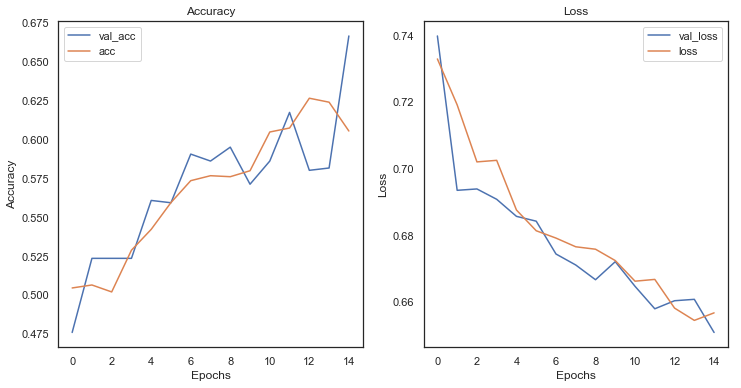

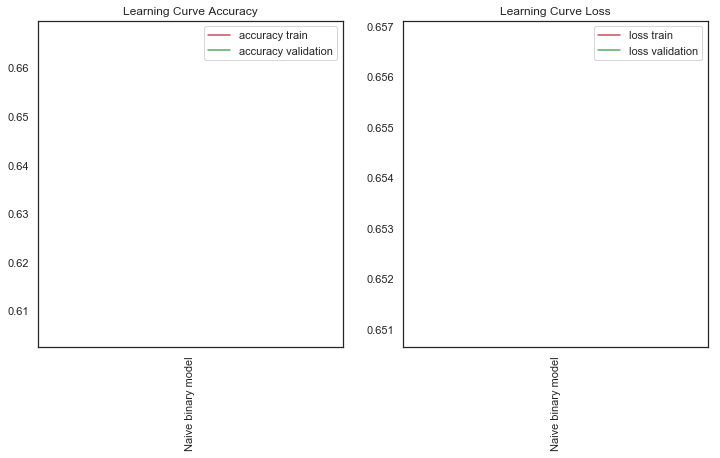

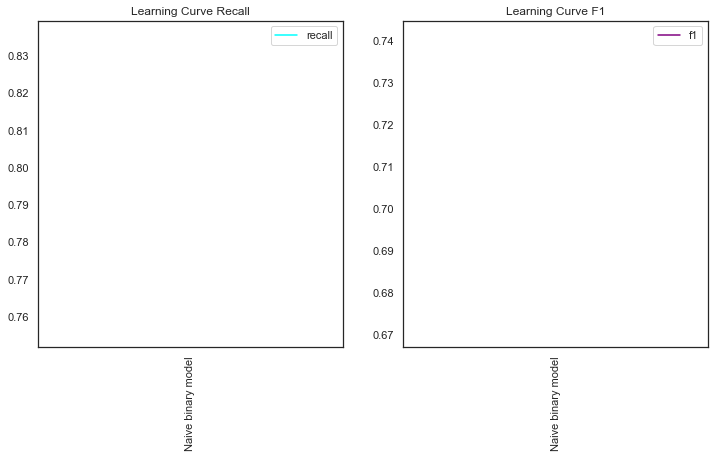

Name                                              model  \
0  Naive binary model  <tensorflow.python.keras.engine.sequential.Seq...   

   accuracy train  accuracy validation  loss train  loss validation    recall  \
0         0.60562              0.66667     0.65682          0.65094  0.795575   

         f1  
0  0.705977

In [723]:
df=model_results_bin(results=naive_hist, model_name='Naive binary model', df=df, 
                     model=naive_model)
df

### Improving the model:

Redefining `create_model` for the binary case.

In [724]:
def create_model_bin(input_shape=(64, 64, 3), activation='relu', metrics=['acc'],
                optimizer='adam', neur1=10, neur2=20):
 # create model
    model = models.Sequential()
    model.add(layers.Conv2D(neur1, (3, 3), activation=activation,
                        input_shape=input_shape))
    model.add(layers.MaxPooling2D((2,2)))
    
    model.add(layers.Conv2D(neur1, (4, 4), activation=activation))
    model.add(layers.MaxPooling2D((2,2)))

    model.add(layers.Conv2D(neur2, (3, 3), activation=activation))
    model.add(layers.MaxPooling2D((2,2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(32, activation=activation))
    model.add(layers.Dense(1, activation=activation))

# Compile model
    model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=metrics)
    return model

In [725]:
model_bina=create_model_bin()

In [726]:
hist_bin1=fit_model(model_bina, train_img_bin, train_y_bin)

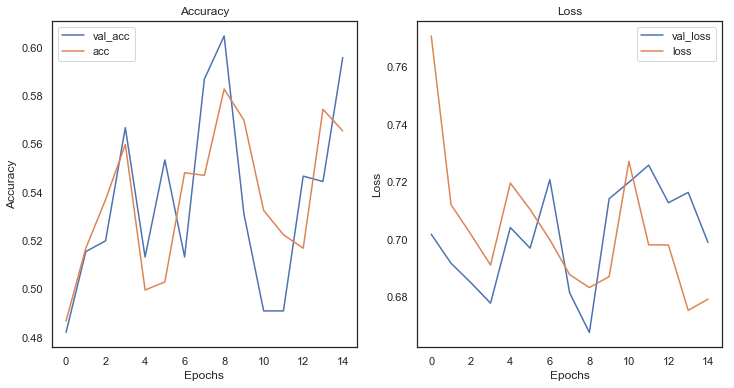

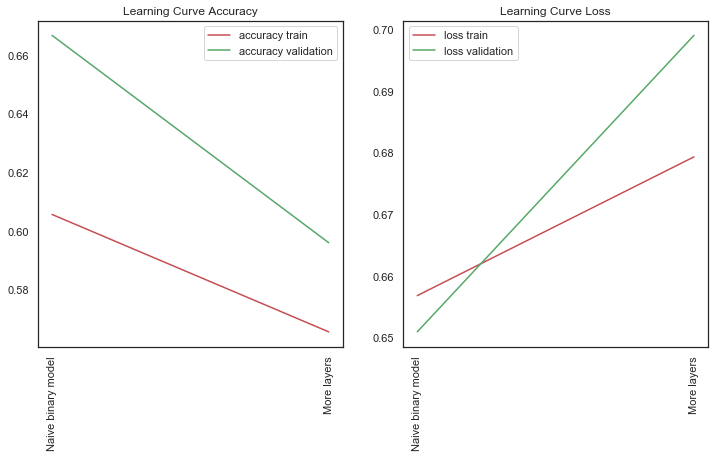

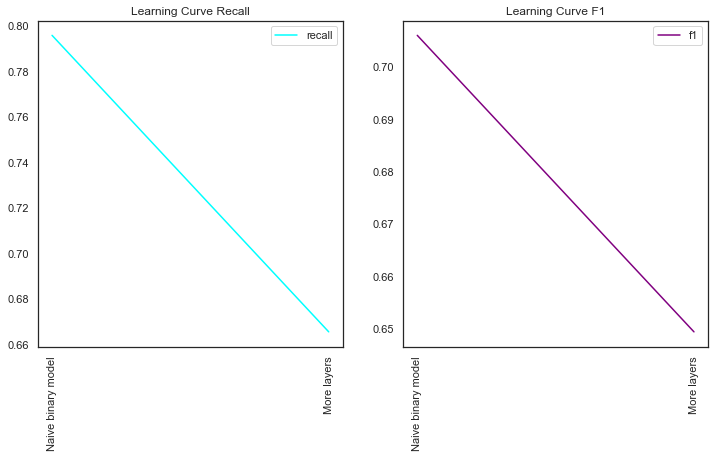

Name                                              model  \
0  Naive binary model  <tensorflow.python.keras.engine.sequential.Seq...   
0         More layers  <tensorflow.python.keras.engine.sequential.Seq...   

   accuracy train  accuracy validation  loss train  loss validation    recall  \
0         0.60562              0.66667     0.65682          0.65094  0.795575   
0         0.56561              0.59598     0.67933          0.69905  0.665487   

         f1  
0  0.705977  
0  0.649307

In [727]:
df=model_results_bin(model_bina, hist_bin1,'More layers',df)
df

In [728]:
y_pred_clas = (model_bina.predict(train_img_bin) > 0.5).astype("float")
print(classification_report(train_y_bin, y_pred_clas))

              precision    recall  f1-score   support

         0.0       0.56      0.79      0.65      1109
         1.0       0.65      0.39      0.48      1130

    accuracy                           0.59      2239
   macro avg       0.60      0.59      0.57      2239
weighted avg       0.60      0.59      0.57      2239



## Re tuning of the parameters
With this time binary classification problem
### Grid Searches
First we will run the grid search for **batch size and epochs**:

In [729]:
"""
# Use scikit-learn to grid search the batch size and epochs
# fix random seed for reproducibility
seed = 42
tf.random.set_seed(seed)

#set X and Y
X=train_img64
Y=train_y
# create model
model = KerasClassifier(model=create_model_bin())
# define the grid search parameters
batch_size = [10, 20, 40, 60, 80, 100]
epochs = [10, 50, 100]
param_grid = dict(batch_size=batch_size, epochs=epochs)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X, Y)
"""

'\n# Use scikit-learn to grid search the batch size and epochs\n# fix random seed for reproducibility\nseed = 42\ntf.random.set_seed(seed)\n\n#set X and Y\nX=train_img64\nY=train_y\n# create model\nmodel = KerasClassifier(model=create_model_bin())\n# define the grid search parameters\nbatch_size = [10, 20, 40, 60, 80, 100]\nepochs = [10, 50, 100]\nparam_grid = dict(batch_size=batch_size, epochs=epochs)\ngrid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)\ngrid_result = grid.fit(X, Y)\n'

In [730]:
"""
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    """

'\n# summarize results\nprint("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))\nmeans = grid_result.cv_results_[\'mean_test_score\']\nstds = grid_result.cv_results_[\'std_test_score\']\nparams = grid_result.cv_results_[\'params\']\nfor mean, stdev, param in zip(means, stds, params):\n    print("%f (%f) with: %r" % (mean, stdev, param))\n    '

In [731]:
#best_params=grid_result.best_params_
#best_params

In [732]:
#best_batch=best_params['batch_size']
#best_epochs=best_params['epochs']
best_batch=100
best_epochs=50

In [733]:
hist_bin2=fit_model(model_bina, train_img_bin, train_y_bin, epo=best_epochs, batch=best_batch)

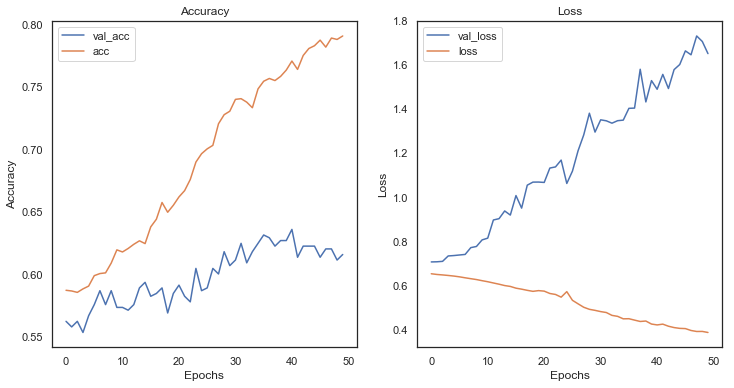

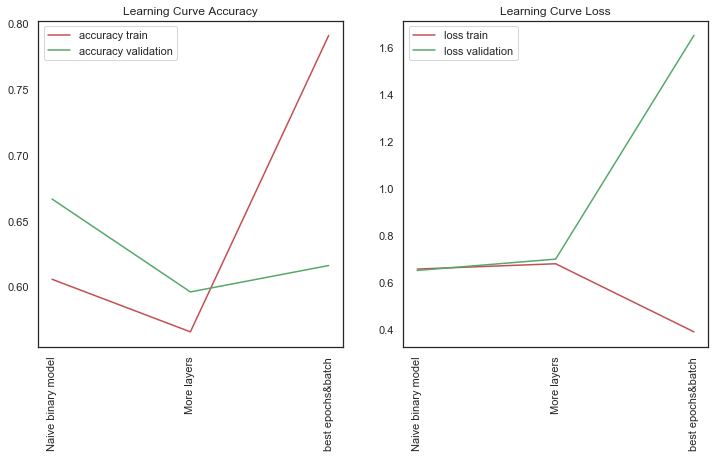

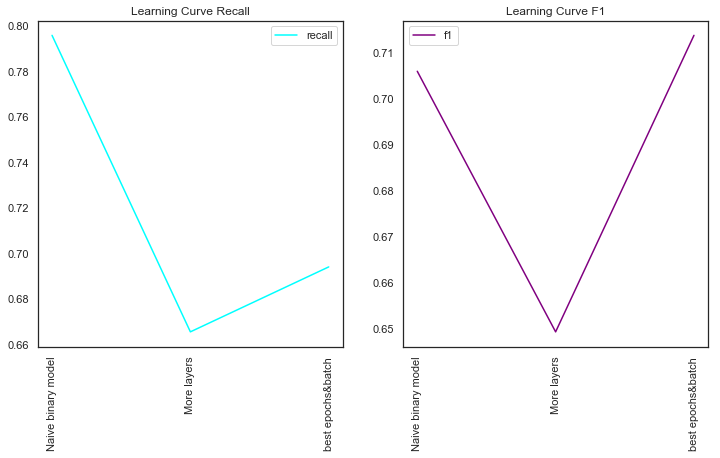

Name                                              model  \
0  Naive binary model  <tensorflow.python.keras.engine.sequential.Seq...   
0         More layers  <tensorflow.python.keras.engine.sequential.Seq...   
0   best epochs&batch  <tensorflow.python.keras.engine.sequential.Seq...   

   accuracy train  accuracy validation  loss train  loss validation    recall  \
0         0.60562              0.66667     0.65682          0.65094  0.795575   
0         0.56561              0.59598     0.67933          0.69905  0.665487   
0         0.79118              0.61607     0.38947          1.65177  0.693982   

         f1  
0  0.705977  
0  0.649307  
0  0.713787

In [734]:
df=model_results_bin(model_bina, hist_bin2, 'best epochs&batch', df)
df

Grid Search for **optimization algorithm**:

In [735]:
"""
# create model
model = KerasClassifier(model=create_model_bin(), 
                        epochs=best_epochs, batch_size=best_batch)
# define the grid search parameters
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
param_grid = dict(optimizer=optimizer)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X, Y)
"""

"\n# create model\nmodel = KerasClassifier(model=create_model_bin(), \n                        epochs=best_epochs, batch_size=best_batch)\n# define the grid search parameters\noptimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']\nparam_grid = dict(optimizer=optimizer)\ngrid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)\ngrid_result = grid.fit(X, Y)\n"

In [736]:
"""
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    """

'\n# summarize results\nprint("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))\nmeans = grid_result.cv_results_[\'mean_test_score\']\nstds = grid_result.cv_results_[\'std_test_score\']\nparams = grid_result.cv_results_[\'params\']\nfor mean, stdev, param in zip(means, stds, params):\n    print("%f (%f) with: %r" % (mean, stdev, param))\n    '

In [737]:
#best_params=grid_result.best_params_
#best_params

In [738]:
#best_opti=best_params['optimizer']
best_opti='RMSprop'

In [739]:
# Run a model and add the results to the bunch
model_binb=create_model_bin(optimizer=best_opti)

In [740]:
hist_bin3=fit_model(model_binb, train_img_bin, train_y_bin, epo=best_epochs, batch=best_batch)

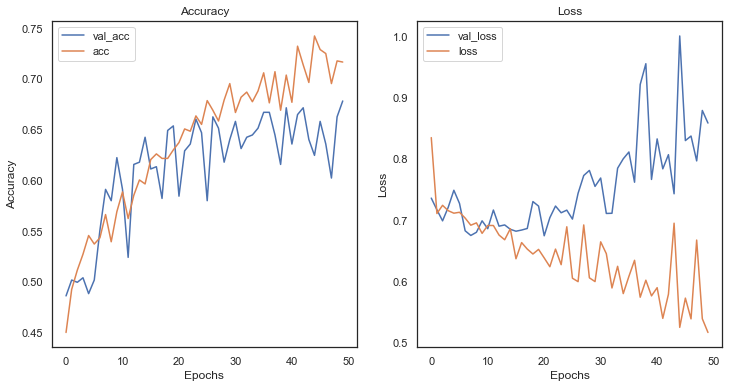

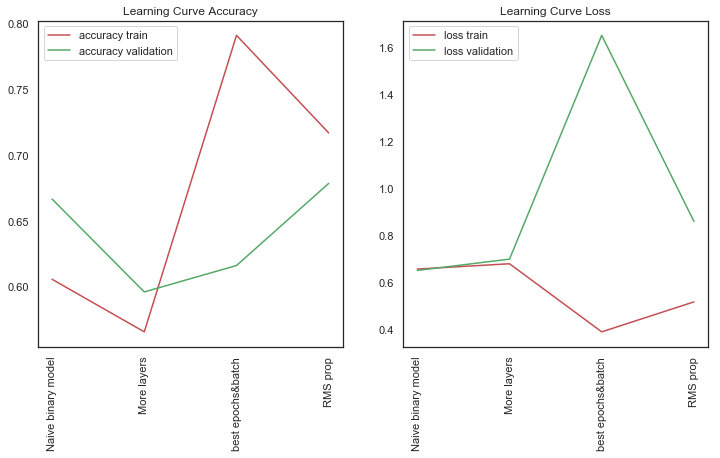

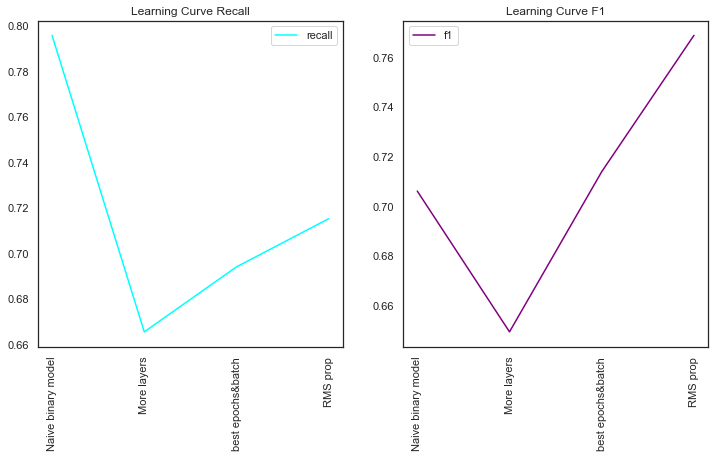

Name                                              model  \
0  Naive binary model  <tensorflow.python.keras.engine.sequential.Seq...   
0         More layers  <tensorflow.python.keras.engine.sequential.Seq...   
0   best epochs&batch  <tensorflow.python.keras.engine.sequential.Seq...   
0            RMS prop  <tensorflow.python.keras.engine.sequential.Seq...   

   accuracy train  accuracy validation  loss train  loss validation    recall  \
0         0.60562              0.66667     0.65682          0.65094  0.795575   
0         0.56561              0.59598     0.67933          0.69905  0.665487   
0         0.79118              0.61607     0.38947          1.65177  0.693982   
0         0.71692              0.67857     0.51708          0.85939  0.715133   

         f1  
0  0.705977  
0  0.649307  
0  0.713787  
0  0.768669

In [741]:
df=model_results_bin(model_binb, hist_bin3, 'RMS prop', df)
df

In [742]:
y_pred_clas = (model_binb.predict(train_img_bin) > 0.5).astype("float")
print(classification_report(train_y_bin, y_pred_clas))

              precision    recall  f1-score   support

         0.0       0.90      0.83      0.86      1109
         1.0       0.85      0.91      0.88      1130

    accuracy                           0.87      2239
   macro avg       0.87      0.87      0.87      2239
weighted avg       0.87      0.87      0.87      2239



### SGD - just in case

In [743]:
# Run a model and add the results to the bunch
model_binb2=create_model_bin(optimizer='sgd')

In [744]:
hist_bin32=fit_model(model_binb2, train_img_bin, train_y_bin, epo=best_epochs, batch=best_batch, verbose=1)

Epoch 1/50
18/18 [==============================] - 4s 182ms/step - loss: 6.6155 - acc: 0.4967 - val_loss: 7.3523 - val_acc: 0.5179
Epoch 2/50
18/18 [==============================] - 3s 169ms/step - loss: 7.7318 - acc: 0.4930 - val_loss: 7.3523 - val_acc: 0.5179
Epoch 3/50
18/18 [==============================] - 3s 167ms/step - loss: 7.7309 - acc: 0.4930 - val_loss: 7.3523 - val_acc: 0.5179
Epoch 4/50
18/18 [==============================] - 3s 171ms/step - loss: 7.6496 - acc: 0.4984 - val_loss: 7.3523 - val_acc: 0.5179
Epoch 5/50
18/18 [==============================] - 3s 173ms/step - loss: 7.5621 - acc: 0.5041 - val_loss: 7.3523 - val_acc: 0.5179
Epoch 6/50
18/18 [==============================] - 3s 177ms/step - loss: 7.5091 - acc: 0.5076 - val_loss: 7.3523 - val_acc: 0.5179
Epoch 7/50
18/18 [==============================] - 3s 171ms/step - loss: 7.4910 - acc: 0.5088 - val_loss: 7.3523 - val_acc: 0.5179
Epoch 8/50
18/18 [==============================] - 3s 172ms/step - loss: 7.

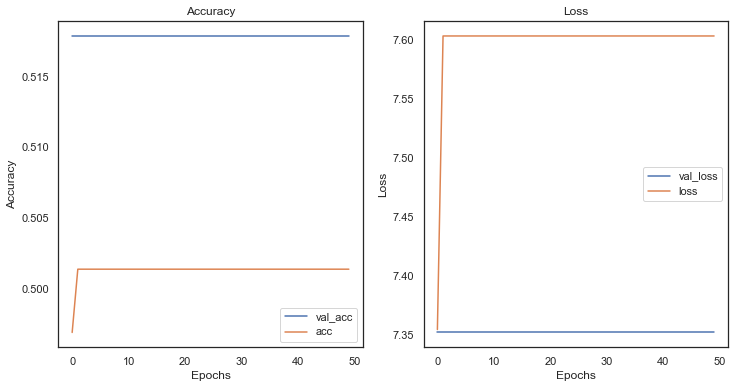

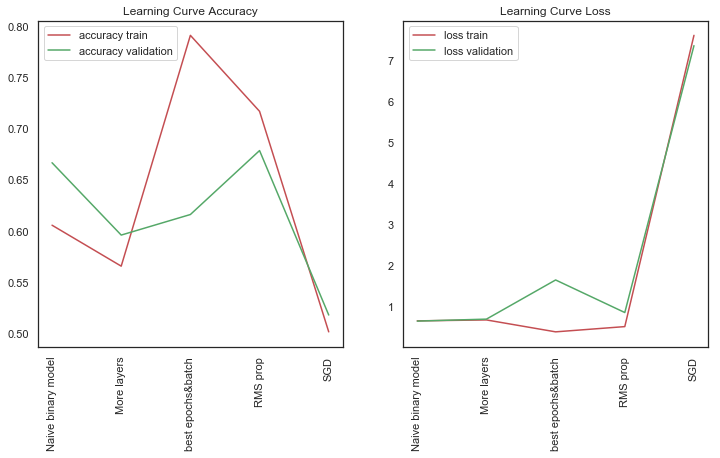

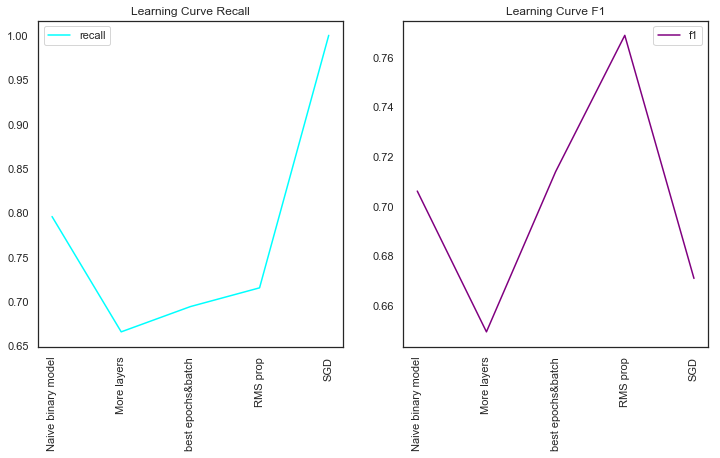

Name                                              model  \
0  Naive binary model  <tensorflow.python.keras.engine.sequential.Seq...   
0         More layers  <tensorflow.python.keras.engine.sequential.Seq...   
0   best epochs&batch  <tensorflow.python.keras.engine.sequential.Seq...   
0            RMS prop  <tensorflow.python.keras.engine.sequential.Seq...   
0                 SGD  <tensorflow.python.keras.engine.sequential.Seq...   

   accuracy train  accuracy validation  loss train  loss validation    recall  \
0         0.60562              0.66667     0.65682          0.65094  0.795575   
0         0.56561              0.59598     0.67933          0.69905  0.665487   
0         0.79118              0.61607     0.38947          1.65177  0.693982   
0         0.71692              0.67857     0.51708          0.85939  0.715133   
0         0.50140              0.51786     7.60333          7.35231  1.000000   

         f1  
0  0.705977  
0  0.649307  
0  0.713787  
0  0.768669  
0  0.670822

In [745]:
df=model_results_bin(model_binb2, hist_bin32, 'SGD', df)
df

In [746]:
y_pred_clas = (model_binb2.predict(train_img_bin) > 0.5).astype("float")
print(classification_report(train_y_bin, y_pred_clas))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      1109
         1.0       0.50      1.00      0.67      1130

    accuracy                           0.50      2239
   macro avg       0.25      0.50      0.34      2239
weighted avg       0.25      0.50      0.34      2239



### SGD
Grid Search **learning rate and momentum**:

In [747]:
"""
# fix random seed for reproducibility
seed = 42
tf.random.set_seed(seed)

#set X and Y
X=train_img64
Y=train_y
# create model
model = KerasClassifier(model=create_model_bin(), loss="binary_crossentropy", 
                        optimizer="SGD", epochs=20, batch_size=20, verbose=0)
# define the grid search parameters
learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
momentum = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]
param_grid = dict(optimizer__learning_rate=learn_rate, optimizer__momentum=momentum)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X, Y)
"""

'\n# fix random seed for reproducibility\nseed = 42\ntf.random.set_seed(seed)\n\n#set X and Y\nX=train_img64\nY=train_y\n# create model\nmodel = KerasClassifier(model=create_model_bin(), loss="binary_crossentropy", \n                        optimizer="SGD", epochs=20, batch_size=20, verbose=0)\n# define the grid search parameters\nlearn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]\nmomentum = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]\nparam_grid = dict(optimizer__learning_rate=learn_rate, optimizer__momentum=momentum)\ngrid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)\ngrid_result = grid.fit(X, Y)\n'

In [748]:
"""
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    """

'\n# summarize results\nprint("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))\nmeans = grid_result.cv_results_[\'mean_test_score\']\nstds = grid_result.cv_results_[\'std_test_score\']\nparams = grid_result.cv_results_[\'params\']\nfor mean, stdev, param in zip(means, stds, params):\n    print("%f (%f) with: %r" % (mean, stdev, param))\n    '

In [749]:
#best_params=grid_result.best_params_
#best_params

In [750]:
#best_rate=best_params['optimizer__learning_rate']
best_rate=0.1

In [751]:
#best_momentum=best_params['optimizer__momentum']
best_momentum=0.6

In [752]:
optimizer_sgd = tf.keras.optimizers.SGD(learning_rate=best_rate, 
                                    momentum=best_momentum)

In [753]:
model_binc=create_model_bin(optimizer=optimizer_sgd)

In [754]:
hist_bin4=fit_model(model_binc, train_img_bin, train_y_bin, epo=best_epochs, batch=best_batch)

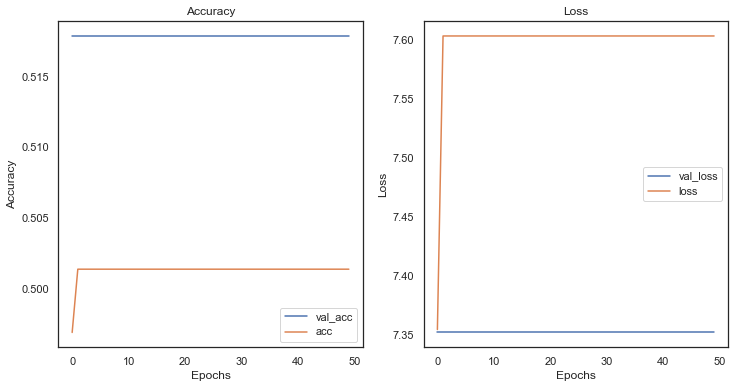

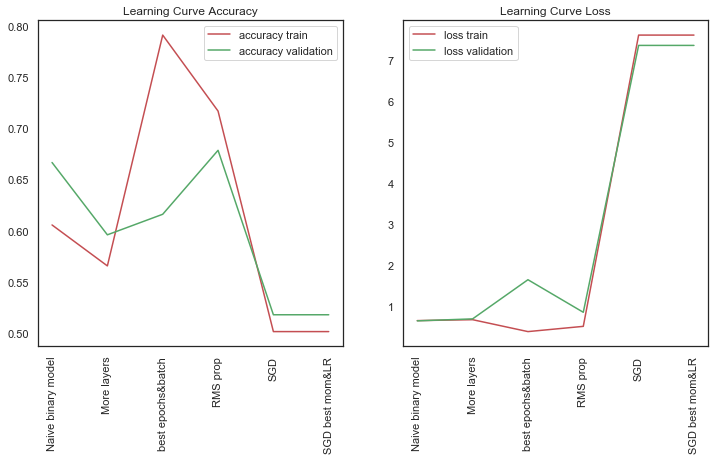

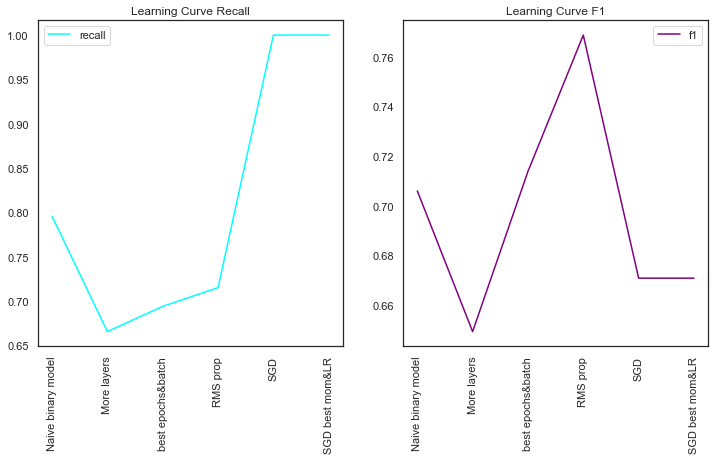

Name                                              model  \
0  Naive binary model  <tensorflow.python.keras.engine.sequential.Seq...   
0         More layers  <tensorflow.python.keras.engine.sequential.Seq...   
0   best epochs&batch  <tensorflow.python.keras.engine.sequential.Seq...   
0            RMS prop  <tensorflow.python.keras.engine.sequential.Seq...   
0                 SGD  <tensorflow.python.keras.engine.sequential.Seq...   
0     SGD best mom&LR  <tensorflow.python.keras.engine.sequential.Seq...   

   accuracy train  accuracy validation  loss train  loss validation    recall  \
0         0.60562              0.66667     0.65682          0.65094  0.795575   
0         0.56561              0.59598     0.67933          0.69905  0.665487   
0         0.79118              0.61607     0.38947          1.65177  0.693982   
0         0.71692              0.67857     0.51708          0.85939  0.715133   
0         0.50140              0.51786     7.60333          7.35231  1.000000   
0         0.50140              0.51786     7.60333          7.35231  1.000000   

         f1  
0  0.705977  
0  0.649307  
0  0.713787  
0  0.768669  
0  0.670822  
0  0.670822

In [755]:
df=model_results_bin(model_binc, hist_bin4, 'SGD best mom&LR', df)
df

In [756]:
y_pred_clas = (model_binc.predict(train_img_bin) > 0.5).astype("float")
print(classification_report(train_y_bin, y_pred_clas))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      1109
         1.0       0.50      1.00      0.67      1130

    accuracy                           0.50      2239
   macro avg       0.25      0.50      0.34      2239
weighted avg       0.25      0.50      0.34      2239



### RMSProp

In [757]:
"""
# fix random seed for reproducibility
seed = 42
tf.random.set_seed(seed)

#set X and Y
X=train_img64
Y=train_y
# create model
model = KerasClassifier(model=create_model_bin(), loss="binary_crossentropy", 
                        optimizer="RMSprop", epochs=20, batch_size=20, verbose=0)
# define the grid search parameters
learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
momentum = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]
param_grid = dict(optimizer__learning_rate=learn_rate, optimizer__momentum=momentum)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X, Y)
"""

'\n# fix random seed for reproducibility\nseed = 42\ntf.random.set_seed(seed)\n\n#set X and Y\nX=train_img64\nY=train_y\n# create model\nmodel = KerasClassifier(model=create_model_bin(), loss="binary_crossentropy", \n                        optimizer="RMSprop", epochs=20, batch_size=20, verbose=0)\n# define the grid search parameters\nlearn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]\nmomentum = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]\nparam_grid = dict(optimizer__learning_rate=learn_rate, optimizer__momentum=momentum)\ngrid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)\ngrid_result = grid.fit(X, Y)\n'

In [758]:
"""
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    """

'\n# summarize results\nprint("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))\nmeans = grid_result.cv_results_[\'mean_test_score\']\nstds = grid_result.cv_results_[\'std_test_score\']\nparams = grid_result.cv_results_[\'params\']\nfor mean, stdev, param in zip(means, stds, params):\n    print("%f (%f) with: %r" % (mean, stdev, param))\n    '

In [759]:
#best_params=grid_result.best_params_
#best_params

In [760]:
#best_rate=best_params['optimizer__learning_rate']
best_rate=0.01

In [761]:
#best_momentum=best_params['optimizer__weight_decay']
best_momentum=0.6

In [762]:
optimizer_rms = tf.keras.optimizers.RMSprop(learning_rate=0.1, 
                                    momentum=0.6)

In [763]:
model_binc2=create_model_bin(optimizer=optimizer_rms)

In [764]:
hist_bin42=fit_model(model_binc2, train_img_bin, train_y_bin, epo=best_epochs, batch=best_batch)

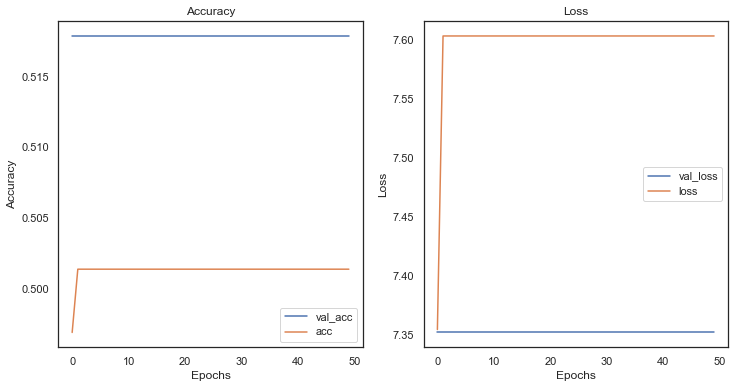

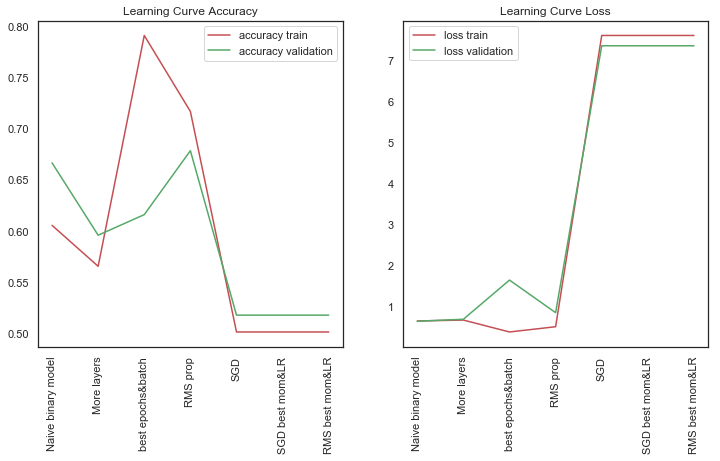

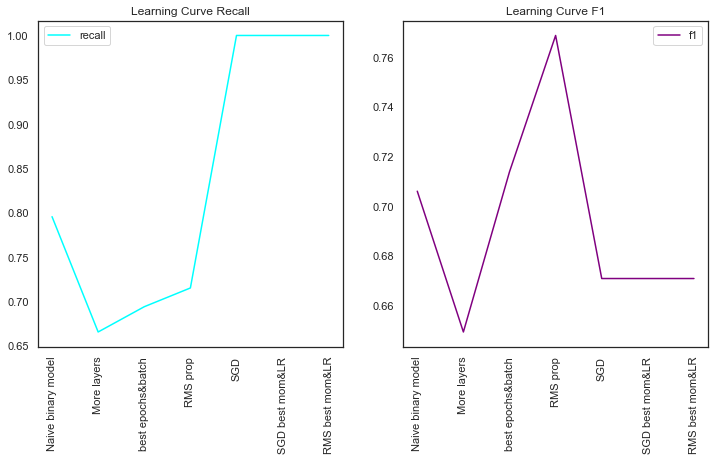

Name                                              model  \
0  Naive binary model  <tensorflow.python.keras.engine.sequential.Seq...   
0         More layers  <tensorflow.python.keras.engine.sequential.Seq...   
0   best epochs&batch  <tensorflow.python.keras.engine.sequential.Seq...   
0            RMS prop  <tensorflow.python.keras.engine.sequential.Seq...   
0                 SGD  <tensorflow.python.keras.engine.sequential.Seq...   
0     SGD best mom&LR  <tensorflow.python.keras.engine.sequential.Seq...   
0     RMS best mom&LR  <tensorflow.python.keras.engine.sequential.Seq...   

   accuracy train  accuracy validation  loss train  loss validation    recall  \
0         0.60562              0.66667     0.65682          0.65094  0.795575   
0         0.56561              0.59598     0.67933          0.69905  0.665487   
0         0.79118              0.61607     0.38947          1.65177  0.693982   
0         0.71692              0.67857     0.51708          0.85939  0.715133   
0         0.50140              0.51786     7.60333          7.35231  1.000000   
0         0.50140              0.51786     7.60333          7.35231  1.000000   
0         0.50140              0.51786     7.60333          7.35231  1.000000   

         f1  
0  0.705977  
0  0.649307  
0  0.713787  
0  0.768669  
0  0.670822  
0  0.670822  
0  0.670822

In [765]:
df=model_results_bin(model_binc2, hist_bin42, 'RMS best mom&LR', df)
df

In [766]:
y_pred_clas = (model_binc2.predict(train_img_bin) > 0.5).astype("float")
print(classification_report(train_y_bin, y_pred_clas))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      1109
         1.0       0.50      1.00      0.67      1130

    accuracy                           0.50      2239
   macro avg       0.25      0.50      0.34      2239
weighted avg       0.25      0.50      0.34      2239



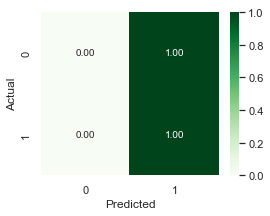

In [767]:
conf_matrix(model_binc2, train_img64, train_y)

### Grid Search Neuron activation function

In [768]:
# Function to create model, required for KerasClassifier
def create_model_CV_bin(activation='relu'):
 # create model
    model = models.Sequential()
    model.add(layers.Conv2D(10, (3, 3), activation=activation,
                        input_shape=(64,64,3)))
    model.add(layers.MaxPooling2D(2,2))
    
    model.add(layers.Conv2D(10, (4, 4), activation=activation))
    model.add(layers.MaxPooling2D(2,2))

    model.add(layers.Conv2D(20, (3, 3), activation=activation))
    model.add(layers.MaxPooling2D(2,2))

    model.add(layers.Flatten())
    model.add(layers.Dense(32, activation=activation))
    model.add(layers.Dense(1, activation=activation))

 # Compile model
    model.compile(loss='binary_crossentropy', 
                   optimizer=optimizer_rms, metrics=['accuracy'])
    return model

In [769]:
"""
# create model
model = KerasClassifier(model=create_model_CV_bin, epochs=20, batch_size=20)
# define the grid search parameters
activation = ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 
              'hard_sigmoid', 'linear']
param_grid = dict(model__activation=activation)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X, Y)
"""

"\n# create model\nmodel = KerasClassifier(model=create_model_CV_bin, epochs=20, batch_size=20)\n# define the grid search parameters\nactivation = ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', \n              'hard_sigmoid', 'linear']\nparam_grid = dict(model__activation=activation)\ngrid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)\ngrid_result = grid.fit(X, Y)\n"

In [770]:
"""
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    """

'\n# summarize results\nprint("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))\nmeans = grid_result.cv_results_[\'mean_test_score\']\nstds = grid_result.cv_results_[\'std_test_score\']\nparams = grid_result.cv_results_[\'params\']\nfor mean, stdev, param in zip(means, stds, params):\n    print("%f (%f) with: %r" % (mean, stdev, param))\n    '

In [771]:
#best_params=grid_result.best_params_
#best_params

In [772]:
#best_function=best_params['model__activation']
best_function='softsign'

In [773]:
model_bind=create_model_bin(activation=best_function, optimizer=optimizer_rms)

In [774]:
hist_bin5=fit_model(model_bind, train_img_bin, train_y_bin, epo=best_epochs, batch=best_batch)

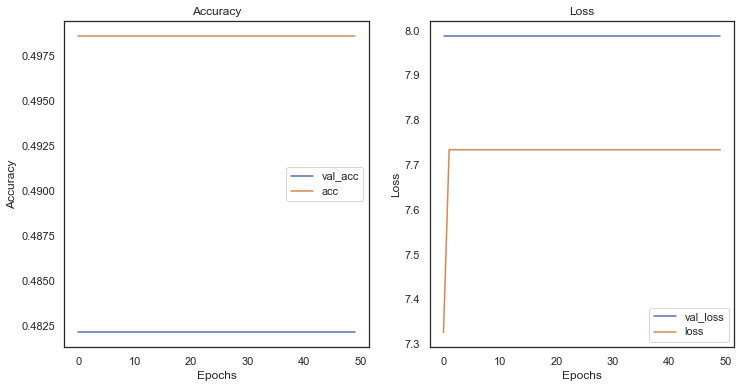

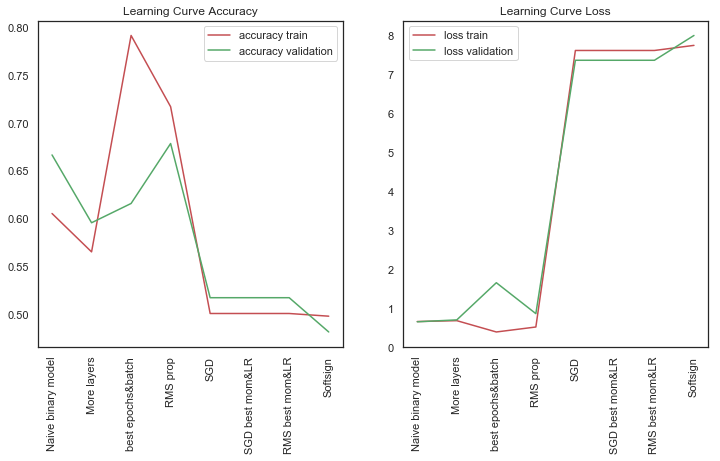

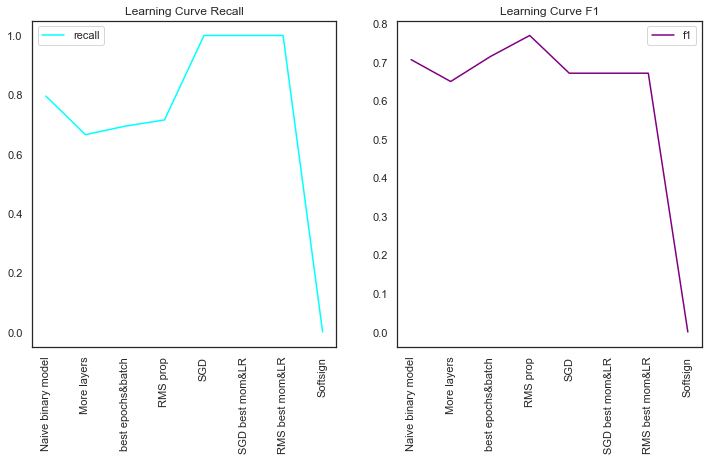

Name                                              model  \
0  Naive binary model  <tensorflow.python.keras.engine.sequential.Seq...   
0         More layers  <tensorflow.python.keras.engine.sequential.Seq...   
0   best epochs&batch  <tensorflow.python.keras.engine.sequential.Seq...   
0            RMS prop  <tensorflow.python.keras.engine.sequential.Seq...   
0                 SGD  <tensorflow.python.keras.engine.sequential.Seq...   
0     SGD best mom&LR  <tensorflow.python.keras.engine.sequential.Seq...   
0     RMS best mom&LR  <tensorflow.python.keras.engine.sequential.Seq...   
0            Softsign  <tensorflow.python.keras.engine.sequential.Seq...   

   accuracy train  accuracy validation  loss train  loss validation    recall  \
0         0.60562              0.66667     0.65682          0.65094  0.795575   
0         0.56561              0.59598     0.67933          0.69905  0.665487   
0         0.79118              0.61607     0.38947          1.65177  0.693982   
0         0.71692              0.67857     0.51708          0.85939  0.715133   
0         0.50140              0.51786     7.60333          7.35231  1.000000   
0         0.50140              0.51786     7.60333          7.35231  1.000000   
0         0.50140              0.51786     7.60333          7.35231  1.000000   
0         0.49860              0.48214     7.73401          7.98792  0.000000   

         f1  
0  0.705977  
0  0.649307  
0  0.713787  
0  0.768669  
0  0.670822  
0  0.670822  
0  0.670822  
0  0.000000

In [775]:
df=model_results_bin(model_bind, hist_bin5, 'Softsign', df)
df

In [776]:
y_pred_clas = (model_bind.predict(train_img_bin) > 0.5).astype("float")
print(classification_report(train_y_bin, y_pred_clas))

              precision    recall  f1-score   support

         0.0       0.50      1.00      0.66      1109
         1.0       0.00      0.00      0.00      1130

    accuracy                           0.50      2239
   macro avg       0.25      0.50      0.33      2239
weighted avg       0.25      0.50      0.33      2239



GridSearch **Number of Neurons:**

In [777]:
# Function to create model, required for KerasClassifier
def create_model_neurons(neurons):
 # create model
    model = models.Sequential()
    model.add(layers.Conv2D(neurons, (3, 3), activation=best_function,
                        input_shape=(64, 64, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(neurons, (4, 4), activation=best_function))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(neurons, (3, 3), activation=best_function))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(neurons, activation=best_function))
    model.add(layers.Dense(1, activation=best_function))

# Compile model
    model.compile(loss='binary_crossentropy',
              optimizer=optimizer_rms,
              metrics=['acc'])
    return model

In [778]:
"""
# fix random seed for reproducibility
seed = 42
tf.random.set_seed(seed)
#set X and Y
X=train_img64
Y=train_y
# create model
model = KerasClassifier(model=create_model_neurons, epochs=100, batch_size=50, verbose=0)
# define the grid search parameters
neurons = [1, 5, 10, 15, 20, 25, 30]
param_grid = dict(model__neurons=neurons)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X, Y)
"""

'\n# fix random seed for reproducibility\nseed = 42\ntf.random.set_seed(seed)\n#set X and Y\nX=train_img64\nY=train_y\n# create model\nmodel = KerasClassifier(model=create_model_neurons, epochs=100, batch_size=50, verbose=0)\n# define the grid search parameters\nneurons = [1, 5, 10, 15, 20, 25, 30]\nparam_grid = dict(model__neurons=neurons)\ngrid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)\ngrid_result = grid.fit(X, Y)\n'

In [779]:
"""
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    """

'\n# summarize results\nprint("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))\nmeans = grid_result.cv_results_[\'mean_test_score\']\nstds = grid_result.cv_results_[\'std_test_score\']\nparams = grid_result.cv_results_[\'params\']\nfor mean, stdev, param in zip(means, stds, params):\n    print("%f (%f) with: %r" % (mean, stdev, param))\n    '

In [780]:
#best_params=grid_result.best_params_
#best_params

In [781]:
#best_neurons=best_params['model__neurons']
best_neurons=5

In [782]:
model_bine=create_model_bin(activation=best_function, optimizer=optimizer_rms,
                     neur1=best_neurons, neur2=best_neurons)

In [783]:
hist_bin6=fit_model(model_bine, train_img_bin, train_y_bin, epo=best_epochs, batch=best_batch)

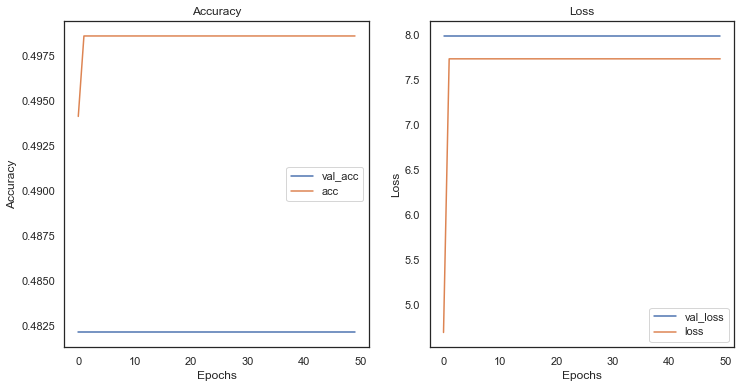

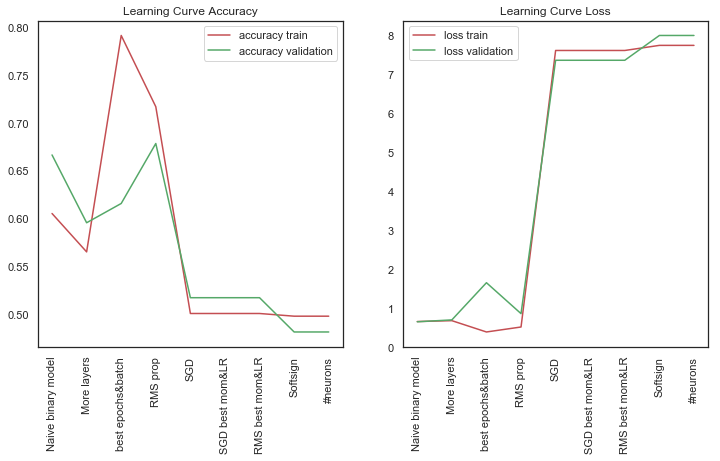

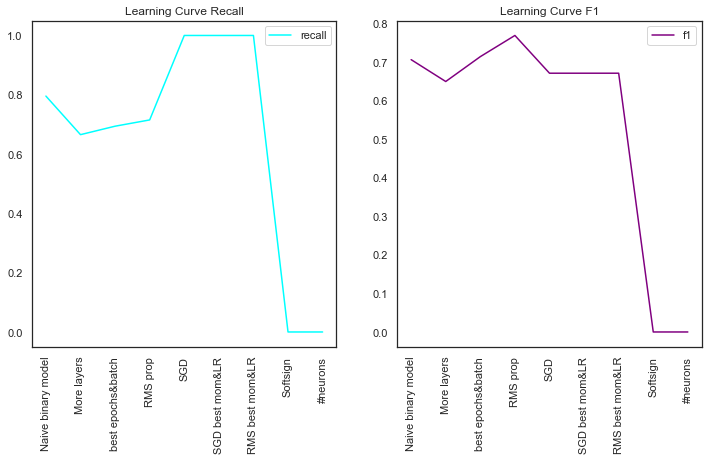

Name                                              model  \
0  Naive binary model  <tensorflow.python.keras.engine.sequential.Seq...   
0         More layers  <tensorflow.python.keras.engine.sequential.Seq...   
0   best epochs&batch  <tensorflow.python.keras.engine.sequential.Seq...   
0            RMS prop  <tensorflow.python.keras.engine.sequential.Seq...   
0                 SGD  <tensorflow.python.keras.engine.sequential.Seq...   
0     SGD best mom&LR  <tensorflow.python.keras.engine.sequential.Seq...   
0     RMS best mom&LR  <tensorflow.python.keras.engine.sequential.Seq...   
0            Softsign  <tensorflow.python.keras.engine.sequential.Seq...   
0            #neurons  <tensorflow.python.keras.engine.sequential.Seq...   

   accuracy train  accuracy validation  loss train  loss validation    recall  \
0         0.60562              0.66667     0.65682          0.65094  0.795575   
0         0.56561              0.59598     0.67933          0.69905  0.665487   
0         0.79118              0.61607     0.38947          1.65177  0.693982   
0         0.71692              0.67857     0.51708          0.85939  0.715133   
0         0.50140              0.51786     7.60333          7.35231  1.000000   
0         0.50140              0.51786     7.60333          7.35231  1.000000   
0         0.50140              0.51786     7.60333          7.35231  1.000000   
0         0.49860              0.48214     7.73401          7.98792  0.000000   
0         0.49860              0.48214     7.73401          7.98792  0.000000   

         f1  
0  0.705977  
0  0.649307  
0  0.713787  
0  0.768669  
0  0.670822  
0  0.670822  
0  0.670822  
0  0.000000  
0  0.000000

In [784]:
df=model_results_bin(model_bine, hist_bin6, '#neurons', df)
df

In [785]:
y_pred_clas = (model_bine.predict(train_img_bin) > 0.5).astype("float")
print(classification_report(train_y_bin, y_pred_clas))

              precision    recall  f1-score   support

         0.0       0.50      1.00      0.66      1109
         1.0       0.00      0.00      0.00      1130

    accuracy                           0.50      2239
   macro avg       0.25      0.50      0.33      2239
weighted avg       0.25      0.50      0.33      2239



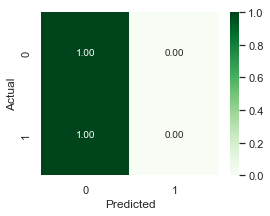

In [786]:
conf_matrix(model_bine, train_img_bin, train_y_bin)

### Normalization:

In [787]:
model_binf = models.Sequential()
model_binf.add(layers.Conv2D(best_neurons, (3, 3), activation=best_function,
                            input_shape=(64,64,3)))
model_binf.add(layers.MaxPooling2D((2, 2)))
    
model_binf.add(layers.Conv2D(best_neurons, (4, 4), activation=best_function
                         ,kernel_regularizer=regularizers.L2(l2=0.01)))
model_binf.add(layers.MaxPooling2D((2, 2)))

model_binf.add(layers.Conv2D(best_neurons, (3, 3), activation=best_function
                          ,kernel_regularizer=regularizers.L2(l2=0.01)))
model_binf.add(layers.MaxPooling2D((2, 2)))

model_binf.add(layers.Flatten())
model_binf.add(layers.Dense(32, activation=best_function 
                       ,kernel_regularizer=regularizers.L2(l2=0.01)))
model_binf.add(layers.Dense(1, activation=best_function))

# Compile model
model_binf.compile(loss='binary_crossentropy',
              optimizer=optimizer_sgd,
              metrics=['acc'])

In [788]:
hist_bin7=fit_model(model_binf, train_img_bin, train_y_bin, epo=best_epochs, batch=best_batch)

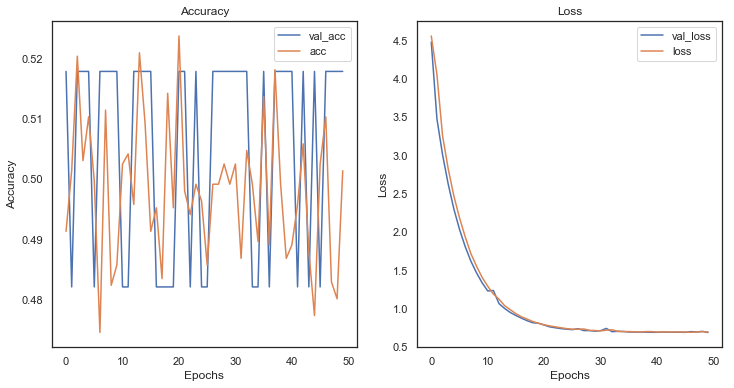

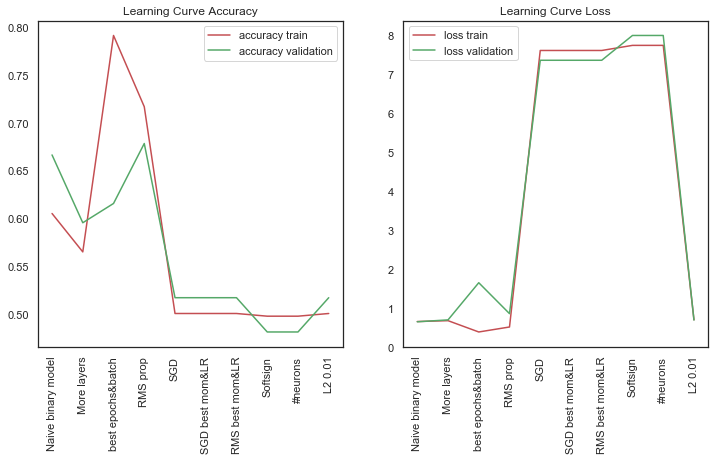

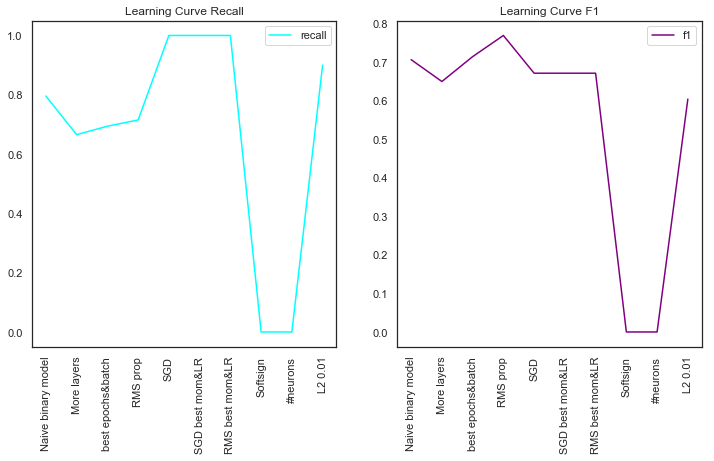

Name                                              model  \
0  Naive binary model  <tensorflow.python.keras.engine.sequential.Seq...   
0         More layers  <tensorflow.python.keras.engine.sequential.Seq...   
0   best epochs&batch  <tensorflow.python.keras.engine.sequential.Seq...   
0            RMS prop  <tensorflow.python.keras.engine.sequential.Seq...   
0                 SGD  <tensorflow.python.keras.engine.sequential.Seq...   
0     SGD best mom&LR  <tensorflow.python.keras.engine.sequential.Seq...   
0     RMS best mom&LR  <tensorflow.python.keras.engine.sequential.Seq...   
0            Softsign  <tensorflow.python.keras.engine.sequential.Seq...   
0            #neurons  <tensorflow.python.keras.engine.sequential.Seq...   
0             L2 0.01  <tensorflow.python.keras.engine.sequential.Seq...   

   accuracy train  accuracy validation  loss train  loss validation    recall  \
0         0.60562              0.66667     0.65682          0.65094  0.795575   
0         0.56561              0.59598     0.67933          0.69905  0.665487   
0         0.79118              0.61607     0.38947          1.65177  0.693982   
0         0.71692              0.67857     0.51708          0.85939  0.715133   
0         0.50140              0.51786     7.60333          7.35231  1.000000   
0         0.50140              0.51786     7.60333          7.35231  1.000000   
0         0.50140              0.51786     7.60333          7.35231  1.000000   
0         0.49860              0.48214     7.73401          7.98792  0.000000   
0         0.49860              0.48214     7.73401          7.98792  0.000000   
0         0.50140              0.51786     0.70203          0.69476  0.900000   

         f1  
0  0.705977  
0  0.649307  
0  0.713787  
0  0.768669  
0  0.670822  
0  0.670822  
0  0.670822  
0  0.000000  
0  0.000000  
0  0.603740

In [789]:
df=model_results_bin(model_binf, hist_bin7, 'L2 0.01', df)
df

In [790]:
y_pred_clas = (model_binf.predict(train_img_bin) > 0.5).astype("float")
print(classification_report(train_y_bin, y_pred_clas))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      1109
         1.0       0.50      1.00      0.67      1130

    accuracy                           0.50      2239
   macro avg       0.25      0.50      0.34      2239
weighted avg       0.25      0.50      0.34      2239



### Regularization:

Grid search dropout regularization

In [791]:
# Function to create model, required for KerasClassifier
def create_model_drop(dropout_rate, weight_constraint):

    model = models.Sequential()
    model.add(layers.Conv2D(best_neurons, (3, 3), activation=best_function,
                        input_shape=(64, 64, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(best_neurons, (4, 4), activation=best_function,
                         kernel_regularizer=regularizers.L2(l2=0.01), 
                          kernel_constraint=MaxNorm(weight_constraint)))
    model.add(layers.MaxPooling2D((2, 2)))
# Implement dropout to the first hidden layer 
    model.add(layers.Dropout(dropout_rate))
            

    model.add(layers.Conv2D(best_neurons, (3, 3), activation=best_function, 
                        kernel_regularizer=regularizers.L2(l2=0.01), 
                          kernel_constraint=MaxNorm(weight_constraint)))
    model.add(layers.MaxPooling2D((2, 2)))
            
# Implement dropout to the second hidden layer 
    model.add(layers.Dropout(dropout_rate))            

    model.add(layers.Flatten())
    model.add(layers.Dense(32, activation=best_function, 
                       kernel_regularizer=regularizers.L2(l2=0.01)))
    model.add(layers.Dense(1, activation=best_function))

# Compile model
    model.compile(loss='binary_crossentropy',
              optimizer=optimizer_sgd,
              metrics=['acc'])
    return model

In [792]:
"""
# create model
model = KerasClassifier(model=create_model_drop, epochs=30, batch_size=20)
# define the grid search parameters
weight_constraint = [1.0, 2.0, 3.0, 4.0, 5.0]
#dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
dropout_rate = [0.0, 0.3, 0.5, 0.7, 0.9]
param_grid = dict(model__dropout_rate=dropout_rate, 
                  model__weight_constraint=weight_constraint)
#param_grid = dict(model__dropout_rate=dropout_rate)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X, Y)
"""

'\n# create model\nmodel = KerasClassifier(model=create_model_drop, epochs=30, batch_size=20)\n# define the grid search parameters\nweight_constraint = [1.0, 2.0, 3.0, 4.0, 5.0]\n#dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]\ndropout_rate = [0.0, 0.3, 0.5, 0.7, 0.9]\nparam_grid = dict(model__dropout_rate=dropout_rate, \n                  model__weight_constraint=weight_constraint)\n#param_grid = dict(model__dropout_rate=dropout_rate)\ngrid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)\ngrid_result = grid.fit(X, Y)\n'

In [793]:
"""
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    """

'\n# summarize results\nprint("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))\nmeans = grid_result.cv_results_[\'mean_test_score\']\nstds = grid_result.cv_results_[\'std_test_score\']\nparams = grid_result.cv_results_[\'params\']\nfor mean, stdev, param in zip(means, stds, params):\n    print("%f (%f) with: %r" % (mean, stdev, param))\n    '

In [794]:
#best_params=grid_result.best_params_
#best_params

In [795]:
#best_drop=best_params['model__dropout_rate']
best_drop = 0.0 

In [796]:
#best_weight_const=best_params['model__weight_constraint']
best_weight_const = 1.0

In [797]:
model_bing=create_model_drop(dropout_rate=best_drop, weight_constraint=best_weight_const)

In [798]:
hist_bin8=fit_model(model_bing, train_img_bin, train_y_bin, epo=best_epochs, batch=best_batch)

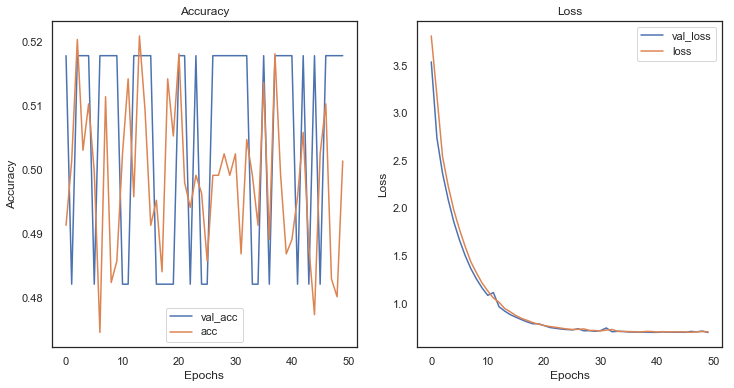

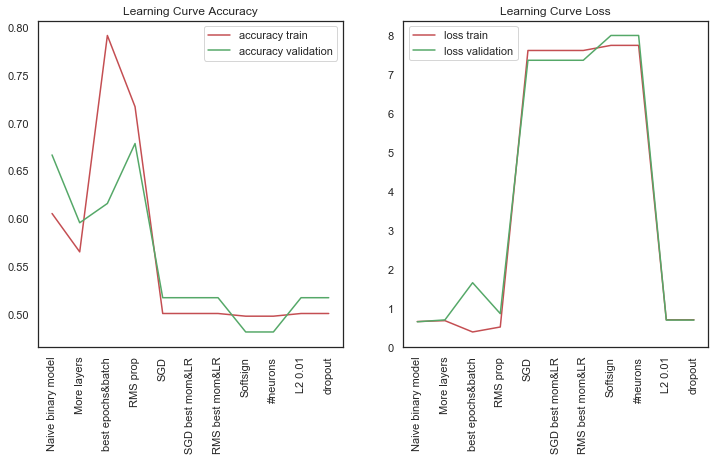

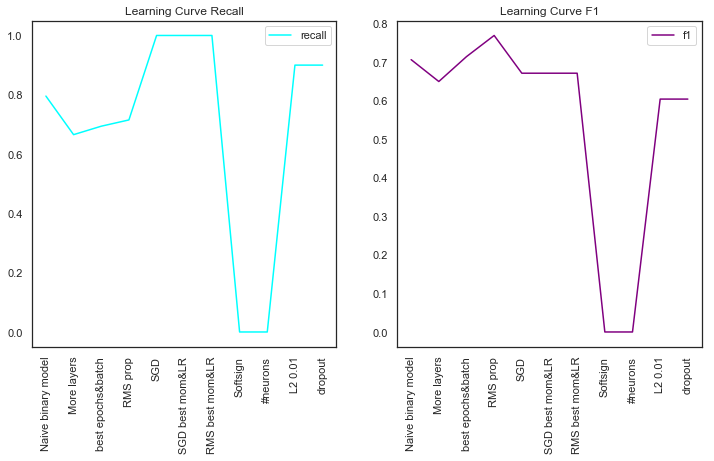

Name                                              model  \
0  Naive binary model  <tensorflow.python.keras.engine.sequential.Seq...   
0         More layers  <tensorflow.python.keras.engine.sequential.Seq...   
0   best epochs&batch  <tensorflow.python.keras.engine.sequential.Seq...   
0            RMS prop  <tensorflow.python.keras.engine.sequential.Seq...   
0                 SGD  <tensorflow.python.keras.engine.sequential.Seq...   
0     SGD best mom&LR  <tensorflow.python.keras.engine.sequential.Seq...   
0     RMS best mom&LR  <tensorflow.python.keras.engine.sequential.Seq...   
0            Softsign  <tensorflow.python.keras.engine.sequential.Seq...   
0            #neurons  <tensorflow.python.keras.engine.sequential.Seq...   
0             L2 0.01  <tensorflow.python.keras.engine.sequential.Seq...   
0             dropout  <tensorflow.python.keras.engine.sequential.Seq...   

   accuracy train  accuracy validation  loss train  loss validation    recall  \
0         0.60562              0.66667     0.65682          0.65094  0.795575   
0         0.56561              0.59598     0.67933          0.69905  0.665487   
0         0.79118              0.61607     0.38947          1.65177  0.693982   
0         0.71692              0.67857     0.51708          0.85939  0.715133   
0         0.50140              0.51786     7.60333          7.35231  1.000000   
0         0.50140              0.51786     7.60333          7.35231  1.000000   
0         0.50140              0.51786     7.60333          7.35231  1.000000   
0         0.49860              0.48214     7.73401          7.98792  0.000000   
0         0.49860              0.48214     7.73401          7.98792  0.000000   
0         0.50140              0.51786     0.70203          0.69476  0.900000   
0         0.50140              0.51786     0.70188          0.69462  0.900000   

         f1  
0  0.705977  
0  0.649307  
0  0.713787  
0  0.768669  
0  0.670822  
0  0.670822  
0  0.670822  
0  0.000000  
0  0.000000  
0  0.603740  
0  0.603740

In [799]:
df=model_results_bin(model_bing, hist_bin8, 'dropout', df)
df

In [800]:
y_pred_clas = (model_bing.predict(train_img_bin) > 0.5).astype("float")
print(classification_report(train_y_bin, y_pred_clas))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      1109
         1.0       0.50      1.00      0.67      1130

    accuracy                           0.50      2239
   macro avg       0.25      0.50      0.34      2239
weighted avg       0.25      0.50      0.34      2239



### Selecting the best model

> model_bing or other one, explain why 

Because of the stochastic nature of Neural Networks, we tried to stabilize our results by setting random seeds and by repeating the fitting and evaluation of each model 10 times and taking the average of the results.
There is still some randomness that we can't avoid mostly due to the randomness of the weights assigned, because of it we will write some code that selects the best performing model automatically.
We will look at the model that has the highest recall and f1 combination, excluding the models that have recall=1 since in those cases all the images were classified as 'cancerous'. This leads to a recall of 100% but is clearly a useless model, and its accuracy f1 and all the other metrics are going to be low.
We will work on our dataframe to select the model.

In [801]:
df

Name                                              model  \
0  Naive binary model  <tensorflow.python.keras.engine.sequential.Seq...   
0         More layers  <tensorflow.python.keras.engine.sequential.Seq...   
0   best epochs&batch  <tensorflow.python.keras.engine.sequential.Seq...   
0            RMS prop  <tensorflow.python.keras.engine.sequential.Seq...   
0                 SGD  <tensorflow.python.keras.engine.sequential.Seq...   
0     SGD best mom&LR  <tensorflow.python.keras.engine.sequential.Seq...   
0     RMS best mom&LR  <tensorflow.python.keras.engine.sequential.Seq...   
0            Softsign  <tensorflow.python.keras.engine.sequential.Seq...   
0            #neurons  <tensorflow.python.keras.engine.sequential.Seq...   
0             L2 0.01  <tensorflow.python.keras.engine.sequential.Seq...   
0             dropout  <tensorflow.python.keras.engine.sequential.Seq...   

   accuracy train  accuracy validation  loss train  loss validation    recall  \
0         0.60562              0.66667     0.65682          0.65094  0.795575   
0         0.56561              0.59598     0.67933          0.69905  0.665487   
0         0.79118              0.61607     0.38947          1.65177  0.693982   
0         0.71692              0.67857     0.51708          0.85939  0.715133   
0         0.50140              0.51786     7.60333          7.35231  1.000000   
0         0.50140              0.51786     7.60333          7.35231  1.000000   
0         0.50140              0.51786     7.60333          7.35231  1.000000   
0         0.49860              0.48214     7.73401          7.98792  0.000000   
0         0.49860              0.48214     7.73401          7.98792  0.000000   
0         0.50140              0.51786     0.70203          0.69476  0.900000   
0         0.50140              0.51786     0.70188          0.69462  0.900000   

         f1  
0  0.705977  
0  0.649307  
0  0.713787  
0  0.768669  
0  0.670822  
0  0.670822  
0  0.670822  
0  0.000000  
0  0.000000  
0  0.603740  
0  0.603740

In [803]:
df=df.loc[df['recall']!= 1.0]
df

Name                                              model  \
0  Naive binary model  <tensorflow.python.keras.engine.sequential.Seq...   
0         More layers  <tensorflow.python.keras.engine.sequential.Seq...   
0   best epochs&batch  <tensorflow.python.keras.engine.sequential.Seq...   
0            RMS prop  <tensorflow.python.keras.engine.sequential.Seq...   
0            Softsign  <tensorflow.python.keras.engine.sequential.Seq...   
0            #neurons  <tensorflow.python.keras.engine.sequential.Seq...   
0             L2 0.01  <tensorflow.python.keras.engine.sequential.Seq...   
0             dropout  <tensorflow.python.keras.engine.sequential.Seq...   

   accuracy train  accuracy validation  loss train  loss validation    recall  \
0         0.60562              0.66667     0.65682          0.65094  0.795575   
0         0.56561              0.59598     0.67933          0.69905  0.665487   
0         0.79118              0.61607     0.38947          1.65177  0.693982   
0         0.71692              0.67857     0.51708          0.85939  0.715133   
0         0.49860              0.48214     7.73401          7.98792  0.000000   
0         0.49860              0.48214     7.73401          7.98792  0.000000   
0         0.50140              0.51786     0.70203          0.69476  0.900000   
0         0.50140              0.51786     0.70188          0.69462  0.900000   

         f1  
0  0.705977  
0  0.649307  
0  0.713787  
0  0.768669  
0  0.000000  
0  0.000000  
0  0.603740  
0  0.603740

In [804]:
df['rec+f1']=df['recall']+df['f1']
df.sort_values(by=['rec+f1'], inplace=True, ascending=False)
df

Name                                              model  \
0             L2 0.01  <tensorflow.python.keras.engine.sequential.Seq...   
0             dropout  <tensorflow.python.keras.engine.sequential.Seq...   
0  Naive binary model  <tensorflow.python.keras.engine.sequential.Seq...   
0            RMS prop  <tensorflow.python.keras.engine.sequential.Seq...   
0   best epochs&batch  <tensorflow.python.keras.engine.sequential.Seq...   
0         More layers  <tensorflow.python.keras.engine.sequential.Seq...   
0            Softsign  <tensorflow.python.keras.engine.sequential.Seq...   
0            #neurons  <tensorflow.python.keras.engine.sequential.Seq...   

   accuracy train  accuracy validation  loss train  loss validation    recall  \
0         0.50140              0.51786     0.70203          0.69476  0.900000   
0         0.50140              0.51786     0.70188          0.69462  0.900000   
0         0.60562              0.66667     0.65682          0.65094  0.795575   
0         0.71692              0.67857     0.51708          0.85939  0.715133   
0         0.79118              0.61607     0.38947          1.65177  0.693982   
0         0.56561              0.59598     0.67933          0.69905  0.665487   
0         0.49860              0.48214     7.73401          7.98792  0.000000   
0         0.49860              0.48214     7.73401          7.98792  0.000000   

         f1    rec+f1  
0  0.603740  1.503740  
0  0.603740  1.503740  
0  0.705977  1.501552  
0  0.768669  1.483802  
0  0.713787  1.407770  
0  0.649307  1.314793  
0  0.000000  0.000000  
0  0.000000  0.000000

In [805]:
###### REMEMBER TO CHANGE THIS TO 0 WHEN YOU RUN IT AGAIN PROPERLY!

best_model=df.iloc[0]['model']
best_model

Attempt one:
    <br>naive is the best model
    <br>not great
    <br>recall 0.804 f1 0.705
    <br>rec+f1 1.509
    
Attempt two:
<br>L2 0.01 model
<br>recall 0.9
<br>f1 0.6
<br>rec+f1 1.50
    
Attempt three:
<br>L2 0.01 model
<br>recall 0.9
<br>f1 0.6
<br>rec+f1 1.50

### Evaluating on the train and on the test set
#### Loss and Accuracy:

In [806]:
train_loss, train_acc = best_model.evaluate(train_img_bin, train_y_bin)

print('Train Loss:', train_loss, '\nTrain Accuracy:', train_acc)

70/70 [==============================] - 1s 17ms/step - loss: 6.3061 - acc: 0.5047
Train Loss: 6.306097507476807 
Train Accuracy: 0.5046895742416382


In [807]:
test_loss, test_acc= best_model.evaluate(train_img_bin, train_y_bin)

print('Test Loss:', test_loss, '\nTest Accuracy:', test_acc)

70/70 [==============================] - 1s 19ms/step - loss: 6.3061 - acc: 0.5047
Test Loss: 6.306097507476807 
Test Accuracy: 0.5046895742416382


### Increasing recall threshold
One more thing we can do to increase our recall, is to move the recall threshold, to make our model more sensitive to possible positive cases, and make it less likely to get false negatives.
<br>This is achieved simply by moving the threshold of what is considered a positive case, we will do it by changing the value that determines our prediction of our classes.
<br>Right now if the probability that an image belongs to the class "cancerous" is above 50% the images is classified as cancerous.
<br>We can decide instead that if an image has even only a 40% chance, or 30% chance of being cancerous, it will be classified as cancerous.
<br>This will lower the overall accuracy of the model, but it will allow us to flag and consider cancerous more images, being on the safer side and leaving it up to the Dr to double check and decide which one of the images are actually of a cancerous growth, either by looking at them or by deciding to take a sample and run a biopsy.

We will achieve this simply by changing the thresholds in the functions we had defined, from 0.5 to 0.3,  namely on row 9 for the `calculate_metrics` function and on row 4 of the `conf_matrix` function.
We will also change the default input from train to test, since we are finally evaluating on the test.

In [808]:
def calculate_metrics(model, testX=test_img_bin, test_y=test_y_bin, epochs=10, batch=30):
    recs=[]
    f1s=[]
    for i in range(10):
        fit_model(model, testX, test_y, epo=epochs, batch=batch)
    # predict probabilities
        y_pred_prob = model.predict(testX, verbose=0)
    # predict classes
        y_pred_clas = (model.predict(testX) > 0.3).astype("float")
#        y_pred_clas = np.argmax(y_pred_prob,axis=1)
#    y_pred_clas =np.round(y_pred_prob).astype(int)
    # reduce to 1d array
        y_pred_prob = y_pred_prob[:, 0]
#        y_pred_clas = y_pred_clas[:, 0]
        recall = recall_score(test_y, y_pred_clas)
        f1 = f1_score(test_y, y_pred_clas)
        recs.append(recall)
        f1s.append(f1)
#        print (trainy)
#        print (y_pred_clas)
        i+=1
    recall_mean=np.mean(recs)
    f1_mean=np.mean(f1s)
        
    return recall_mean, f1_mean#, trainy, y_pred_clas

In [809]:
def conf_matrix(model, testX=test_img_bin, test_y=test_y_bin):
    y_pred_prob = model.predict(testX, verbose=0)
    # predict classes
    y_pred_clas = (model.predict(testX) > 0.3).astype("float")
#    y_pred_clas =np.round(y_pred_prob).astype(int)
    # confusion matrix
    cnm = confusion_matrix(test_y, y_pred_clas)
    # To Normalize
    cnm = cnm.astype('float') / cnm.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots(figsize=(4,3))
    sns.heatmap(cnm, annot=True, fmt='.2f', cmap="Greens")
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show(block=False)

In [810]:
recall, f1=calculate_metrics(model=best_model)
print(f'The recall for our chosen best model is {recall}\n the f1 for our chose best model is {f1}')

The recall for our chosen best model is 1.0
 the f1 for our chose best model is 0.627906976744186


NAIVE:
<br>The recall for our chosen best model is 0.9462962962962962
<br>the f1 for our chose best model is 0.6376995846566962

REGULARIZATION L2:
<br>The recall for our chosen best model is 1.0
<br>the f1 for our chose best model is 0.627906976744186

REGULARIZATION L2:
The recall for our chosen best model is 1.0
 the f1 for our chose best model is 0.627906976744186

This could be something that the Doctor could set as they please based on the level of 'risk' they are willing to take, and it could be also turned into a function that tell at which point of the threshold the image get classified as positive or negative.

## LIME

Next we will use a very powerful model explainability tool called LIME.
<br>One of the main issue we have with Convolutional Neural Networks (and Neural Networks in general) is that even though they are very powerful and efficient, they are hard to understand from the outside.
<br>They are what is usually called a "black box model". Which means that we provide them with some structure of the model and the input and they produce a result, that is often very accurate, but we have no way from the outside to see what happened exactly for the model to get to that result, the calculations are not explicit and often anyway not very intelligible, so it is hard for us to trust the model, or once it makes a mistake, to understand why it did and what went wrong.
<br>This is why tools like LIME, that helps us understand more about the model, are becoming more and more popular.
<br>LIME stands for Local Interpretable Model-Agnostic Explanations. This means that it is focusing on some of the results locally, not trying to understand the whole model by why the model gave those results in one particular localized area.
<br>Interpretable as we said, because makes the model more interpretable, Model Agnostic is because it works with any machine learning classifier. Explanation because it returns an explanation of why the model made the classification it did, and returned that specific result.
<br>In general what LIME does is it breaks the images into interpretable components called superpixels (clusters of contiguous pixels). It then generates a data set of perturbed instances by turning some of the interpretable components “off” (in this case, making some of the superpixels in our picture gray). 

For each perturbed instance, we get the probability that the skin growth is cancerous according to the model. We then learn a simple (linear) model on this data set, which is locally weighted — that is, we care more about making mistakes in perturbed instances that are more similar to the original image. In the end, we present the superpixels with highest positive weights as an explanation, graying out everything else.

In this way we can see which were the parts of the image that led our model to believe that the picture belonged to the cancerous or non benign class.

This can be extremely useful to Doctors using our model because they don't need to believe blindly in our model, but for each one of the images they can extract what was the part of the picture that led the model to its conclusion, and whether the model focused on the wrong part or read the image correctly, the Dr can draw his conclusions, and make a more informed decision.

To better understand and visualize the functionality of LIME, we are going to use it on images in their full size, that we had already previously loaded, and the model we already fit on them, back when the classes were still 9.

In [507]:
#Instantiating image explainer
explainer = lime_image.LimeImageExplainer()

Next we are going to call the `exaplain_instance` method from the `explainer` object.

In [519]:
#Trying with 4 labels. bho.
explanation = explainer.explain_instance(train_images_fs[1].astype('double'), 
                                         model_j.predict,  top_labels=20, 
                                         hide_color=0, num_samples=100)

  0%|          | 0/100 [00:00<?, ?it/s]

As you can see above, we passed several arguments there:

images — The image that we want LIME to explain.
classifier_fn — Your image classier prediction function.
top_labels — The number of labels that you want LIME to show.
num_samples — to determine the amount of artificial data points similar to our input that will be generated by LIME.
Next, we can proceed to visualize the explanation provided by LIME.

(-0.5, 255.5, 255.5, -0.5)

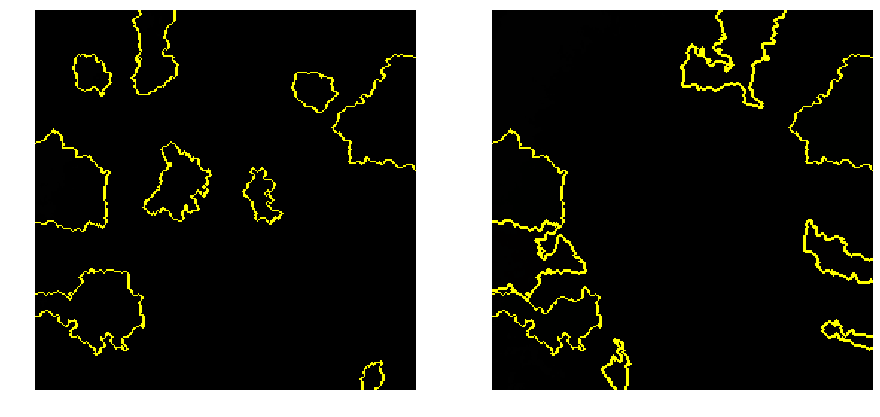

In [520]:
temp_1, mask_1 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=10, hide_rest=True)
temp_2, mask_2 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))
ax1.imshow(mark_boundaries(temp_1, mask_1))
ax2.imshow(mark_boundaries(temp_2, mask_2))
ax1.axis('off')
ax2.axis('off')

> comment here something about the image

We can do it again with a different image:

In [521]:
explanation = explainer.explain_instance(train_img64[11].astype('double'), model_bina.predict,  
                                         top_labels=2, hide_color=0, num_samples=100)

  0%|          | 0/100 [00:00<?, ?it/s]

(-0.5, 63.5, 63.5, -0.5)

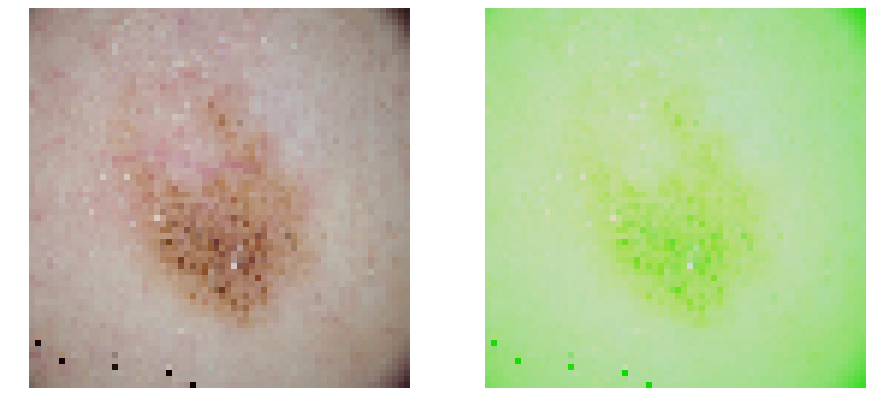

In [522]:
temp_1, mask_1 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
temp_2, mask_2 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))
ax1.imshow(mark_boundaries(temp_1, mask_1))
ax2.imshow(mark_boundaries(temp_2, mask_2))
ax1.axis('off')
ax2.axis('off')

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

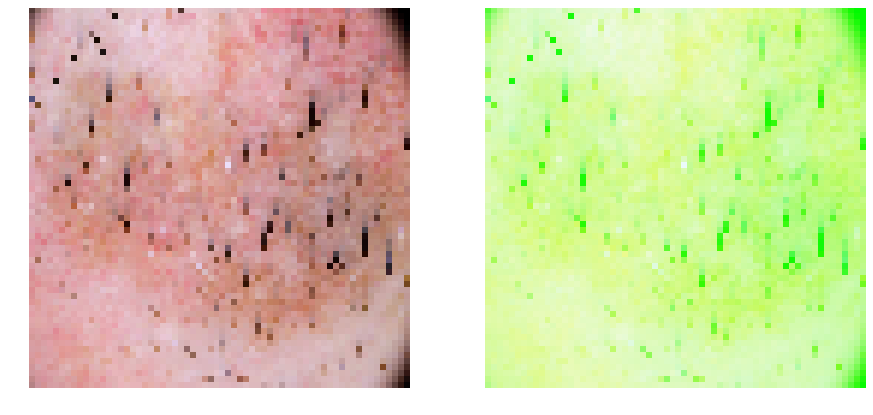

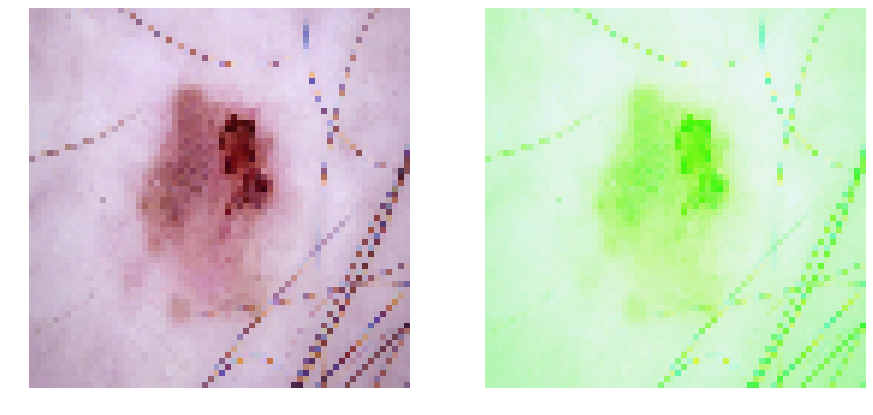

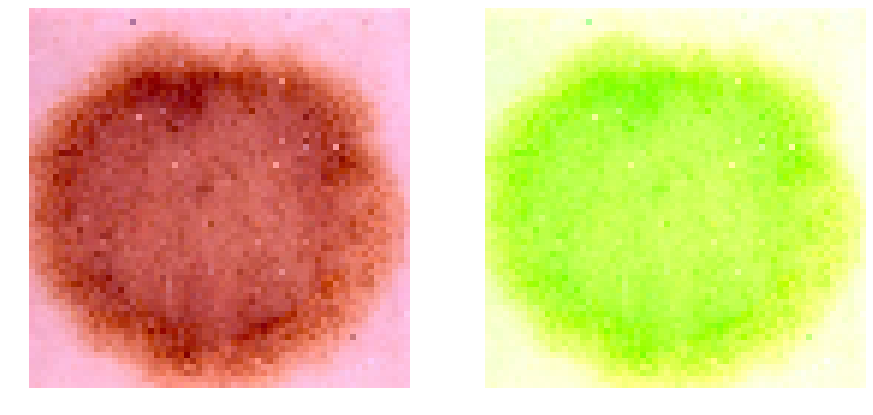

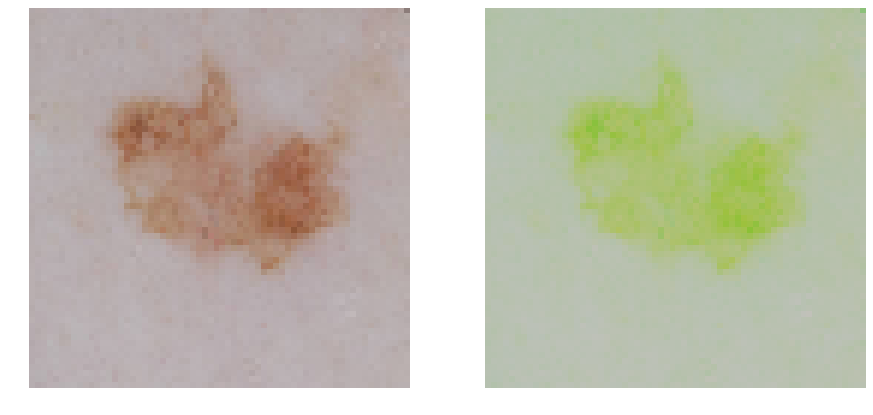

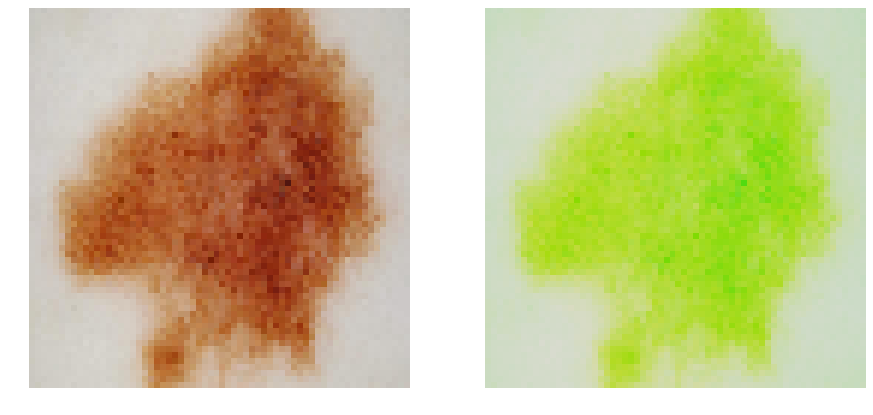

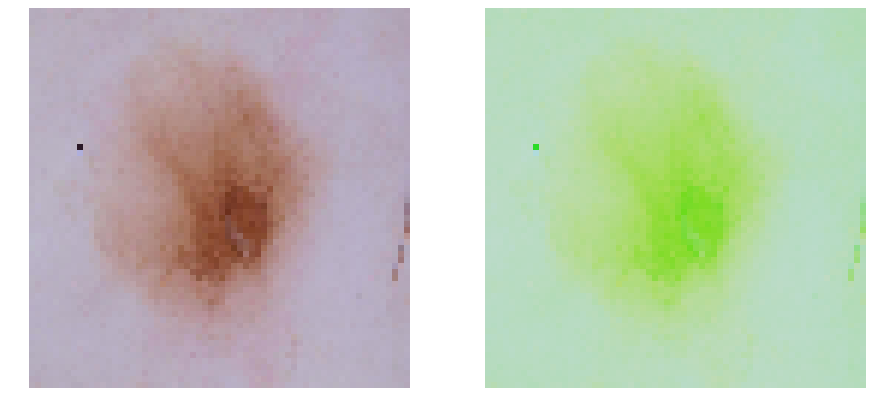

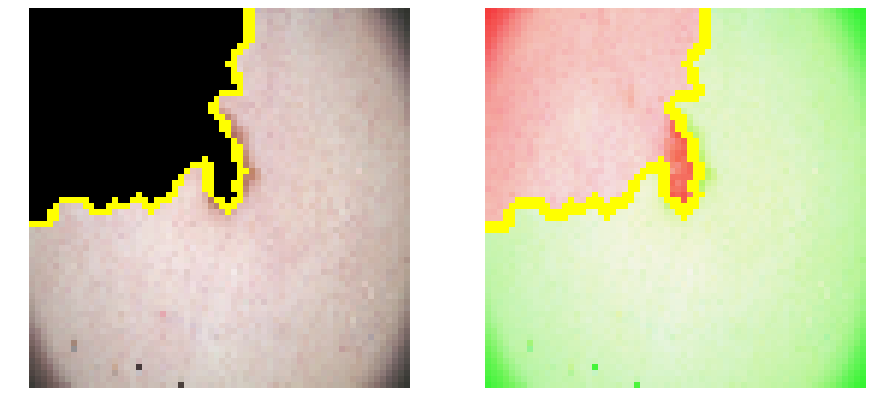

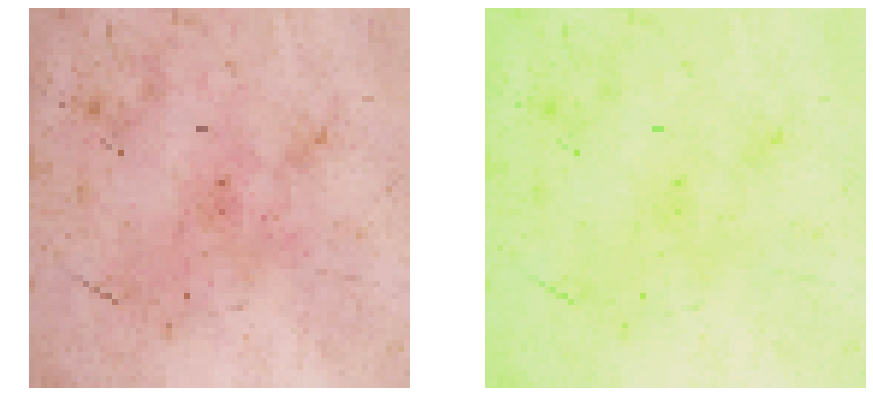

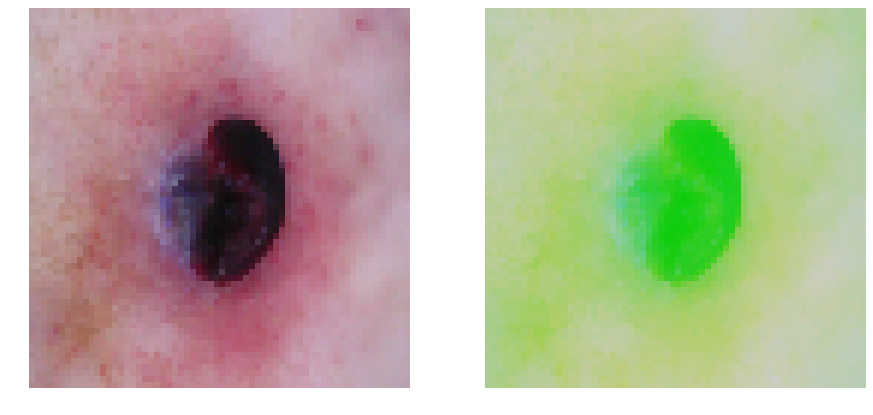

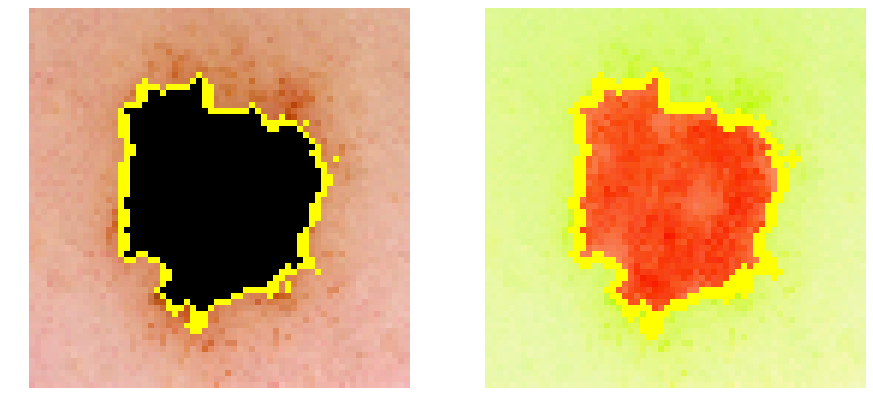

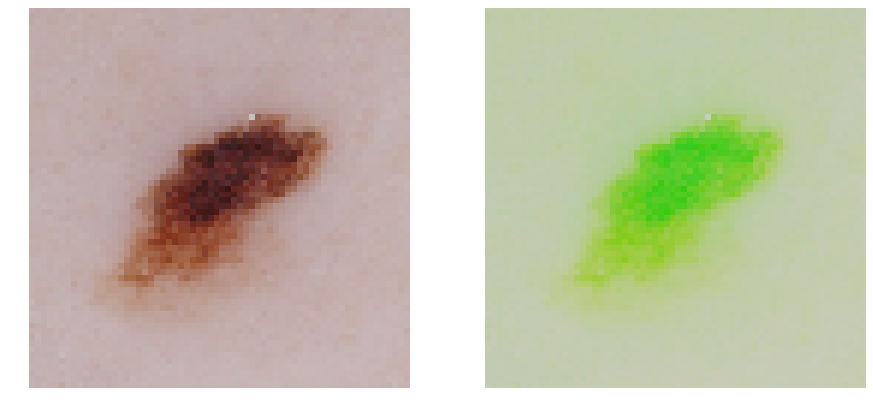

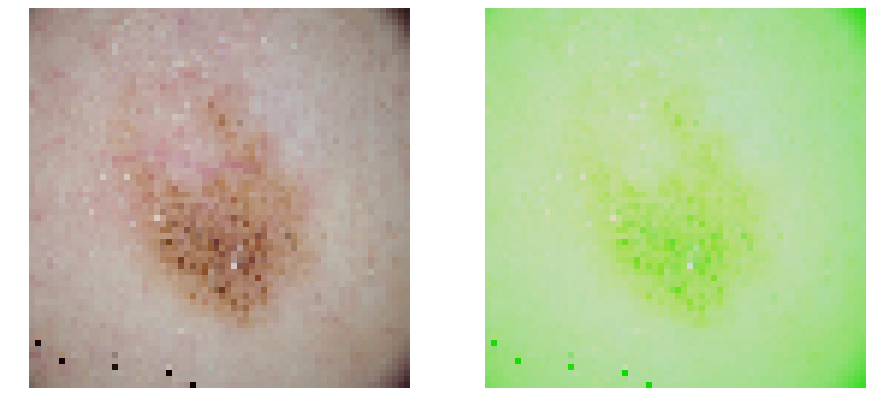

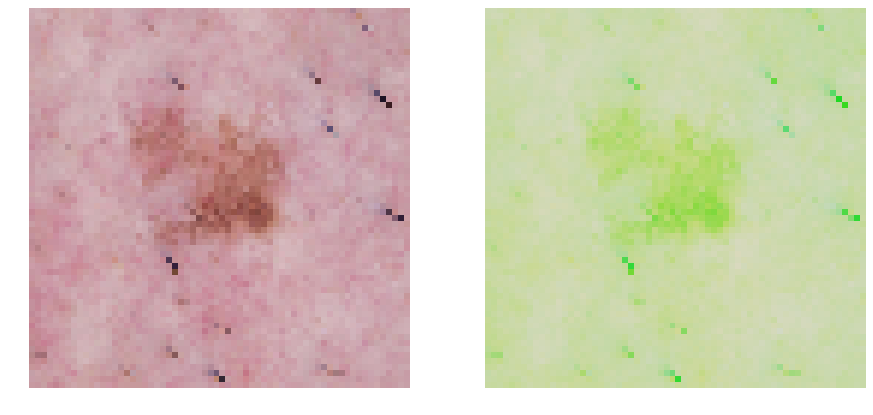

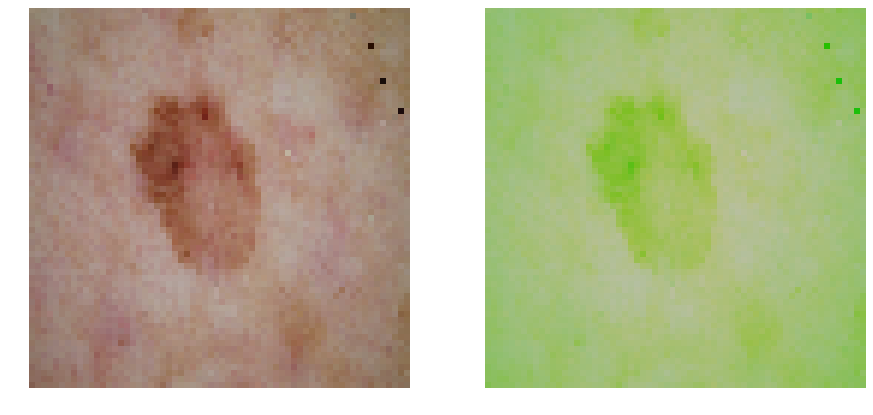

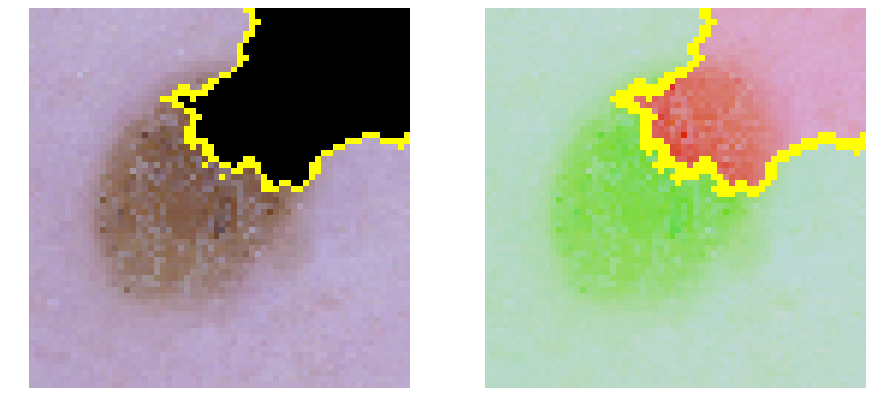

In [500]:
for i in range(5):
    explanation = explainer.explain_instance(train_img_fs[i].astype('double'), model_j.predict,  
                                         top_labels=2, hide_color=0, num_samples=100)
    temp_1, mask_1 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
    temp_2, mask_2 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))
    ax1.imshow(mark_boundaries(temp_1, mask_1))
    ax2.imshow(mark_boundaries(temp_2, mask_2))
    ax1.axis('off')
    ax2.axis('off')
    i+=1

> It would be good to run again the best model with highest size images,
and then run the LIME thing like 10 times in a loop
So one can check what parts of the images were used to identify
Even better would be to pick an image that was classified incorrectly VS one that was classified correctly.

### Visualizing activation layers:

In [ ]:
# Extract model layer outputs
layer_outputs = [layer.output for layer in model_bina.layers[:8]]

# Rather then a model with a single output, we are going to make a model to display the feature maps
activation_model = models.Model(inputs=model_bina.input, outputs=layer_outputs)


In [ ]:
model_bina.summary()

In [ ]:
# Returns an array for each activation layer
activations = activation_model.predict(train_img64)

first_layer_activation = activations[0]
print(first_layer_activation.shape)

# We slice the third channel and preview the results
plt.matshow(first_layer_activation[0, :, :, 3], cmap='viridis')
plt.show()

In [ ]:
# Repeating the process for another channel (the 30th)
activations = activation_model.predict(train_img64)

first_layer_activation = activations[0]
print(first_layer_activation.shape)

plt.matshow(first_layer_activation[0, :, :, 5], cmap='viridis')
plt.show()

In [ ]:
fig, axes = plt.subplots(2,3, figsize=(12,10))

layer_names = []
for layer in model_bina.layers[:8]:
    layer_names.append(layer.name)

for i in range(6):
    row = i//3
    column = i%3
    ax = axes[row, column]
    cur_layer = activations[i]
    ax.matshow(cur_layer[0, :, :, 6], cmap='viridis')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_title(layer_names[i])